In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import src.urban_diff_helper as ud_helper
import pandas as pd
from scipy.stats import wilcoxon,ttest_rel,kendalltau, spearmanr
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from src.urban_diff_helper import ADMIN_STR
from collections import defaultdict
from shapely.ops import cascaded_union
from itertools import combinations

In [3]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats


In [4]:
admin_strs = [ADMIN_STR(m,u) for m in [False, True] for u in [False,True]]

In [647]:
method_rename = {
    ('ageb', 'area'): 'CT, Uni',
    ('ageb', 'pop'): 'CT, Pop',
    ('g.5km', 'area'): 'G, Uni',
    ('g.5km', 'pop'): 'G, Pop',
    ('g.5km', '_idw10'): 'G, Idw',
    ('vor', 'area'): 'Vor, Uni',
    ('vor', 'pop'): 'Vor, Pop'
}

In [5]:
n_bins=24
area_normalization = False
print('n bins:', n_bins)
print('area_normalization:', area_normalization)

n bins: 24
area_normalization: False


In [199]:

raster_use_p_centroid_if_none, average_over_observed_day = False, True
# raster_use_p_centroid_if_none, average_over_observed_day = True, False
# make sure only these two combination is allowed
assert (raster_use_p_centroid_if_none, average_over_observed_day) in [(False, True), (True, False)]

# the buggy version
if (raster_use_p_centroid_if_none, average_over_observed_day) == (False, True):
    ud_helper.ftr_hs.MEASURES_DIR = 'data/mex_hotspot_measures_buggy'
    ud_helper.ftr_hs.RASTER_USE_P_CENTROID_IF_NONE = raster_use_p_centroid_if_none
print('ftr_hs.MEASURES_DIR', ud_helper.ftr_hs.MEASURES_DIR)
print('ftr_hs.RASTER_USE_P_CENTROID_IF_NONE', ud_helper.ftr_hs.RASTER_USE_P_CENTROID_IF_NONE)

ftr_hs.MEASURES_DIR data/mex_hotspot_measures_buggy
ftr_hs.RASTER_USE_P_CENTROID_IF_NONE False


# load geometries

In [7]:
zms, zms_agebs, zms_tvor, zms_grids, zms_sub_vors, mg_mappings = ud_helper.load_geoms()

loading zms
loading agebs
loading voronoi
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
==================== loading grids False False 2020-01-03 09:48:36.254747
=====computing mpa_grids
reading existing grids
==================== loading grids False True 2020-01-03 09:50:24.387692
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_whole_urb.geojson.gz
==================== loading grids True False 2020-01-03 09:50:28.889326
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_perMun_uNr.geojson.gz
==================== loading grids True True 2020-01-03 09:51:10.506239
loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_perMun_urb.geojson.gz
loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 CVE_SUN
len(p1)=5731 > 10 * len(p2)=59, swap them
computing area of the i

# load interpolation and interpolate avg

In [8]:
avg_tw, avg_a, avg_g, avg_idw, avg_vor = ud_helper.interpolation(
    zms_grids,
    zms_sub_vors,
    n_bins=n_bins,
    average_over_observed_day=average_over_observed_day)

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle
to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_area.csv
to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_uNr_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_urb_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_uNr_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_urb_area.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_uNr_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_whole_urb_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_uNr_pop.csv
to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_urb_pop.csv
interpolate_idw loading existing file

# statistics test

In [9]:
def sig_lvl(x):
    if x==-1 or x==0:
        return '-'
    if x <0.001:
        return '***'
    if x<0.01:
        return '**'
    if x<0.05:
        return '*'
    return ''

In [10]:
def statistics_test(test_func, stat_df, clean_table=False, larger_than=0.0):

    n_cols = stat_df.shape[1]
    p_values = np.zeros((n_cols, n_cols))
    test_measures = np.ones((n_cols, n_cols))
    for i in range(n_cols):
        for j in range(i + 1, n_cols):
            m, p = test_func(stat_df.iloc[:, i], stat_df.iloc[:, j])
            p_values[i, j] = p_values[j, i] = p
            test_measures[i, j] = test_measures[j, i] = m

    
    p_values = pd.DataFrame(p_values,
                          index=stat_df.columns,
                          columns=stat_df.columns)
    test_measures[test_measures<=larger_than] = 0
    test_measures = pd.DataFrame(test_measures,
                          index=stat_df.columns,
                          columns=stat_df.columns)
    
    if clean_table:
        p_values = p_values.applymap(sig_lvl)
#         test_measures = test_measures.applymap(lambda x: f'{x:.3f}')
    return p_values, test_measures

wilcoxon_test = lambda stat_df, clean_table, larger_than: statistics_test(wilcoxon, stat_df, clean_table, larger_than)
paired_t_test = lambda stat_df, clean_table, larger_than: statistics_test(ttest_rel, stat_df, clean_table, larger_than)
ken_tau_corr = lambda stat_df, clean_table, larger_than: statistics_test(kendalltau, stat_df, clean_table, larger_than)
spe_rho_corr = lambda stat_df, clean_table, larger_than: statistics_test(spearmanr, stat_df, clean_table, larger_than)

# draw function

In [11]:
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.core.display import HTML 

In [12]:
def draw_scatter(data_df, mode='lines+markers',height=600,margin_r=100):
    
    data = [
        go.Scatter(x='zm' + data_df.index.astype(str),
                   y=data_df[intpl_type].tolist(),
                   name=str(intpl_type),
                   mode='lines+markers'
                  ) for intpl_type in data_df
    ]
    fig = go.Figure()
    for trace in data:
        fig.add_trace(trace)
    fig.update_layout(height=height,margin=dict(l=10, r=margin_r, t=10, b=10),)

    offline.iplot(fig)

In [13]:
swap = lambda df, i, j: df.swaplevel(i,j).T.swaplevel(i,j).sort_index(level=range(len(df.columns.levels))).T.sort_index(level=range(len(df.columns.levels)))

In [14]:

def background_gradient(s, m=None, M=None,  cmap='Oranges', low=0, high=0.2):

    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


def grad_bg(df, cmap='Oranges', mini=None, maxi=None, high=0, mask_tril=False,format_float=True):
    if mini is None:
        mini = df.min().min()
    if maxi is None:
        maxi = df.max().max()
    if mask_tril:
        df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_),-1))
    format_str = "{:.3f}" if format_float else "{:.0f}"
    style= df.style.apply(background_gradient, m=mini, M=maxi, cmap=cmap, high=high).format(format_str).set_table_attributes("style='display:inline'")
    return HTML(style.render().replace('nan',''))

In [654]:
def grad_bg(df, cmap='Oranges', mini=None, maxi=None, high=0, mask_tril=False,format_float=True):
    if mini is None:
        mini = df.min().min()
    if maxi is None:
        maxi = df.max().max()
    if mask_tril:
        df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_),-1))
    format_str = "{:.2f}" if format_float else "{:.0f}"
    style= df.style.apply(background_gradient, m=mini, M=maxi, cmap=cmap, high=high).format(format_str).set_table_attributes("style='display:inline'")
    return HTML(style.render().replace('nan',''))

In [230]:
def grad_bg_with_str(df, mini, maxi, cmap='Oranges', high=0, mask_tril=False):
    
    def bg_color(arr, low=0, high=0.2):
#         print(arr)
        values = arr.apply(lambda x: float(x.split(' ')[0]) if type(x)==str else x).values
        rng = maxi - mini
        norm = colors.Normalize(mini - (rng * low),
                                maxi + (rng * high))
        normed = norm(values)
        c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
        return ['background-color: %s' % color for color in c]
    
    if mask_tril:
        df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_),-1))
    
    df.columns = [col.replace('_','<br/>') for col in df.columns]
    style= df.style.apply(bg_color, high=high)
    return HTML(style.render().replace('nan',''))

# urban dilatation index

In [20]:
# compute
print('computing dv_a')
dv_a = {}
for by, avg in avg_a.items():
    dv_a[by] = ud_helper.dilatation.dv_for_mpa_ageb(avg, zms, zms_agebs)

print('computing dv_g')
dv_g = {}
for (side, by, per_mun), avg in avg_g.items():
    zms_g = zms_grids[(side, per_mun)]
    dv_g[(side, by, per_mun)] = ud_helper.dilatation.dv_for_mpa_grids(avg, zms, zms_g)

print('computing dv_idw')
dv_idw = {}
for key, avg in avg_idw.items():
    zms_g = zms_grids[key]
    dv_idw[key] = ud_helper.dilatation.dv_for_mpa_grids(avg, zms, zms_g)

computing dv_a
computing dv_g
computing dv_idw


In [437]:
# flatten the dictionary of stats
var = 'dilatation coefficient'
a = {('ageb', 'area'):dv_a['area'][var], ('ageb', 'pop') : dv_a['pop'][var]}
g= {(f'g{side//1000}', by, ):dv[var] for (side, by, per_mun), dv in dv_g.items() if not per_mun}
idw= {(f'g{side//1000}','_idw') :dv[var] for (side, per_mun), dv in dv_idw.items() if not per_mun}
dila_coef = pd.DataFrame({**a, **g, **idw})

In [278]:
# Visualization
sort_col = ud_helper.zms_sort_cols[0]
dila_coef = dila_coef.loc[zms.sort_values(sort_col).index]

# sort_col = dila_coef.columns[0]
# dila_coef=dila_coef.sort_values(sort_col)
# print(sort_col)

draw_scatter(dila_coef, height=300)
draw_scatter(dila_coef.std(axis=1).to_frame(), height=300, margin_r=135)

In [460]:
64*59

3776

In [456]:
# even though (ageb, pop) and (g1 pop) has similar values, 
# but the std could also be small.
dila_wil_ps, _ = wilcoxon_test(dila_coef, clean_table=False)
grad_bg(dila_wil_ps, cmap='PuBu',high=.2)
# dila_wil_ps

In [470]:
dila_ken_ps, dila_ken_tau = ken_tau_corr(
    dila_coef, clean_table=False, larger_than=0.8)
print()
grad_bg(dila_ken_ps, cmap='PuBu',high=.2)

In [471]:
grad_bg(swap(dila_ken_tau,0,1))

In [472]:
grad_bg(swap(swap(dila_ken_tau,0,1),0,1))

# hotspots

In [730]:

raster_use_p_centroid_if_none, average_over_observed_day = False, True
# raster_use_p_centroid_if_none, average_over_observed_day = True, False
# make sure only these two combination is allowed
assert (raster_use_p_centroid_if_none, average_over_observed_day) in [(False, True), (True, False)]

# the buggy version
if (raster_use_p_centroid_if_none, average_over_observed_day) == (False, True):
    ud_helper.ftr_hs.MEASURES_DIR = 'data/mex_hotspot_measures_buggy'
    ud_helper.ftr_hs.RASTER_USE_P_CENTROID_IF_NONE = raster_use_p_centroid_if_none
print('ftr_hs.MEASURES_DIR', ud_helper.ftr_hs.MEASURES_DIR)
print('ftr_hs.RASTER_USE_P_CENTROID_IF_NONE', ud_helper.ftr_hs.RASTER_USE_P_CENTROID_IF_NONE)

ftr_hs.MEASURES_DIR data/mex_hotspot_measures_buggy
ftr_hs.RASTER_USE_P_CENTROID_IF_NONE False


In [731]:
loading = ('ageb', 'grid', 'idw', 'vor')
roll_width = 5
chunk_width = 4
hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor, hs_stats_tw = ud_helper.compute_hotspot_stats(
    avg_a, avg_g, avg_idw, avg_tw, avg_vor,
    zms, zms_agebs, zms_grids,zms_sub_vors,mg_mappings,
    hs_type='loubar',loading=loading, area_normalization=area_normalization, verbose=0, 
    roll_width=roll_width, chunk_width=chunk_width)

==================== ageb
('area', False, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', False, True) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', True, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('area', True, True) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
('pop', False, False) working on 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

## inter metro measurements correlation Kendall, spearmanr

In [429]:
def inter_metro_measurement(zms, hs_stats, geom_type, measure_type, time_range=None,measure_name=None,idw=False):
    measures = {}
    if type(hs_stats) is dict:
        for key, stats in hs_stats.items():
            if not idw:
                by, per_mun, urb_only = key
            else:
                by = '_idw10'
                per_mun, urb_only = key
                
            if time_range is None: 
                # for number of average hotspot
                measures[(ADMIN_STR(per_mun, urb_only), geom_type, by)] = [
                    stats[measure_type][sun]['average'] for sun in zms.index
                ]                
            else:
                # for compactness
                measures[(ADMIN_STR(per_mun, urb_only), geom_type, by)] = [
                    stats[measure_type][sun][time_range][measure_name] for sun in zms.index
                ]
                
    elif type(hs_stats) is list:
        assert len(hs_stats) == len(geom_type) == len(idw)
        for hstat, gtype, is_idw in zip(hs_stats, geom_type, idw):
            measures.update(inter_metro_measurement(zms, hstat, gtype, measure_type, time_range, measure_name, is_idw))
    return measures

In [548]:
hs_stats = [hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]
geom_types = ['ageb', 'g.5km', 'g.5km', 'vor']
idws = [False, False, True,False]
compactness_indexes = {}
for measure_name in ['comp_coef', 'mass_comp_coef', 'cohesion', 'proximity','NMI','NMMI']:
    for time_range in ['all_day', 'home_time', 'work_time']:
        compact = inter_metro_measurement(zms, hs_stats, geom_types, 'compactness', time_range, measure_name, idws)
        compact =  pd.DataFrame(compact,index=zms.index)
        compactness_indexes[(measure_name, time_range)] = compact

comp_ken_tau= []
comp_spr_rho = []
for (measure_name, time_range), compact in compactness_indexes.items():
    key_str = (measure_name + '<br>' + time_range).replace('_',' ')
    p_values, taus = ken_tau_corr(compact, clean_table=False,larger_than=.0)
    comp_ken_tau.append((key_str, taus))
    p_values, rhos = spe_rho_corr(compact, clean_table=False,larger_than=.0)
    comp_spr_rho.append((key_str, rhos))

In [549]:
hs_stats = [hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]
geom_types = ['ageb', 'g.5km', 'g.5km', 'vor']
idws = [False, False, True,False]
hs_scale_indexes = {}
for measure_name in ['NHS','AHS']:
    for time_range in ['all_day', 'home_time', 'work_time']:
        hs_scale = inter_metro_measurement(zms, hs_stats, geom_types, 'n_hs', time_range, measure_name, idws)
        hs_scale =  pd.DataFrame(hs_scale,index=zms.index)
        hs_scale_indexes[(measure_name, time_range)] = hs_scale

scale_ken_tau= []
scale_spr_rho = []
for (measure_name, time_range), hs_scale in hs_scale_indexes.items():
    key_str = (measure_name + '<br>' + time_range).replace('_',' ')
    p_values, taus = ken_tau_corr(hs_scale, clean_table=False,larger_than=.0)
    scale_ken_tau.append((key_str, taus))
    p_values, rhos = spe_rho_corr(hs_scale, clean_table=False,larger_than=.0)
    scale_spr_rho.append((key_str, rhos))

In [550]:
hs_stats = [hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]
geom_types = ['ageb', 'g.5km', 'g.5km', 'vor']
idws = [False, False, True,False]
average_number_hotspot = pd.DataFrame(inter_metro_measurement(zms, hs_stats, geom_types, 'n_hs', idw=idws),index=zms.index)

nhs_spr_ps, nhs_spr_rho = spe_rho_corr(average_number_hotspot, clean_table=False,larger_than=0.0)
nhs_ken_ps, nhs_ken_tau = ken_tau_corr(average_number_hotspot, clean_table=False,larger_than=0.0)


### table and plots of the correlations

#### compactness

In [170]:
comp_ken_ps, comp_ken_tau = ken_tau_corr(comp_coef, clean_table=False,larger_than=.0)
comp_spr_ps, comp_spr_rho = spe_rho_corr(comp_coef, clean_table=False, larger_than=.0)

In [219]:
comp_work_ken_ps, comp_work_ken_tau = ken_tau_corr(comp_coef_work, clean_table=False,larger_than=.0)
comp_work_spr_ps, comp_work_spr_rho = spe_rho_corr(comp_coef_work, clean_table=False, larger_than=.0)

In [220]:
comp_home_ken_ps, comp_home_ken_tau = ken_tau_corr(comp_coef_home, clean_table=False,larger_than=.0)
comp_home_spr_ps, comp_home_spr_rho = spe_rho_corr(comp_coef_home, clean_table=False, larger_than=.0)

In [40]:

swap_df = comp_ken_tau

display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True))

# swap_df = swap(swap_df, 0,2)
# # display(grad_bg(swap_df))
# swap_df = swap(swap_df, 1,2)
# display(grad_bg(swap_df))

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



In [236]:


sort_col = ud_helper.zms_sort_cols[3]
comp_coef = comp_coef.loc[zms.sort_values(sort_col).index]
sort_col = comp_coef.columns[0]
comp_coef=comp_coef.sort_values(sort_col)
print(sort_col)

draw_scatter(comp_coef, height=300)
draw_scatter(comp_coef.std(axis=1).to_frame(), height=300, margin_r=175)

('whole_uNr', 'ageb', 'area')


#### for N hotspot

In [379]:
# display(grad_bg(nhs_ken_tau.T.sort_index(level=0).T.sort_index(level=0),mini=0))

# swap_df = swap(nhs_ken_tau, 0,2)
# display(grad_bg(swap_df))

# swap_df = swap(swap_df, 1,2)
# display(grad_bg(swap_df))
# swap_df = swap(swap_df, 2,0)
# display(grad_bg(swap_df))

In [288]:

sort_col = Mean_number_hot.columns[0]
Mean_number_hot=Mean_number_hot.sort_values(sort_col)
print(sort_col)

draw_scatter(Mean_number_hot)

('ageb', nan, 'area', 'zm')


### display table

#### method-level pairwise corr
4 big table(Admin-bound); small table: per index, corr between methods

In [433]:
admin_strs = [ADMIN_STR(m,u) for m in [False, True] for u in [False,True]]

In [434]:
def print_table(astr, measurements, add_mean=False):
    print(astr.replace('_','\n'))
    for index_name, index_corr in measurements:
        tbl = index_corr.T.sort_index(level=0).T.sort_index(level=0).loc[astr, astr].copy()
        tbl.columns =['<br/>'.join(col).strip() for col in tbl.columns.values]
        tbl.index =['<br/>'.join(col).strip() for col in tbl.index.values]
        tbl.index.name=index_name
        if add_mean:
            tbl['row<br/>mean'] = (tbl.sum(axis=0)-1)/(tbl.shape[1]-1)
            
        dis_tbl = grad_bg(tbl, mask_tril=True, mini=0)
        display(dis_tbl)

In [616]:
# kendal Tau
i=3
astr=admin_strs[i]
measurements = [('Avg N HS', nhs_ken_tau)]+comp_ken_tau
print_table(astr, measurements)

PerMun
Urban


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
Avg N HS,,,,,,,
agebarea,1.000,0.780,0.586,0.648,0.727,0.763,0.708
agebpop,,1.000,0.525,0.604,0.704,0.744,0.712
g.5km_idw10,,,1.000,0.676,0.698,0.600,0.567
g.5kmarea,,,,1.000,0.801,0.587,0.545
g.5kmpop,,,,,1.000,0.672,0.639
vorarea,,,,,,1.000,0.904
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefall day,,,,,,,
agebarea,1.000,0.619,0.607,0.755,0.576,0.598,0.536
agebpop,,1.000,0.640,0.640,0.735,0.457,0.580
g.5km_idw10,,,1.000,0.736,0.693,0.591,0.529
g.5kmarea,,,,1.000,0.721,0.645,0.569
g.5kmpop,,,,,1.000,0.529,0.694
vorarea,,,,,,1.000,0.632
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefhome time,,,,,,,
agebarea,1.000,0.628,0.610,0.756,0.576,0.597,0.518
agebpop,,1.000,0.642,0.650,0.756,0.484,0.584
g.5km_idw10,,,1.000,0.744,0.702,0.604,0.544
g.5kmarea,,,,1.000,0.729,0.654,0.573
g.5kmpop,,,,,1.000,0.525,0.681
vorarea,,,,,,1.000,0.639
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
comp coefwork time,,,,,,,
agebarea,1.000,0.633,0.617,0.744,0.594,0.595,0.496
agebpop,,1.000,0.689,0.662,0.805,0.450,0.653
g.5km_idw10,,,1.000,0.742,0.756,0.562,0.622
g.5kmarea,,,,1.000,0.738,0.608,0.539
g.5kmpop,,,,,1.000,0.493,0.677
vorarea,,,,,,1.000,0.581
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionall day,,,,,,,
agebarea,1.000,0.513,0.336,0.570,0.357,0.527,0.397
agebpop,,1.000,0.534,0.494,0.721,0.404,0.548
g.5km_idw10,,,1.000,0.507,0.600,0.379,0.411
g.5kmarea,,,,1.000,0.584,0.578,0.479
g.5kmpop,,,,,1.000,0.410,0.610
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionhome time,,,,,,,
agebarea,1.000,0.509,0.330,0.555,0.350,0.590,0.395
agebpop,,1.000,0.531,0.470,0.724,0.468,0.568
g.5km_idw10,,,1.000,0.486,0.578,0.390,0.393
g.5kmarea,,,,1.000,0.545,0.579,0.426
g.5kmpop,,,,,1.000,0.445,0.614
vorarea,,,,,,1.000,0.620
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
cohesionwork time,,,,,,,
agebarea,1.000,0.518,0.345,0.551,0.428,0.608,0.377
agebpop,,1.000,0.514,0.514,0.777,0.452,0.634
g.5km_idw10,,,1.000,0.441,0.562,0.372,0.522
g.5kmarea,,,,1.000,0.615,0.627,0.480
g.5kmpop,,,,,1.000,0.490,0.710
vorarea,,,,,,1.000,0.575
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityall day,,,,,,,
agebarea,1.000,0.502,0.342,0.545,0.389,0.490,0.351
agebpop,,1.000,0.510,0.449,0.695,0.385,0.524
g.5km_idw10,,,1.000,0.437,0.523,0.328,0.373
g.5kmarea,,,,1.000,0.565,0.564,0.430
g.5kmpop,,,,,1.000,0.407,0.631
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximityhome time,,,,,,,
agebarea,1.000,0.492,0.348,0.571,0.387,0.535,0.370
agebpop,,1.000,0.494,0.460,0.707,0.447,0.535
g.5km_idw10,,,1.000,0.435,0.507,0.357,0.344
g.5kmarea,,,,1.000,0.522,0.578,0.416
g.5kmpop,,,,,1.000,0.458,0.632
vorarea,,,,,,1.000,0.604
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
proximitywork time,,,,,,,
agebarea,1.000,0.499,0.328,0.536,0.420,0.589,0.363
agebpop,,1.000,0.486,0.493,0.784,0.431,0.635
g.5km_idw10,,,1.000,0.387,0.494,0.307,0.453
g.5kmarea,,,,1.000,0.608,0.594,0.465
g.5kmpop,,,,,1.000,0.481,0.714
vorarea,,,,,,1.000,0.578
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIall day,,,,,,,
agebarea,1.000,0.513,0.336,0.570,0.357,0.527,0.397
agebpop,,1.000,0.534,0.494,0.721,0.404,0.548
g.5km_idw10,,,1.000,0.507,0.600,0.379,0.411
g.5kmarea,,,,1.000,0.584,0.578,0.479
g.5kmpop,,,,,1.000,0.410,0.610
vorarea,,,,,,1.000,0.531
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIhome time,,,,,,,
agebarea,1.000,0.509,0.330,0.555,0.350,0.590,0.395
agebpop,,1.000,0.531,0.470,0.724,0.468,0.568
g.5km_idw10,,,1.000,0.486,0.578,0.390,0.393
g.5kmarea,,,,1.000,0.545,0.579,0.426
g.5kmpop,,,,,1.000,0.445,0.614
vorarea,,,,,,1.000,0.620
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMIwork time,,,,,,,
agebarea,1.000,0.518,0.345,0.551,0.428,0.608,0.377
agebpop,,1.000,0.514,0.514,0.777,0.452,0.634
g.5km_idw10,,,1.000,0.441,0.562,0.372,0.522
g.5kmarea,,,,1.000,0.615,0.627,0.480
g.5kmpop,,,,,1.000,0.490,0.710
vorarea,,,,,,1.000,0.575
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIall day,,,,,,,
agebarea,1.000,0.437,0.286,0.617,0.382,0.537,0.288
agebpop,,1.000,0.496,0.472,0.807,0.462,0.564
g.5km_idw10,,,1.000,0.375,0.502,0.342,0.371
g.5kmarea,,,,1.000,0.461,0.631,0.384
g.5kmpop,,,,,1.000,0.440,0.645
vorarea,,,,,,1.000,0.382
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIhome time,,,,,,,
agebarea,1.000,0.420,0.295,0.627,0.376,0.570,0.330
agebpop,,1.000,0.513,0.466,0.808,0.474,0.608
g.5km_idw10,,,1.000,0.383,0.520,0.365,0.395
g.5kmarea,,,,1.000,0.477,0.662,0.434
g.5kmpop,,,,,1.000,0.467,0.702
vorarea,,,,,,1.000,0.438
vorpop,,,,,,,1.000


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop
NMMIwork time,,,,,,,
agebarea,1.000,0.424,0.309,0.638,0.416,0.571,0.315
agebpop,,1.000,0.502,0.459,0.835,0.455,0.672
g.5km_idw10,,,1.000,0.349,0.531,0.373,0.494
g.5kmarea,,,,1.000,0.493,0.629,0.364
g.5kmpop,,,,,1.000,0.475,0.715
vorarea,,,,,,1.000,0.442
vorpop,,,,,,,1.000


In [774]:
i = 3
target_index = 'comp coef'

In [775]:
# individual tabel of Rho

astr = admin_strs[i]
time_range = 'all day'
add_mean = True
mask_tril = True
for index_name, index_corr in measurements:
    if index_name ==f'{target_index}<br>{time_range}':
        break
if index_name!=f'{target_index}<br>{time_range}':
    raise ValueError('target not found')
tbl = index_corr.T.sort_index(level=0).T.sort_index(level=0).loc[astr, astr].copy()

tbl.index = [method_rename[col].replace(', ','<br/>') for col in tbl.index.values]
tbl.columns = [method_rename[col].replace(', ','<br/>') for col in tbl.columns.values]
if add_mean:
    tbl['Mean'] = (tbl.sum(axis=0)-1)/(tbl.shape[1]-1)
dis_tbl = grad_bg(tbl, mask_tril=mask_tril, mini=0)
html_str = dis_tbl.data
# Add left border
html_str = html_str.replace('_col7 {', '_col7 {\n            border-left: 2px solid black;')
html_str = html_str.replace('>Mean', 'style="border-left: 2px solid black">Mean')
# remove <br> in the index
for i, col in enumerate(tbl.index):
    html_str = html_str.replace(f'level0 row{i}" >{col}</th>', f'level0 row{i}" >{col.replace("<br/>", " ")}</th>')
HTML(html_str)

,CTUni,CTPop,GIdw,GUni,GPop,VorUni,VorPop,Mean
CT Uni,1.00,0.75,0.81,0.92,0.74,0.72,0.65,0.77
CT Pop,,1.00,0.81,0.78,0.86,0.59,0.72,0.75
G Idw,,,1.00,0.90,0.85,0.78,0.70,0.81
G Uni,,,,1.00,0.85,0.79,0.72,0.83
G Pop,,,,,1.00,0.69,0.87,0.81
Vor Uni,,,,,,1.00,0.74,0.72
Vor Pop,,,,,,,1.00,0.73


In [635]:
# Spearman Rho
i = 0
astr = admin_strs[i]
measurements = [('Avg N HS', nhs_spr_rho)]+scale_spr_rho+comp_spr_rho
print_table(astr, measurements, add_mean=True)

Metro
UR


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
Avg N HS,,,,,,,,
agebarea,1.000,0.839,0.217,0.550,0.806,0.739,0.735,0.648
agebpop,,1.000,0.308,0.497,0.895,0.846,0.848,0.706
g.5km_idw10,,,1.000,0.124,0.241,0.362,0.353,0.268
g.5kmarea,,,,1.000,0.615,0.269,0.244,0.383
g.5kmpop,,,,,1.000,0.823,0.809,0.698
vorarea,,,,,,1.000,0.995,0.673
vorpop,,,,,,,1.000,0.664


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NHSall day,,,,,,,,
agebarea,1.000,0.774,0.000,0.287,0.672,0.537,0.532,0.467
agebpop,,1.000,0.007,0.265,0.767,0.671,0.673,0.526
g.5km_idw10,,,1.000,0.058,0.000,0.109,0.109,0.047
g.5kmarea,,,,1.000,0.444,0.000,0.000,0.176
g.5kmpop,,,,,1.000,0.623,0.610,0.519
vorarea,,,,,,1.000,0.980,0.487
vorpop,,,,,,,1.000,0.484


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NHShome time,,,,,,,,
agebarea,1.000,0.768,0.029,0.350,0.630,0.563,0.555,0.482
agebpop,,1.000,0.072,0.366,0.791,0.695,0.697,0.565
g.5km_idw10,,,1.000,0.108,0.056,0.182,0.162,0.101
g.5kmarea,,,,1.000,0.498,0.059,0.031,0.235
g.5kmpop,,,,,1.000,0.665,0.645,0.547
vorarea,,,,,,1.000,0.984,0.525
vorpop,,,,,,,1.000,0.512


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NHSwork time,,,,,,,,
agebarea,1.000,0.816,0.121,0.497,0.763,0.675,0.679,0.592
agebpop,,1.000,0.266,0.440,0.847,0.793,0.787,0.658
g.5km_idw10,,,1.000,0.032,0.206,0.330,0.318,0.212
g.5kmarea,,,,1.000,0.620,0.162,0.137,0.315
g.5kmpop,,,,,1.000,0.745,0.726,0.651
vorarea,,,,,,1.000,0.994,0.616
vorpop,,,,,,,1.000,0.607


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
AHSall day,,,,,,,,
agebarea,1.000,0.760,0.000,0.365,0.716,0.231,0.172,0.374
agebpop,,1.000,0.026,0.429,0.759,0.303,0.190,0.411
g.5km_idw10,,,1.000,0.078,0.000,0.164,0.119,0.065
g.5kmarea,,,,1.000,0.462,0.471,0.423,0.371
g.5kmpop,,,,,1.000,0.281,0.264,0.414
vorarea,,,,,,1.000,0.744,0.366
vorpop,,,,,,,1.000,0.319


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
AHShome time,,,,,,,,
agebarea,1.000,0.791,0.083,0.480,0.693,0.309,0.249,0.434
agebpop,,1.000,0.063,0.507,0.792,0.346,0.293,0.465
g.5km_idw10,,,1.000,0.123,0.076,0.137,0.090,0.095
g.5kmarea,,,,1.000,0.518,0.517,0.411,0.426
g.5kmpop,,,,,1.000,0.294,0.281,0.442
vorarea,,,,,,1.000,0.761,0.394
vorpop,,,,,,,1.000,0.347


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
AHSwork time,,,,,,,,
agebarea,1.000,0.819,0.127,0.570,0.767,0.408,0.285,0.496
agebpop,,1.000,0.238,0.576,0.868,0.441,0.310,0.542
g.5km_idw10,,,1.000,0.068,0.256,0.298,0.247,0.206
g.5kmarea,,,,1.000,0.632,0.550,0.456,0.475
g.5kmpop,,,,,1.000,0.533,0.455,0.585
vorarea,,,,,,1.000,0.795,0.504
vorpop,,,,,,,1.000,0.425


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp coefall day,,,,,,,,
agebarea,1.000,0.756,0.683,0.747,0.810,0.371,0.282,0.608
agebpop,,1.000,0.561,0.615,0.780,0.478,0.283,0.579
g.5km_idw10,,,1.000,0.630,0.727,0.480,0.587,0.611
g.5kmarea,,,,1.000,0.660,0.302,0.423,0.563
g.5kmpop,,,,,1.000,0.402,0.407,0.631
vorarea,,,,,,1.000,0.603,0.439
vorpop,,,,,,,1.000,0.431


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp coefhome time,,,,,,,,
agebarea,1.000,0.742,0.683,0.761,0.839,0.411,0.343,0.630
agebpop,,1.000,0.536,0.598,0.801,0.525,0.365,0.595
g.5km_idw10,,,1.000,0.608,0.731,0.503,0.548,0.602
g.5kmarea,,,,1.000,0.653,0.366,0.408,0.566
g.5kmpop,,,,,1.000,0.490,0.487,0.667
vorarea,,,,,,1.000,0.714,0.502
vorpop,,,,,,,1.000,0.477


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp coefwork time,,,,,,,,
agebarea,1.000,0.783,0.592,0.781,0.783,0.416,0.356,0.618
agebpop,,1.000,0.555,0.632,0.810,0.573,0.364,0.620
g.5km_idw10,,,1.000,0.531,0.681,0.488,0.516,0.561
g.5kmarea,,,,1.000,0.704,0.383,0.523,0.592
g.5kmpop,,,,,1.000,0.494,0.402,0.646
vorarea,,,,,,1.000,0.695,0.508
vorpop,,,,,,,1.000,0.476


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
mass comp coefall day,,,,,,,,
agebarea,1.000,0.738,0.647,0.771,0.785,0.389,0.303,0.605
agebpop,,1.000,0.590,0.635,0.756,0.474,0.293,0.581
g.5km_idw10,,,1.000,0.593,0.759,0.535,0.659,0.630
g.5kmarea,,,,1.000,0.689,0.314,0.424,0.571
g.5kmpop,,,,,1.000,0.378,0.427,0.632
vorarea,,,,,,1.000,0.604,0.449
vorpop,,,,,,,1.000,0.452


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
mass comp coefhome time,,,,,,,,
agebarea,1.000,0.764,0.643,0.793,0.767,0.400,0.385,0.625
agebpop,,1.000,0.563,0.641,0.790,0.554,0.357,0.612
g.5km_idw10,,,1.000,0.608,0.716,0.579,0.618,0.621
g.5kmarea,,,,1.000,0.725,0.368,0.496,0.605
g.5kmpop,,,,,1.000,0.475,0.403,0.646
vorarea,,,,,,1.000,0.689,0.511
vorpop,,,,,,,1.000,0.491


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
mass comp coefwork time,,,,,,,,
agebarea,1.000,0.739,0.656,0.791,0.807,0.408,0.387,0.631
agebpop,,1.000,0.587,0.619,0.784,0.503,0.359,0.598
g.5km_idw10,,,1.000,0.626,0.776,0.598,0.623,0.644
g.5kmarea,,,,1.000,0.692,0.358,0.459,0.591
g.5kmpop,,,,,1.000,0.441,0.454,0.659
vorarea,,,,,,1.000,0.715,0.504
vorpop,,,,,,,1.000,0.500


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesionall day,,,,,,,,
agebarea,1.000,0.551,0.464,0.526,0.668,0.167,0.253,0.438
agebpop,,1.000,0.443,0.527,0.608,0.314,0.328,0.462
g.5km_idw10,,,1.000,0.266,0.532,0.306,0.432,0.407
g.5kmarea,,,,1.000,0.542,0.162,0.046,0.345
g.5kmpop,,,,,1.000,0.180,0.299,0.471
vorarea,,,,,,1.000,0.803,0.322
vorpop,,,,,,,1.000,0.360


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesionhome time,,,,,,,,
agebarea,1.000,0.572,0.341,0.528,0.562,0.020,0.113,0.356
agebpop,,1.000,0.394,0.462,0.715,0.167,0.250,0.427
g.5km_idw10,,,1.000,0.258,0.582,0.240,0.458,0.379
g.5kmarea,,,,1.000,0.502,0.024,0.011,0.297
g.5kmpop,,,,,1.000,0.138,0.357,0.476
vorarea,,,,,,1.000,0.747,0.223
vorpop,,,,,,,1.000,0.323


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesionwork time,,,,,,,,
agebarea,1.000,0.523,0.403,0.510,0.685,0.154,0.237,0.419
agebpop,,1.000,0.418,0.530,0.681,0.369,0.378,0.483
g.5km_idw10,,,1.000,0.215,0.475,0.437,0.570,0.420
g.5kmarea,,,,1.000,0.544,0.124,0.086,0.335
g.5kmpop,,,,,1.000,0.164,0.326,0.479
vorarea,,,,,,1.000,0.814,0.344
vorpop,,,,,,,1.000,0.402


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximityall day,,,,,,,,
agebarea,1.000,0.552,0.474,0.499,0.645,0.150,0.230,0.425
agebpop,,1.000,0.405,0.488,0.677,0.298,0.308,0.455
g.5km_idw10,,,1.000,0.306,0.532,0.317,0.403,0.406
g.5kmarea,,,,1.000,0.565,0.184,0.056,0.350
g.5kmpop,,,,,1.000,0.200,0.311,0.489
vorarea,,,,,,1.000,0.798,0.324
vorpop,,,,,,,1.000,0.351


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximityhome time,,,,,,,,
agebarea,1.000,0.576,0.375,0.533,0.587,0.041,0.125,0.373
agebpop,,1.000,0.376,0.461,0.729,0.185,0.246,0.429
g.5km_idw10,,,1.000,0.319,0.526,0.290,0.461,0.391
g.5kmarea,,,,1.000,0.564,0.028,0.013,0.320
g.5kmpop,,,,,1.000,0.163,0.363,0.489
vorarea,,,,,,1.000,0.755,0.244
vorpop,,,,,,,1.000,0.327


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximitywork time,,,,,,,,
agebarea,1.000,0.518,0.428,0.464,0.638,0.168,0.205,0.404
agebpop,,1.000,0.411,0.505,0.669,0.336,0.351,0.465
g.5km_idw10,,,1.000,0.285,0.506,0.416,0.529,0.429
g.5kmarea,,,,1.000,0.600,0.118,0.061,0.339
g.5kmpop,,,,,1.000,0.191,0.335,0.490
vorarea,,,,,,1.000,0.816,0.341
vorpop,,,,,,,1.000,0.383


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMIall day,,,,,,,,
agebarea,1.000,0.551,0.464,0.528,0.668,0.167,0.253,0.438
agebpop,,1.000,0.443,0.527,0.608,0.314,0.328,0.462
g.5km_idw10,,,1.000,0.264,0.532,0.306,0.432,0.407
g.5kmarea,,,,1.000,0.542,0.160,0.043,0.344
g.5kmpop,,,,,1.000,0.180,0.299,0.471
vorarea,,,,,,1.000,0.803,0.322
vorpop,,,,,,,1.000,0.360


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMIhome time,,,,,,,,
agebarea,1.000,0.572,0.341,0.527,0.562,0.020,0.113,0.356
agebpop,,1.000,0.394,0.460,0.715,0.167,0.250,0.426
g.5km_idw10,,,1.000,0.256,0.582,0.240,0.458,0.378
g.5kmarea,,,,1.000,0.500,0.024,0.011,0.296
g.5kmpop,,,,,1.000,0.138,0.357,0.476
vorarea,,,,,,1.000,0.747,0.223
vorpop,,,,,,,1.000,0.323


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMIwork time,,,,,,,,
agebarea,1.000,0.523,0.403,0.510,0.685,0.154,0.237,0.419
agebpop,,1.000,0.418,0.530,0.681,0.369,0.378,0.483
g.5km_idw10,,,1.000,0.215,0.475,0.437,0.570,0.420
g.5kmarea,,,,1.000,0.544,0.124,0.086,0.335
g.5kmpop,,,,,1.000,0.164,0.326,0.479
vorarea,,,,,,1.000,0.814,0.344
vorpop,,,,,,,1.000,0.402


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMIall day,,,,,,,,
agebarea,1.000,0.527,0.414,0.564,0.647,0.254,0.218,0.437
agebpop,,1.000,0.413,0.477,0.678,0.397,0.271,0.460
g.5km_idw10,,,1.000,0.195,0.531,0.345,0.452,0.392
g.5kmarea,,,,1.000,0.480,0.146,0.095,0.326
g.5kmpop,,,,,1.000,0.304,0.378,0.503
vorarea,,,,,,1.000,0.772,0.370
vorpop,,,,,,,1.000,0.364


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMIhome time,,,,,,,,
agebarea,1.000,0.537,0.376,0.630,0.625,0.208,0.199,0.429
agebpop,,1.000,0.421,0.506,0.780,0.372,0.290,0.484
g.5km_idw10,,,1.000,0.209,0.576,0.410,0.485,0.413
g.5kmarea,,,,1.000,0.516,0.098,0.088,0.341
g.5kmpop,,,,,1.000,0.344,0.500,0.557
vorarea,,,,,,1.000,0.732,0.361
vorpop,,,,,,,1.000,0.382


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMIwork time,,,,,,,,
agebarea,1.000,0.586,0.364,0.596,0.671,0.274,0.263,0.459
agebpop,,1.000,0.369,0.515,0.774,0.437,0.359,0.506
g.5km_idw10,,,1.000,0.136,0.439,0.380,0.499,0.364
g.5kmarea,,,,1.000,0.512,0.152,0.135,0.341
g.5kmpop,,,,,1.000,0.313,0.405,0.519
vorarea,,,,,,1.000,0.815,0.395
vorpop,,,,,,,1.000,0.413


#### index-level mean corr
1 big table, col: admin-bound, row: indexes, values: average of corr between method-pairs

In [436]:
from collections import defaultdict

def index_level_tables(correlations,n_digit=3):
    avers = defaultdict(dict)
    stds = defaultdict(dict)
    display_tbl = defaultdict(dict)
    error_bars = defaultdict(lambda: defaultdict(dict))
    for astr in admin_strs:
        for index_name, index_corr in correlations:
            tbl = index_corr.T.sort_index(level=0).T.sort_index(level=0).loc[astr, astr].copy()

            # get the upper triangular of matrix
            corr = []
            for i in range(len(tbl)):
                for j in range(i+1, len(tbl)):
                    corr.append(tbl.iloc[i,j])
            corr = np.array(corr)

            astr_repl = astr.replace('_','\n')
            avers[astr_repl][index_name] = corr.mean()
            stds[astr_repl][index_name] = corr.std()
            if n_digit==3:
                display_tbl[astr][index_name] = f'{corr.mean():.3f} ({corr.std():.3f})'
            else:
                display_tbl[astr][index_name] = f'{corr.mean():.2f} ({corr.std():.2f})'
            bsres = bs.bootstrap(corr, bs_stats.mean)
            error_bars[astr][index_name]['lower'] = bsres.value - bsres.lower_bound
            error_bars[astr][index_name]['upper'] = bsres.upper_bound - bsres.value
            
    return avers, stds, display_tbl, error_bars

,"heading level0 col0"" >MetroUrbanRural","heading level0 col1"" >MetroUrban","heading level0 col2"" >PerMunUrbanRural","heading level0 col3"" >PerMunUrban"
"32ca2dca16ea11eab53cd4ae52d07f78level0row0"" class=""rowheading level0 row0"" >Avg N HS","32ca2dca16ea11eab53cd4ae52d07f78row0col0"" class=""data row0 col0"" >0.452 (0.238)","32ca2dca16ea11eab53cd4ae52d07f78row0col1"" class=""data row0 col1"" >0.640 (0.111)","32ca2dca16ea11eab53cd4ae52d07f78row0col2"" class=""data row0 col2"" >0.520 (0.169)","32ca2dca16ea11eab53cd4ae52d07f78row0col3"" class=""data row0 col3"" >0.676 (0.092)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row1"" class=""rowheading level0 row1"" >comp coefall day","32ca2dca16ea11eab53cd4ae52d07f78row1col0"" class=""data row1 col0"" >0.424 (0.134)","32ca2dca16ea11eab53cd4ae52d07f78row1col1"" class=""data row1 col1"" >0.483 (0.125)","32ca2dca16ea11eab53cd4ae52d07f78row1col2"" class=""data row1 col2"" >0.555 (0.148)","32ca2dca16ea11eab53cd4ae52d07f78row1col3"" class=""data row1 col3"" >0.623 (0.077)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row2"" class=""rowheading level0 row2"" >comp coefhome time","32ca2dca16ea11eab53cd4ae52d07f78row2col0"" class=""data row2 col0"" >0.447 (0.130)","32ca2dca16ea11eab53cd4ae52d07f78row2col1"" class=""data row2 col1"" >0.514 (0.110)","32ca2dca16ea11eab53cd4ae52d07f78row2col2"" class=""data row2 col2"" >0.561 (0.144)","32ca2dca16ea11eab53cd4ae52d07f78row2col3"" class=""data row2 col3"" >0.628 (0.077)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row3"" class=""rowheading level0 row3"" >comp coefwork time","32ca2dca16ea11eab53cd4ae52d07f78row3col0"" class=""data row3 col0"" >0.449 (0.124)","32ca2dca16ea11eab53cd4ae52d07f78row3col1"" class=""data row3 col1"" >0.550 (0.102)","32ca2dca16ea11eab53cd4ae52d07f78row3col2"" class=""data row3 col2"" >0.549 (0.168)","32ca2dca16ea11eab53cd4ae52d07f78row3col3"" class=""data row3 col3"" >0.631 (0.092)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row4"" class=""rowheading level0 row4"" >cohesionall day","32ca2dca16ea11eab53cd4ae52d07f78row4col0"" class=""data row4 col0"" >0.293 (0.154)","32ca2dca16ea11eab53cd4ae52d07f78row4col1"" class=""data row4 col1"" >0.391 (0.080)","32ca2dca16ea11eab53cd4ae52d07f78row4col2"" class=""data row4 col2"" >0.369 (0.142)","32ca2dca16ea11eab53cd4ae52d07f78row4col3"" class=""data row4 col3"" >0.499 (0.096)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row5"" class=""rowheading level0 row5"" >cohesionhome time","32ca2dca16ea11eab53cd4ae52d07f78row5col0"" class=""data row5 col0"" >0.262 (0.174)","32ca2dca16ea11eab53cd4ae52d07f78row5col1"" class=""data row5 col1"" >0.388 (0.084)","32ca2dca16ea11eab53cd4ae52d07f78row5col2"" class=""data row5 col2"" >0.343 (0.150)","32ca2dca16ea11eab53cd4ae52d07f78row5col3"" class=""data row5 col3"" >0.503 (0.099)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row6"" class=""rowheading level0 row6"" >cohesionwork time","32ca2dca16ea11eab53cd4ae52d07f78row6col0"" class=""data row6 col0"" >0.305 (0.163)","32ca2dca16ea11eab53cd4ae52d07f78row6col1"" class=""data row6 col1"" >0.399 (0.091)","32ca2dca16ea11eab53cd4ae52d07f78row6col2"" class=""data row6 col2"" >0.334 (0.152)","32ca2dca16ea11eab53cd4ae52d07f78row6col3"" class=""data row6 col3"" >0.529 (0.107)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row7"" class=""rowheading level0 row7"" >proximityall day","32ca2dca16ea11eab53cd4ae52d07f78row7col0"" class=""data row7 col0"" >0.291 (0.152)","32ca2dca16ea11eab53cd4ae52d07f78row7col1"" class=""data row7 col1"" >0.389 (0.097)","32ca2dca16ea11eab53cd4ae52d07f78row7col2"" class=""data row7 col2"" >0.375 (0.140)","32ca2dca16ea11eab53cd4ae52d07f78row7col3"" class=""data row7 col3"" >0.475 (0.096)"
"32ca2dca16ea11eab53cd4ae52d07f78level0row8"" class=""rowheading level0 row8"" >proximityhome time","32ca2dca16ea11eab53cd4ae52d07f78row8col0"" class=""data row8 col0"" >0.267 (0.169)","32ca2dca16ea11eab53cd4ae52d07f78row8col1"" class=""data row8 col1"" >0.395 (0.096)","32ca2dca16ea11eab53cd4ae52d07f78row8col2"" class=""data row8 col2"" >0.

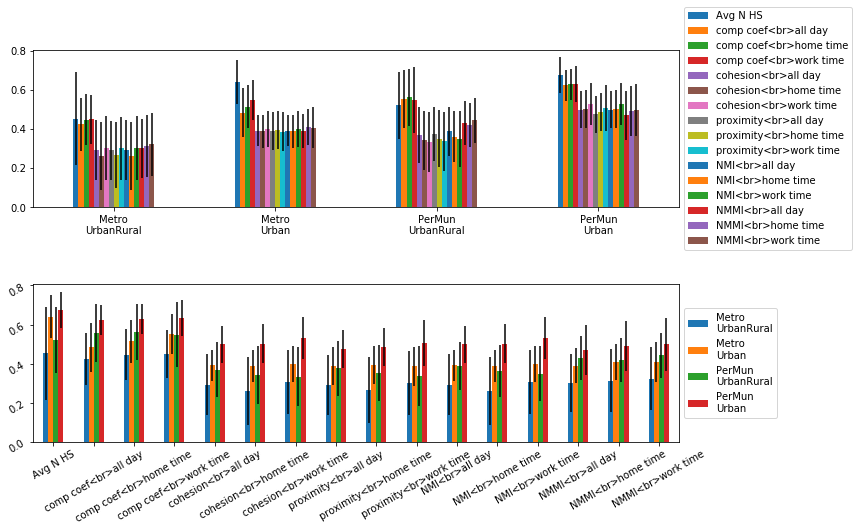

In [624]:
# kendall Tau
# corrleations = [
#     ('Comp Coef', comp_ken_tau), 
#     ('Comp Coef Work', comp_work_ken_tau), 
#     ('Comp Coef Home', comp_home_ken_tau), 
#     ('Avg N HS', nhs_ken_tau)
# ]
corrleations = [('Avg N HS', nhs_ken_tau)]+comp_ken_tau

avers, stds, display_tbl = index_level_tables(corrleations)
display(HTML(pd.DataFrame(display_tbl).style.render().replace('_','<br/>')))

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2, 
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
img = avers_plot.plot(ax=ax1, kind='bar',yerr=pd.DataFrame(stds).T).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
img = avers_plot.plot(ax=ax2, kind='bar',yerr=pd.DataFrame(stds)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

plt.savefig('figs/methodLevel_KendallTau.png', bbox_inches='tight')

,MetroUR,MetroU,PerMuniUR,PerMuniU
Avg N HS,0.58 (0.27),0.80 (0.10),0.68 (0.18),0.84 (0.08)
NHSall day,0.39 (0.31),0.61 (0.17),0.65 (0.16),0.76 (0.09)
NHShome time,0.42 (0.30),0.68 (0.14),0.67 (0.15),0.80 (0.08)
NHSwork time,0.52 (0.28),0.74 (0.12),0.65 (0.18),0.80 (0.09)
AHSall day,0.33 (0.24),0.64 (0.17),0.55 (0.17),0.81 (0.06)
AHShome time,0.37 (0.24),0.73 (0.14),0.57 (0.16),0.85 (0.05)
AHSwork time,0.46 (0.22),0.76 (0.12),0.58 (0.16),0.86 (0.05)
comp coefall day,0.55 (0.17),0.61 (0.16),0.71 (0.17),0.77 (0.08)
comp coefhome time,0.58 (0.15),0.64 (0.15),0.72 (0.16),0.78 (0.08)
comp coefwork time,0.57 (0.14),0.68 (0.13),0.70 (0.19),0.78 (0.10)


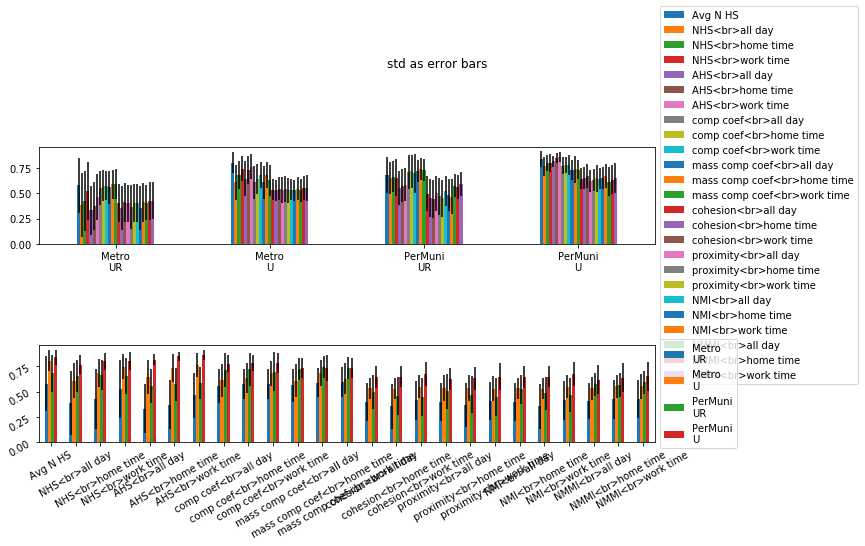

In [776]:
# Spearman Rho
# corrleations = [
#     ('Comp Coef', comp_spr_rho), 
#     ('Comp Coef Work', comp_work_spr_rho), 
#     ('Comp Coef Home', comp_home_spr_rho), 
#     ('Avg N HS', nhs_spr_rho)
# ]

n_digit=2
corrleations = [('Avg N HS', nhs_spr_rho)]+scale_spr_rho+comp_spr_rho

avers, stds, display_tbl,error_bars = index_level_tables(corrleations,n_digit=n_digit)
# display(HTML(pd.DataFrame(display_tbl).style.render().replace('_time','').replace('_','<br/>')))
tmp_df=pd.DataFrame(display_tbl)
tmp_df.columns = [col.replace('_','<br/>') for col in tmp_df.columns]
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2,
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
img = avers_plot.plot(ax=ax1, kind='bar',yerr=pd.DataFrame(stds).T).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
img = avers_plot.plot(ax=ax2, kind='bar',yerr=pd.DataFrame(stds)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('std as error bars')
fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

# plt.savefig('figs/methodLevel_SpearmnRho.png', bbox_inches='tight')

In [778]:
iname_change = {'NHS':'NHS', 'AHS':'AHS', 'comp coef':'COMP', 'mass comp coef':'MCOMP', 'cohesion':'COHE', 'proximity':'PROX','NMI':'NMI', 'NMMI':'NMMI'}

for time_range in ['all', 'work','home']:
    print(time_range)
    slice_index = [ind for ind in tmp_df.index if time_range in ind]
    slice_df = tmp_df.loc[slice_index]
    slice_df.index = [iname_change[ind.split('<')[0]] for ind in slice_df.index]
    display(grad_bg_with_str(slice_df, 0, 1, mask_tril=False))


all


,MetroUR,MetroU,PerMuniUR,PerMuniU
NHS,0.39 (0.31),0.61 (0.17),0.65 (0.16),0.76 (0.09)
AHS,0.33 (0.24),0.64 (0.17),0.55 (0.17),0.81 (0.06)
COMP,0.55 (0.17),0.61 (0.16),0.71 (0.17),0.77 (0.08)
MCOMP,0.56 (0.16),0.61 (0.16),0.72 (0.11),0.73 (0.10)
COHE,0.40 (0.19),0.53 (0.10),0.49 (0.17),0.64 (0.11)
PROX,0.40 (0.19),0.53 (0.13),0.50 (0.17),0.62 (0.11)
NMI,0.40 (0.19),0.53 (0.10),0.52 (0.15),0.64 (0.11)
NMMI,0.41 (0.17),0.53 (0.11),0.57 (0.11),0.62 (0.14)


work


,MetroUR,MetroU,PerMuniUR,PerMuniU
NHS,0.52 (0.28),0.74 (0.12),0.65 (0.18),0.80 (0.09)
AHS,0.46 (0.22),0.76 (0.12),0.58 (0.16),0.86 (0.05)
COMP,0.57 (0.14),0.68 (0.13),0.70 (0.19),0.78 (0.10)
MCOMP,0.59 (0.15),0.63 (0.16),0.73 (0.11),0.73 (0.10)
COHE,0.41 (0.19),0.55 (0.11),0.44 (0.19),0.67 (0.12)
PROX,0.41 (0.19),0.53 (0.13),0.45 (0.19),0.65 (0.13)
NMI,0.41 (0.19),0.55 (0.11),0.47 (0.17),0.67 (0.12)
NMMI,0.43 (0.19),0.55 (0.13),0.59 (0.12),0.65 (0.15)


home


,MetroUR,MetroU,PerMuniUR,PerMuniU
NHS,0.42 (0.30),0.68 (0.14),0.67 (0.15),0.80 (0.08)
AHS,0.37 (0.24),0.73 (0.14),0.57 (0.16),0.85 (0.05)
COMP,0.58 (0.15),0.64 (0.15),0.72 (0.16),0.78 (0.08)
MCOMP,0.59 (0.14),0.68 (0.12),0.74 (0.11),0.73 (0.13)
COHE,0.35 (0.22),0.53 (0.11),0.46 (0.19),0.65 (0.11)
PROX,0.37 (0.22),0.54 (0.13),0.47 (0.18),0.63 (0.11)
NMI,0.35 (0.22),0.53 (0.11),0.48 (0.16),0.65 (0.11)
NMMI,0.42 (0.19),0.55 (0.11),0.56 (0.12),0.64 (0.14)


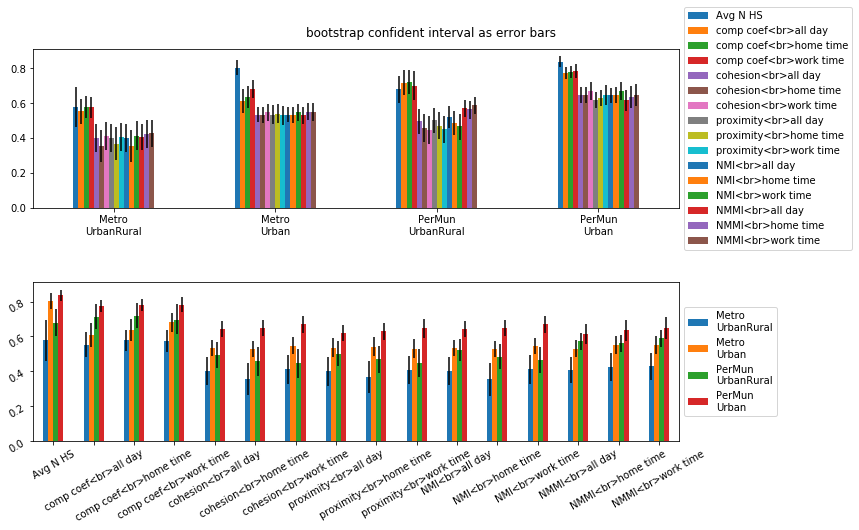

In [251]:
yerr_ci =np.array([pd.DataFrame(df).values.T for df in error_bars.values()])

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2,
                               figsize=(12,8))

avers_plot = pd.DataFrame(avers).T
avers_plot.plot(ax=ax1,kind='bar',yerr=yerr_ci.transpose(1,2,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

avers_plot = pd.DataFrame(avers)
avers_plot.plot(ax=ax2, kind='bar',yerr=yerr_ci.transpose(0,2,1)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('bootstrap confident interval as error bars')
fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

# plt.savefig('figs/methodLevel_SpearmnRho_conf_interval.png', bbox_inches='tight')

## intra-metro measurements

In [27]:
for intra_type in ['hourly','rolling','chunking']:
    for i, hs_stats_geom in enumerate([hs_stats_ageb, hs_stats_g, hs_stats_idw, hs_stats_vor]):
        print(intra_type, i, len(hs_stats_geom))
        for key, hs_stats in hs_stats_geom.items():
            for sun, sun_comp_stats in hs_stats['compactness'].items():
                null_count = pd.DataFrame(sun_comp_stats[intra_type]).isnull().sum().sum()
                if null_count:
                    print(intra_type, key, sun, 'compactness null count', null_count)\

            for sun, sun_nhs_stats in hs_stats['n_hs'].items():
                null_count = sun_nhs_stats[intra_type].isnull().sum()
                if null_count:
                    print(intra_type, key, sun, 'n_hs null count', null_count)

hourly 0 8
hourly 1 8
hourly 2 4
hourly 3 8
rolling 0 8
rolling 1 8
rolling 2 4
rolling 3 8
chunking 0 8
chunking 1 8
chunking 2 4
chunking 3 8


### rearrange measurements

In [596]:
def hourly_measures_per_metro(sun, geom_type, hs_stats, measure_type, idw=False,intra_type='hourly'):
    """
    Measures[measure names (e.g. NMMI)][key_combo (all mun_urb combo, one geom_type, all by)]
    """
    measures = defaultdict(lambda: defaultdict(list))

    for key, stats in hs_stats.items():
        
        if not idw:
            by, per_mun, urb_only = key
        else:
            by = '_idw10'
            per_mun, urb_only = key
        key_combo = (ADMIN_STR(per_mun, urb_only), geom_type, by)
        
        if measure_type in ('n_hs', 'compactness'):
            for hour in hs_stats[key][measure_type][sun][intra_type]:
                for mname, mvalue in hour.items():
                    if mname=='hour':continue
                    measures[mname][key_combo].append(mvalue)
        elif measure_type=='??':
            measures['NHS'][key_combo].extend(hs_stats[key][measure_type][sun][intra_type].tolist())
        else:
            raise ValueError('Not implemented')
    return measures

def hourly_measures_by_mname(geom_type, hs_stats, idws, measure_type, zms, intra_type='hourly'):
    """
    all_suns_measures[measure names (e.g. NMMI)][sun_id][key_combo (all mun_urb combo, all geom_type, all by)]
    """
    print(":func hourly_measures_by_mname", measure_type, intra_type)
    all_suns_measures = defaultdict(lambda : defaultdict(dict))
    for gtype, hstat, idw in zip(geom_type, hs_stats, idws):
        for sun in sorted(zms.index):
            measures = hourly_measures_per_metro(sun, gtype, hstat,measure_type,idw, intra_type)
            for mname, measure in measures.items():
                all_suns_measures[mname][sun].update(measure)
    return all_suns_measures

In [574]:
hs_stats[0][('area', False, False)]['n_hs'][1]['hourly']

[{'hour': '0', 'NHS': 58, 'AHS': 39.87289293876539},
 {'hour': '1', 'NHS': 59, 'AHS': 40.06000717026473},
 {'hour': '2', 'NHS': 49, 'AHS': 32.81786114140564},
 {'hour': '3', 'NHS': 52, 'AHS': 35.800970357807145},
 {'hour': '4', 'NHS': 59, 'AHS': 40.24385684683873},
 {'hour': '5', 'NHS': 59, 'AHS': 42.01031712971407},
 {'hour': '6', 'NHS': 56, 'AHS': 40.467522014352056},
 {'hour': '7', 'NHS': 53, 'AHS': 40.642322710749674},
 {'hour': '8', 'NHS': 54, 'AHS': 40.30915464775173},
 {'hour': '9', 'NHS': 57, 'AHS': 41.67130025105059},
 {'hour': '10', 'NHS': 58, 'AHS': 40.752942857734105},
 {'hour': '11', 'NHS': 57, 'AHS': 39.94643837941189},
 {'hour': '12', 'NHS': 57, 'AHS': 39.17000674476171},
 {'hour': '13', 'NHS': 58, 'AHS': 39.25384452178764},
 {'hour': '14', 'NHS': 57, 'AHS': 39.76481814828568},
 {'hour': '15', 'NHS': 55, 'AHS': 38.59628916961372},
 {'hour': '16', 'NHS': 55, 'AHS': 38.7634429492293},
 {'hour': '17', 'NHS': 59, 'AHS': 41.16131498200538},
 {'hour': '18', 'NHS': 59, 'AHS': 4

In [734]:
# intra_metro_measures[measure names (e.g. NMMI)][sun_id][key_combo (all mun_urb combo, all geom_type, all by)]

intra_type = ['hourly', 'rolling', 'chunking'][0]
intra_metro_measures = {}

for measure_type in ['n_hs', 'compactness']:
    # measure_type = 'n_hs'  # another type is average number of hotspot
    # measure_type = 'compactness'  # all measurements in compactness: comp_coef, cohesion, proximity, NMI, NMMI
    print(measure_type)
    tmp = hourly_measures_by_mname(
        geom_type=['ageb', 'g.5km', 'g.5km', 'vor'],
        hs_stats=[hs_stats_ageb, hs_stats_idw, hs_stats_g, hs_stats_vor],
        idws=[False, True, False, False],
        measure_type=measure_type,
        zms=zms,
        intra_type=intra_type
    )

    intra_metro_measures.update(**tmp)


n_hs
:func hourly_measures_by_mname n_hs hourly
compactness
:func hourly_measures_by_mname compactness hourly


In [735]:
intra_metro_measures_hourly = intra_metro_measures

In [632]:
intra_metro_measures.keys()

dict_keys(['NHS', 'AHS', 'comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'])

In [183]:
for mname, measures in intra_metro_measures.items():
    for sun, sun_measures in measures.items():
        print('='*20,mname, sun)
        null_count = pd.DataFrame(sun_measures).isnull().sum()
        null_count = null_count[null_count!=0]
        if len(null_count): print('has null methods', null_count.index.tolist())
            
        nunique_values = pd.DataFrame(sun_measures).nunique()
        all_the_same = nunique_values[nunique_values==1]
        if len(all_the_same): print('has all_the_same methods',all_the_same.index.tolist())
            
        many_ties = nunique_values[(nunique_values>1) & (nunique_values<=n_bins/2)]
        if len(many_ties): print('has many_ties methods',len(many_ties), many_ties.value_counts().to_dict())


==================== Avg N HS 1
has many_ties methods 20 {6: 16, 5: 3, 4: 1}
==================== Avg N HS 2
has many_ties methods 20 {6: 17, 5: 3}
==================== Avg N HS 3
has many_ties methods 20 {6: 10, 5: 8, 4: 2}
==================== Avg N HS 4
has many_ties methods 20 {6: 18, 5: 2}
==================== Avg N HS 5
has many_ties methods 20 {6: 20}
==================== Avg N HS 6
has many_ties methods 20 {6: 18, 5: 2}
==================== Avg N HS 7
has many_ties methods 20 {6: 12, 5: 8}
==================== Avg N HS 8
has many_ties methods 20 {5: 9, 6: 8, 4: 3}
==================== Avg N HS 9
has all_the_same methods [('Metro_Urban', 'ageb', 'area'), ('PerMun_Urban', 'ageb', 'area')]
has many_ties methods 18 {6: 9, 5: 6, 3: 2, 4: 1}
==================== Avg N HS 10
has many_ties methods 20 {6: 20}
==================== Avg N HS 11
has many_ties methods 20 {6: 20}
==================== Avg N HS 12
has many_ties methods 20 {6: 18, 5: 2}
==================== Avg N HS 13
has many_

has many_ties methods 20 {6: 16, 5: 4}
==================== comp_coef 51
has many_ties methods 20 {6: 16, 5: 4}
==================== comp_coef 52
has many_ties methods 20 {6: 19, 5: 1}
==================== comp_coef 53
has many_ties methods 20 {6: 14, 5: 4, 4: 1, 2: 1}
==================== comp_coef 54
has all_the_same methods [('Metro_UrbanRural', 'ageb', 'area'), ('Metro_Urban', 'ageb', 'area'), ('PerMun_Urban', 'ageb', 'area'), ('Metro_UrbanRural', 'ageb', 'pop'), ('Metro_Urban', 'ageb', 'pop'), ('Metro_Urban', 'g.5km', '_idw10'), ('Metro_Urban', 'g.5km', 'area'), ('Metro_Urban', 'g.5km', 'pop')]
has many_ties methods 12 {2: 5, 3: 4, 6: 1, 5: 1, 4: 1}
==================== comp_coef 55
has many_ties methods 20 {6: 20}
==================== comp_coef 56
has many_ties methods 20 {6: 18, 5: 2}
==================== comp_coef 57
has many_ties methods 20 {6: 20}
==================== comp_coef 58
has all_the_same methods [('PerMun_Urban', 'ageb', 'area'), ('Metro_UrbanRural', 'g.5km', '_idw1

has many_ties methods 20 {6: 19, 5: 1}
==================== proximity 33
has many_ties methods 20 {6: 14, 5: 2, 4: 2, 3: 2}
==================== proximity 34
has many_ties methods 20 {6: 20}
==================== proximity 35
has many_ties methods 20 {6: 13, 5: 5, 4: 2}
==================== proximity 36
has many_ties methods 20 {6: 20}
==================== proximity 37
has many_ties methods 20 {6: 20}
==================== proximity 38
has many_ties methods 20 {6: 20}
==================== proximity 39
has many_ties methods 20 {6: 11, 4: 3, 2: 3, 5: 2, 3: 1}
==================== proximity 40
has many_ties methods 20 {6: 16, 5: 3, 4: 1}
==================== proximity 41
has many_ties methods 20 {6: 18, 4: 2}
==================== proximity 42
has many_ties methods 20 {6: 18, 5: 2}
==================== proximity 43
has many_ties methods 20 {6: 19, 5: 1}
==================== proximity 44
has many_ties methods 20 {6: 20}
==================== proximity 45
has many_ties methods 20 {6: 20}
======

has many_ties methods 20 {6: 20}
==================== NMMI 25
has many_ties methods 20 {6: 20}
==================== NMMI 26
has many_ties methods 20 {6: 20}
==================== NMMI 27
has many_ties methods 20 {6: 20}
==================== NMMI 28
has many_ties methods 20 {6: 20}
==================== NMMI 29
has many_ties methods 20 {6: 20}
==================== NMMI 30
has many_ties methods 20 {6: 20}
==================== NMMI 31
has many_ties methods 20 {6: 20}
==================== NMMI 32
has many_ties methods 20 {6: 20}
==================== NMMI 33
has many_ties methods 20 {6: 20}
==================== NMMI 34
has many_ties methods 20 {6: 20}
==================== NMMI 35
has many_ties methods 20 {6: 20}
==================== NMMI 36
has many_ties methods 20 {6: 20}
==================== NMMI 37
has many_ties methods 20 {6: 20}
==================== NMMI 38
has many_ties methods 20 {6: 20}
==================== NMMI 39
has many_ties methods 20 {6: 20}
==================== NMMI 40
has many

If there is universal pattern across all city-temporal-level comparison

### get S Rho and Jaccard values

In [475]:

def top_k_in_arr(arr, k, descending=True):
    assert isinstance(arr, np.ndarray)
    if descending:
        thres_included = np.sort(arr)[::-1][k-1]
        return np.where(arr>=thres_included)[0]
    else:
        thres_included = np.sort(arr)[k-1]
        return np.where(arr<=thres_included)[0]
    
def jaccard_among_method_pairs(methods_output, k, descending=True, include_ties=True, verbose=0):
    assert descending in (True, False)
    n_methods = methods_output.shape[1]
    jaccard_mat = np.ones((n_methods, n_methods))
    if include_ties:
        top_k_hours = methods_output.T.apply(lambda x: set(top_k_in_arr(x.values, k, descending)), axis=1)
    else: 
        top_k_hours = methods_output.T.apply(lambda x: set(np.argsort(x)[::(-1 if descending else 1)][:k]), axis=1)
    if verbose: print(top_k_hours)
    top_k_hours = top_k_hours.tolist()
    for i in range(n_methods):
        for j in range(i+1, n_methods):
            seti = top_k_hours[i]
            setj = top_k_hours[j]
            jaccard_mat[i,j] = jaccard_mat[j,i] = len(seti & setj) / len(seti | setj)
    
    jaccard_mat = pd.DataFrame(jaccard_mat,
                          index=methods_output.columns,
                          columns=methods_output.columns)
    return jaccard_mat
    

def get_jaccard_per_astr(astr, intra_metro_measures, k, include_ties=True, verbose=0):
    # intra_metro_measures = [mname][sun][(astr, geom_type, by)] = n-hour-bin vector
    jaccard_per_astr = defaultdict(dict)
    print('='*20, astr)
    for mname, one_measure_all_suns in intra_metro_measures.items():
        print(mname, end=' ')
        descending = False if mname=='comp_coef' else True
        for sun, measure in one_measure_all_suns.items():
            methods_output = pd.DataFrame(measure)[astr]
            jaccard_mat = jaccard_among_method_pairs(methods_output, k, descending, include_ties, verbose)
            jaccard_per_astr[mname][sun] = jaccard_mat
        print()
    #     break
    return jaccard_per_astr


In [310]:
top_k = 3
print(intra_type)
jacc_4_astr_rolling = [get_jaccard_per_astr(astr, intra_metro_measures_rolling, top_k) for astr in admin_strs]

rolling
==================== Metro_UrbanRural
Avg N HS 
comp_coef 
cohesion 
proximity 
NMI 
NMMI 
==================== Metro_Urban
Avg N HS 
comp_coef 
cohesion 
proximity 
NMI 
NMMI 
==================== PerMun_UrbanRural
Avg N HS 
comp_coef 
cohesion 
proximity 
NMI 
NMMI 
==================== PerMun_Urban
Avg N HS 
comp_coef 
cohesion 
proximity 
NMI 
NMMI 


In [36]:
# srhos is run on each mun_urb combo and each measurement
def get_srhos_per_astr(astr, intra_metro_measures):
    # intra_metro_measures = [mname][sun][(astr, geom_type, by)] = n-hour-bin vector
    srhos_per_astr = defaultdict(dict)
    print(astr)
    for mname, one_measure_all_suns in intra_metro_measures.items():
        print(mname, end=' ')
        for sun, measure in one_measure_all_suns.items():
            # TODO: kendall is ill defined when a vector has no ranking (all elements are the same), e.g. sun==9
            # if sun!=9:continue
            # print(sun)

            # extract measure for one mun_urb combo represented as astr
            _, rho = spe_rho_corr(pd.DataFrame(measure)[astr], clean_table=False,larger_than=.0)
            if rho.isnull().values.sum()!=0:
                # 'has ill defined vectors for correlation'
                print(sun, end=' ')
#                 continue
            srhos_per_astr[mname][sun] = rho
        print(len(srhos_per_astr[mname]))
    #     break
    return srhos_per_astr

In [737]:
srhos_4_astr_hourly = [get_srhos_per_astr(astr, intra_metro_measures_hourly) for astr in admin_strs]

Metro_UR
NHS 

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

invalid value encountered in less_equal



9 16 29 33 39 54 58 59 59
AHS 9 16 29 39 54 58 59 59
comp_coef 9 16 29 39 54 58 59 59
cohesion 9 16 29 39 54 58 59 59
proximity 9 16 29 39 54 58 59 59
NMI 9 16 29 39 54 58 59 59
NMMI 59
mass_comp_coef 9 16 29 39 54 58 59 59
Metro_U
NHS 9 15 16 19 23 29 39 54 58 59 59
AHS 9 15 16 19 23 29 39 54 58 59 59
comp_coef 9 15 16 19 23 29 39 54 58 59 59
cohesion 9 15 16 19 23 29 39 54 58 59 59
proximity 9 15 16 19 23 29 39 54 58 59 59
NMI 9 15 16 19 23 29 39 54 58 59 59
NMMI 59
mass_comp_coef 9 15 16 19 23 29 39 54 58 59 59
PerMuni_UR
NHS 9 23 33 51 54 58 59 59
AHS 9 23 54 58 59 59
comp_coef 9 16 23 54 58 59 59
cohesion 9 16 23 54 58 59 59
proximity 9 16 23 54 58 59 59
NMI 9 16 23 54 58 59 59
NMMI 59
mass_comp_coef 9 23 54 58 59 59
PerMuni_U
NHS 9 15 16 19 20 23 39 40 54 58 59 59
AHS 9 15 16 19 20 23 39 40 54 58 59 59
comp_coef 9 15 16 19 20 23 39 40 54 58 59 59
cohesion 9 15 16 19 20 23 39 40 54 58 59 59
proximity 9 15 16 19 20 23 39 40 54 58 59 59
NMI 9 15 16 19 20 23 39 40 54 58 59 59
NMMI 59

### Metric level analysis

In [40]:
def stats_of_srhos_for_one_measure(srhos, mname, add_mean=False, aver_first=True):
    n=srhos[1].shape[0]
    mean_res = np.ones((n,n), dtype=object)
    for i in range(n):
        for j in range(i+1, n):
            arr = np.array([tmp_srho.iloc[i,j] for tmp_srho in srhos.values() if not pd.isnull(tmp_srho.iloc[i,j])])
#             print(len(arr))
            bres = bs.bootstrap(arr, stat_func=bs_stats.mean)
            l_diff = f'{(bres.lower_bound-bres.value):.3f}'
            u_diff = f'{(bres.upper_bound-bres.value):.3f}'
            str_median_quantile = f'{np.median(arr):.3f} <br/>({np.percentile(arr,25):.3f}~{np.percentile(arr,75):.3f})'
            str_mean_std = f'{bres.value:.3f} ({arr.std():.3f})'
            str_conf_inter = f'({bres.lower_bound:.3f}~{bres.upper_bound:.3f})<br/>({l_diff}~{u_diff})'
            str_min_max = f'[{arr.min():.3f}, {arr.max():.3f}]'
            if aver_first:
                mean_res[i,j] = mean_res[j,i] = f'{str_mean_std}<br/>{str_conf_inter}<br/>{str_median_quantile}<br/>{str_min_max}'
            else: 
                mean_res[i,j] = mean_res[j,i] = f'{str_median_quantile}<br/>{str_min_max}<br/>{str_mean_std}<br/>{str_conf_inter}'
                
    #         print(bres.value,arr.std(),i,j)
    #         pd.Series(arr).hist()
    #         plt.show()
    #         break
    #     break
    mean_res = pd.DataFrame(mean_res,index=srhos[1].index, columns=srhos[1].columns)

    mean_res.columns =['<br/>'.join(col).strip() for col in mean_res.columns.values]
    mean_res.index =['<br/>'.join(col).strip() for col in mean_res.index.values]
    mean_res.index.name=mname
    if add_mean:
        mean_res['row<br/>mean'] = (mean_res.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mean_res['row<br/>mean'] = mean_res['row<br/>mean'].apply(lambda x: f'{x:.03f}')
    return mean_res


#### individual arrays and matrix

In [123]:
from scipy.stats import rankdata

In [157]:
sun = 28
grad_bg(srhos_4_astr[0]['Avg N HS'][sun], mini=0, maxi=1, mask_tril=True)

In [155]:

grad_bg(jacc_4_astr[3]['Avg N HS'][sun], mini=0, maxi=1, mask_tril=True)

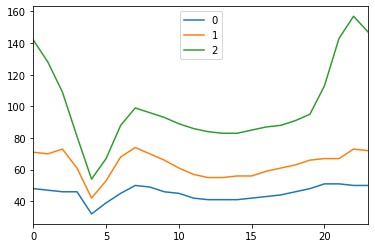

In [127]:
pd.DataFrame([
    hs_stats_ageb[('area',False, False)]['n_hs'][sun]['hourly'], 
    hs_stats_ageb[('pop',False, False)]['n_hs'][sun]['hourly'],
    hs_stats_g[('pop',False, False)]['n_hs'][sun]['hourly'],
]).T.plot()

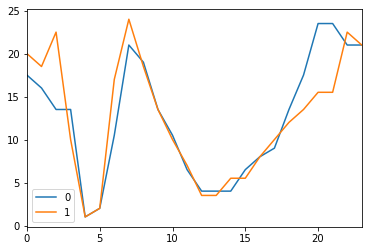

In [128]:
pd.DataFrame([
    rankdata(hs_stats_ageb[('area',False, False)]['n_hs'][sun]['hourly']), 
    rankdata(hs_stats_ageb[('pop',False, False)]['n_hs'][sun]['hourly']),
]).T.plot()

#### result table

In [354]:
i = 3
astr = admin_strs[i]
srhos_per_astr = srhos_4_astr_chunking[i]
aver_first = True
# print(intra_type)
print(astr.replace('_','\n'))
print('color by average' if aver_first else 'color by median')

for mname, srhos in srhos_per_astr.items():
    mean_res = stats_of_srhos_for_one_measure(srhos_per_astr[mname], mname, add_mean=True, aver_first=aver_first)
    display(grad_bg_with_str(mean_res, 0, 1, mask_tril=True))

PerMun
Urban
color by average


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
Avg N HS,,,,,,,,
agebarea,1,"0.577 (0.367)(0.483~0.676)(-0.094~0.099)0.800 (0.218~0.800)[0.000, 1.000]","0.238 (0.317)(0.153~0.318)(-0.086~0.079)0.000 (0.000~0.400)[0.000, 1.000]","0.537 (0.400)(0.433~0.643)(-0.104~0.106)0.632 (0.000~0.922)[0.000, 1.000]","0.460 (0.364)(0.365~0.557)(-0.095~0.097)0.400 (0.053~0.800)[0.000, 1.000]","0.350 (0.361)(0.248~0.447)(-0.102~0.097)0.316 (0.000~0.738)[0.000, 1.000]","0.304 (0.345)(0.208~0.397)(-0.096~0.094)0.105 (0.000~0.588)[0.000, 1.000]",0.411
agebpop,,1,"0.254 (0.345)(0.162~0.341)(-0.092~0.087)0.000 (0.000~0.400)[0.000, 1.000]","0.545 (0.391)(0.446~0.645)(-0.098~0.100)0.775 (0.153~0.874)[0.000, 1.000]","0.591 (0.346)(0.503~0.682)(-0.088~0.091)0.632 (0.400~0.874)[0.000, 1.000]","0.332 (0.381)(0.224~0.437)(-0.108~0.105)0.200 (0.000~0.775)[0.000, 1.000]","0.317 (0.384)(0.208~0.420)(-0.109~0.103)0.105 (0.000~0.716)[0.000, 1.000]",0.436
g.5km_idw10,,,1,"0.277 (0.356)(0.185~0.366)(-0.092~0.089)0.000 (0.000~0.600)[0.000, 1.000]","0.268 (0.352)(0.177~0.355)(-0.091~0.087)0.000 (0.000~0.550)[0.000, 1.000]","0.320 (0.364)(0.218~0.421)(-0.103~0.100)0.000 (0.000~0.632)[0.000, 1.000]","0.374 (0.385)(0.266~0.476)(-0.108~0.102)0.316 (0.000~0.769)[0.000, 1.000]",0.288
g.5kmarea,,,,1,"0.652 (0.406)(0.552~0.759)(-0.100~0.107)0.800 (0.205~1.000)[0.000, 1.000]","0.349 (0.401)(0.235~0.458)(-0.114~0.109)0.105 (0.000~0.800)[0.000, 1.000]","0.323 (0.395)(0.214~0.428)(-0.109~0.105)0.000 (0.000~0.787)[0.000, 1.000]",0.447
g.5kmpop,,,,,1,"0.334 (0.377)(0.227~0.435)(-0.106~0.102)0.200 (0.000~0.775)[0.000, 1.000]","0.351 (0.402)(0.238~0.458)(-0.113~0.108)0.105 (0.000~0.800)[0.000, 1.000]",0.443
vorarea,,,,,,1,"0.690 (0.398)(0.582~0.805)(-0.108~0.115)0.949 (0.371~1.000)[0.000, 1.000]",0.396
vorpop,,,,,,,1,0.393


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp_coef,,,,,,,,
agebarea,1,"0.439 (0.363)(0.343~0.534)(-0.096~0.095)0.400 (0.000~0.800)[0.000, 1.000]","0.400 (0.348)(0.306~0.492)(-0.095~0.092)0.400 (0.000~0.800)[0.000, 1.000]","0.426 (0.384)(0.323~0.527)(-0.103~0.101)0.400 (0.000~0.800)[0.000, 1.000]","0.424 (0.366)(0.324~0.520)(-0.100~0.096)0.400 (0.000~0.800)[0.000, 1.000]","0.315 (0.396)(0.198~0.421)(-0.117~0.106)0.000 (0.000~0.800)[0.000, 1.000]","0.460 (0.374)(0.359~0.560)(-0.101~0.100)0.400 (0.000~0.800)[0.000, 1.000]",0.411
agebpop,,1,"0.342 (0.343)(0.251~0.429)(-0.091~0.087)0.200 (0.000~0.632)[0.000, 1.000]","0.340 (0.356)(0.244~0.428)(-0.096~0.089)0.229 (0.000~0.750)[0.000, 1.000]","0.468 (0.353)(0.379~0.561)(-0.089~0.092)0.400 (0.000~0.800)[0.000, 1.000]","0.426 (0.349)(0.328~0.523)(-0.098~0.097)0.400 (0.000~0.800)[0.000, 1.000]","0.332 (0.350)(0.235~0.425)(-0.096~0.093)0.316 (0.000~0.632)[0.000, 1.000]",0.391
g.5km_idw10,,,1,"0.370 (0.379)(0.273~0.465)(-0.097~0.094)0.400 (0.000~0.800)[0.000, 1.000]","0.392 (0.373)(0.299~0.487)(-0.093~0.095)0.400 (0.000~0.800)[0.000, 1.000]","0.414 (0.350)(0.314~0.513)(-0.100~0.099)0.400 (0.000~0.775)[0.000, 1.000]","0.490 (0.364)(0.391~0.590)(-0.099~0.100)0.400 (0.100~0.800)[0.000, 1.000]",0.401
g.5kmarea,,,,1,"0.496 (0.366)(0.402~0.589)(-0.094~0.093)0.400 (0.200~0.800)[0.000, 1.000]","0.343 (0.382)(0.233~0.449)(-0.110~0.106)0.200 (0.000~0.800)[0.000, 1.000]","0.404 (0.387)(0.296~0.510)(-0.108~0.106)0.400 (0.000~0.800)[0.000, 1.000]",0.397
g.5kmpop,,,,,1,"0.356 (0.350)(0.255~0.454)(-0.101~0.098)0.287 (0.000~0.632)[0.000, 1.000]","0.393 (0.386)(0.287~0.498)(-0.106~0.105)0.316 (0.000~0.800)[0.000, 1.000]",0.421
vorarea,,,,,,1,"0.544 (0.387)(0.432~0.656)(-0.111~0.113)0.632 (0.200~0.800)[0.000, 1.000]",0.400
vorpop,,,,,,,1,0.437


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesion,,,,,,,,
agebarea,1,"0.460 (0.353)(0.366~0.556)(-0.094~0.096)0.400 (0.026~0.800)[0.000, 1.000]","0.397 (0.358)(0.300~0.494)(-0.097~0.097)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.363)(0.381~0.573)(-0.097~0.096)0.600 (0.000~0.800)[0.000, 1.000]","0.491 (0.365)(0.395~0.589)(-0.097~0.098)0.500 (0.050~0.800)[0.000, 1.000]","0.389 (0.379)(0.279~0.496)(-0.110~0.107)0.316 (0.000~0.800)[0.000, 1.000]","0.410 (0.370)(0.307~0.513)(-0.103~0.103)0.400 (0.000~0.800)[0.000, 1.000]",0.438
agebpop,,1,"0.472 (0.372)(0.374~0.569)(-0.098~0.096)0.400 (0.056~0.800)[0.000, 1.000]","0.456 (0.382)(0.357~0.553)(-0.098~0.097)0.400 (0.000~0.800)[0.000, 1.000]","0.560 (0.358)(0.470~0.654)(-0.090~0.094)0.787 (0.233~0.800)[0.000, 1.000]","0.453 (0.375)(0.346~0.559)(-0.107~0.106)0.400 (0.000~0.800)[0.000, 1.000]","0.386 (0.372)(0.283~0.487)(-0.103~0.101)0.316 (0.000~0.800)[0.000, 1.000]",0.464
g.5km_idw10,,,1,"0.490 (0.398)(0.389~0.590)(-0.101~0.100)0.472 (0.000~0.800)[0.000, 1.000]","0.510 (0.375)(0.413~0.607)(-0.097~0.097)0.600 (0.050~0.800)[0.000, 1.000]","0.526 (0.384)(0.415~0.635)(-0.111~0.109)0.400 (0.129~0.874)[0.000, 1.000]","0.439 (0.407)(0.326~0.551)(-0.112~0.112)0.400 (0.000~0.874)[0.000, 1.000]",0.472
g.5kmarea,,,,1,"0.581 (0.399)(0.482~0.685)(-0.099~0.104)0.800 (0.200~1.000)[0.000, 1.000]","0.442 (0.403)(0.324~0.557)(-0.117~0.115)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.383)(0.372~0.583)(-0.105~0.106)0.400 (0.000~0.800)[0.000, 1.000]",0.487
g.5kmpop,,,,,1,"0.531 (0.388)(0.422~0.641)(-0.109~0.111)0.632 (0.150~0.837)[0.000, 1.000]","0.449 (0.378)(0.346~0.551)(-0.103~0.101)0.400 (0.000~0.800)[0.000, 1.000]",0.520
vorarea,,,,,,1,"0.426 (0.407)(0.306~0.542)(-0.120~0.116)0.400 (0.000~0.800)[0.000, 1.000]",0.461
vorpop,,,,,,,1,0.431


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximity,,,,,,,,
agebarea,1,"0.484 (0.346)(0.393~0.574)(-0.091~0.091)0.400 (0.200~0.800)[0.000, 1.000]","0.423 (0.349)(0.329~0.516)(-0.094~0.093)0.400 (0.000~0.800)[0.000, 1.000]","0.426 (0.363)(0.328~0.523)(-0.098~0.097)0.400 (0.000~0.800)[0.000, 1.000]","0.524 (0.353)(0.430~0.619)(-0.095~0.095)0.600 (0.200~0.800)[0.000, 1.000]","0.396 (0.376)(0.284~0.501)(-0.111~0.106)0.316 (0.000~0.800)[0.000, 1.000]","0.362 (0.367)(0.260~0.461)(-0.102~0.099)0.316 (0.000~0.800)[0.000, 1.000]",0.436
agebpop,,1,"0.482 (0.358)(0.388~0.576)(-0.094~0.095)0.400 (0.200~0.800)[0.000, 1.000]","0.458 (0.376)(0.364~0.556)(-0.094~0.098)0.400 (0.000~0.800)[0.000, 1.000]","0.535 (0.368)(0.440~0.630)(-0.094~0.095)0.600 (0.200~0.800)[0.000, 1.000]","0.449 (0.361)(0.343~0.549)(-0.107~0.100)0.400 (0.000~0.800)[0.000, 1.000]","0.365 (0.342)(0.271~0.459)(-0.094~0.093)0.316 (0.000~0.632)[0.000, 1.000]",0.462
g.5km_idw10,,,1,"0.466 (0.387)(0.367~0.567)(-0.099~0.101)0.400 (0.000~0.800)[0.000, 1.000]","0.517 (0.364)(0.424~0.611)(-0.093~0.094)0.600 (0.200~0.800)[0.000, 1.000]","0.477 (0.384)(0.369~0.585)(-0.108~0.108)0.400 (0.000~0.800)[0.000, 1.000]","0.468 (0.384)(0.361~0.572)(-0.107~0.104)0.400 (0.000~0.800)[0.000, 1.000]",0.472
g.5kmarea,,,,1,"0.547 (0.385)(0.451~0.647)(-0.097~0.099)0.800 (0.200~0.800)[0.000, 1.000]","0.421 (0.392)(0.309~0.533)(-0.113~0.112)0.400 (0.000~0.800)[0.000, 1.000]","0.437 (0.385)(0.332~0.544)(-0.106~0.106)0.400 (0.000~0.800)[0.000, 1.000]",0.459
g.5kmpop,,,,,1,"0.530 (0.366)(0.428~0.633)(-0.102~0.103)0.616 (0.200~0.800)[0.000, 1.000]","0.454 (0.374)(0.353~0.555)(-0.101~0.101)0.400 (0.000~0.800)[0.000, 1.000]",0.518
vorarea,,,,,,1,"0.422 (0.368)(0.313~0.528)(-0.109~0.106)0.400 (0.000~0.800)[0.000, 1.000]",0.449
vorpop,,,,,,,1,0.418


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMI,,,,,,,,
agebarea,1,"0.460 (0.353)(0.368~0.554)(-0.092~0.094)0.400 (0.026~0.800)[0.000, 1.000]","0.397 (0.358)(0.301~0.494)(-0.096~0.097)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.363)(0.379~0.575)(-0.099~0.097)0.600 (0.000~0.800)[0.000, 1.000]","0.491 (0.365)(0.396~0.588)(-0.095~0.097)0.500 (0.050~0.800)[0.000, 1.000]","0.389 (0.379)(0.282~0.494)(-0.107~0.105)0.316 (0.000~0.800)[0.000, 1.000]","0.410 (0.370)(0.308~0.512)(-0.102~0.102)0.400 (0.000~0.800)[0.000, 1.000]",0.438
agebpop,,1,"0.472 (0.372)(0.376~0.569)(-0.097~0.097)0.400 (0.056~0.800)[0.000, 1.000]","0.456 (0.382)(0.356~0.554)(-0.100~0.098)0.400 (0.000~0.800)[0.000, 1.000]","0.560 (0.358)(0.470~0.654)(-0.090~0.093)0.787 (0.233~0.800)[0.000, 1.000]","0.453 (0.375)(0.346~0.559)(-0.107~0.106)0.400 (0.000~0.800)[0.000, 1.000]","0.386 (0.372)(0.284~0.489)(-0.102~0.103)0.316 (0.000~0.800)[0.000, 1.000]",0.464
g.5km_idw10,,,1,"0.490 (0.398)(0.387~0.591)(-0.103~0.101)0.472 (0.000~0.800)[0.000, 1.000]","0.510 (0.375)(0.413~0.607)(-0.097~0.097)0.600 (0.050~0.800)[0.000, 1.000]","0.526 (0.384)(0.416~0.635)(-0.110~0.109)0.400 (0.129~0.874)[0.000, 1.000]","0.439 (0.407)(0.328~0.550)(-0.110~0.111)0.400 (0.000~0.874)[0.000, 1.000]",0.472
g.5kmarea,,,,1,"0.581 (0.399)(0.482~0.684)(-0.099~0.103)0.800 (0.200~1.000)[0.000, 1.000]","0.442 (0.403)(0.330~0.556)(-0.112~0.114)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.383)(0.373~0.582)(-0.105~0.104)0.400 (0.000~0.800)[0.000, 1.000]",0.487
g.5kmpop,,,,,1,"0.531 (0.388)(0.421~0.641)(-0.110~0.111)0.632 (0.150~0.837)[0.000, 1.000]","0.449 (0.378)(0.347~0.552)(-0.102~0.103)0.400 (0.000~0.800)[0.000, 1.000]",0.520
vorarea,,,,,,1,"0.426 (0.407)(0.307~0.543)(-0.119~0.117)0.400 (0.000~0.800)[0.000, 1.000]",0.461
vorpop,,,,,,,1,0.431


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMI,,,,,,,,
agebarea,1,"0.586 (0.361)(0.498~0.681)(-0.088~0.095)0.800 (0.300~0.800)[0.000, 1.000]","0.478 (0.388)(0.380~0.576)(-0.098~0.098)0.400 (0.000~0.800)[0.000, 1.000]","0.586 (0.361)(0.498~0.681)(-0.088~0.095)0.800 (0.300~0.900)[0.000, 1.000]","0.546 (0.364)(0.454~0.637)(-0.092~0.092)0.800 (0.200~0.800)[0.000, 1.000]","0.576 (0.374)(0.485~0.675)(-0.092~0.098)0.800 (0.200~1.000)[0.000, 1.000]","0.512 (0.365)(0.420~0.603)(-0.092~0.092)0.400 (0.200~0.800)[0.000, 1.000]",0.547
agebpop,,1,"0.542 (0.357)(0.451~0.634)(-0.092~0.092)0.600 (0.300~0.800)[0.000, 1.000]","0.488 (0.356)(0.400~0.576)(-0.088~0.088)0.400 (0.200~0.800)[0.000, 1.000]","0.590 (0.322)(0.508~0.671)(-0.081~0.081)0.800 (0.400~0.800)[0.000, 1.000]","0.536 (0.401)(0.434~0.637)(-0.102~0.102)0.600 (0.000~0.900)[0.000, 1.000]","0.478 (0.410)(0.376~0.583)(-0.102~0.105)0.400 (0.000~0.800)[0.000, 1.000]",0.537
g.5km_idw10,,,1,"0.444 (0.381)(0.346~0.542)(-0.098~0.098)0.400 (0.000~0.800)[0.000, 1.000]","0.508 (0.406)(0.403~0.614)(-0.105~0.105)0.600 (0.000~0.800)[0.000, 1.000]","0.464 (0.404)(0.363~0.569)(-0.102~0.105)0.400 (0.000~0.800)[0.000, 1.000]","0.441 (0.388)(0.342~0.539)(-0.098~0.098)0.400 (0.000~0.800)[0.000, 1.000]",0.479
g.5kmarea,,,,1,"0.532 (0.369)(0.441~0.627)(-0.092~0.095)0.400 (0.200~0.800)[0.000, 1.000]","0.492 (0.394)(0.393~0.590)(-0.098~0.098)0.600 (0.000~0.800)[0.000, 1.000]","0.481 (0.376)(0.386~0.576)(-0.095~0.095)0.400 (0.000~0.800)[0.000, 1.000]",0.504
g.5kmpop,,,,,1,"0.525 (0.386)(0.431~0.627)(-0.095~0.102)0.600 (0.100~0.800)[0.000, 1.000]","0.536 (0.332)(0.451~0.620)(-0.085~0.085)0.400 (0.300~0.800)[0.000, 1.000]",0.539
vorarea,,,,,,1,"0.573 (0.390)(0.478~0.671)(-0.095~0.098)0.800 (0.300~1.000)[0.000, 1.000]",0.528
vorpop,,,,,,,1,0.503


In [42]:
i = 3
astr = admin_strs[i]
srhos_per_astr = srhos_4_astr_hourly[i]
aver_first = True
print(intra_type)
print(astr.replace('_','\n'))
print('color by average' if aver_first else 'color by median')

for mname, srhos in srhos_per_astr.items():
    mean_res = stats_of_srhos_for_one_measure(srhos_per_astr[mname], mname, add_mean=True, aver_first=aver_first)
    display(grad_bg_with_str(mean_res, 0, 1, mask_tril=True))

hourly
PerMun
Urban
color by average


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
Avg N HS,,,,,,,,
agebarea,1,"0.494 (0.332)(0.407~0.581)(-0.087~0.088)0.550 (0.197~0.817)[0.000, 0.943]","0.175 (0.250)(0.107~0.237)(-0.069~0.062)0.000 (0.000~0.241)[0.000, 0.894]","0.475 (0.374)(0.376~0.574)(-0.099~0.099)0.581 (0.000~0.814)[0.000, 0.991]","0.444 (0.368)(0.347~0.543)(-0.097~0.099)0.545 (0.000~0.785)[0.000, 0.978]","0.290 (0.306)(0.203~0.376)(-0.087~0.086)0.200 (0.000~0.566)[0.000, 0.947]","0.202 (0.246)(0.133~0.268)(-0.070~0.065)0.072 (0.000~0.351)[0.000, 0.910]",0.347
agebpop,,1,"0.197 (0.248)(0.132~0.260)(-0.065~0.063)0.038 (0.000~0.422)[0.000, 0.805]","0.516 (0.349)(0.428~0.606)(-0.088~0.090)0.629 (0.156~0.848)[0.000, 0.978]","0.599 (0.324)(0.517~0.684)(-0.082~0.086)0.746 (0.354~0.876)[0.000, 0.970]","0.259 (0.322)(0.167~0.346)(-0.092~0.087)0.079 (0.000~0.535)[0.000, 0.895]","0.220 (0.298)(0.135~0.297)(-0.084~0.078)0.073 (0.000~0.332)[0.000, 0.899]",0.381
g.5km_idw10,,,1,"0.212 (0.290)(0.135~0.283)(-0.077~0.071)0.000 (0.000~0.437)[0.000, 0.884]","0.239 (0.304)(0.159~0.315)(-0.080~0.076)0.042 (0.000~0.478)[0.000, 0.967]","0.237 (0.297)(0.150~0.319)(-0.087~0.082)0.049 (0.000~0.446)[0.000, 0.866]","0.286 (0.317)(0.196~0.369)(-0.090~0.083)0.171 (0.000~0.500)[0.000, 0.912]",0.224
g.5kmarea,,,,1,"0.639 (0.370)(0.548~0.736)(-0.091~0.097)0.809 (0.397~0.938)[0.000, 0.995]","0.314 (0.341)(0.219~0.409)(-0.096~0.094)0.170 (0.000~0.661)[0.000, 0.957]","0.229 (0.301)(0.143~0.309)(-0.086~0.080)0.000 (0.000~0.444)[0.000, 0.899]",0.398
g.5kmpop,,,,,1,"0.289 (0.347)(0.190~0.386)(-0.100~0.097)0.024 (0.000~0.647)[0.000, 0.972]","0.268 (0.335)(0.173~0.357)(-0.094~0.089)0.022 (0.000~0.588)[0.000, 0.952]",0.413
vorarea,,,,,,1,"0.603 (0.358)(0.506~0.706)(-0.097~0.104)0.782 (0.329~0.903)[0.000, 0.983]",0.332
vorpop,,,,,,,1,0.301


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp_coef,,,,,,,,
agebarea,1,"0.361 (0.321)(0.276~0.444)(-0.085~0.083)0.279 (0.000~0.656)[0.000, 0.890]","0.294 (0.334)(0.206~0.379)(-0.088~0.085)0.108 (0.000~0.650)[0.000, 0.955]","0.336 (0.332)(0.249~0.419)(-0.087~0.083)0.255 (0.000~0.644)[0.000, 0.902]","0.349 (0.312)(0.265~0.430)(-0.085~0.081)0.321 (0.007~0.628)[0.000, 0.923]","0.278 (0.294)(0.196~0.357)(-0.082~0.078)0.143 (0.000~0.537)[0.000, 0.890]","0.241 (0.281)(0.164~0.316)(-0.077~0.075)0.098 (0.000~0.474)[0.000, 0.853]",0.310
agebpop,,1,"0.348 (0.304)(0.268~0.426)(-0.080~0.078)0.344 (0.000~0.555)[0.000, 0.918]","0.340 (0.337)(0.253~0.425)(-0.087~0.084)0.247 (0.000~0.604)[0.000, 0.933]","0.489 (0.340)(0.402~0.577)(-0.087~0.088)0.548 (0.138~0.785)[0.000, 0.957]","0.275 (0.282)(0.198~0.349)(-0.077~0.075)0.199 (0.000~0.506)[0.000, 0.957]","0.280 (0.252)(0.211~0.348)(-0.069~0.068)0.259 (0.000~0.506)[0.000, 0.798]",0.349
g.5km_idw10,,,1,"0.235 (0.295)(0.156~0.308)(-0.079~0.073)0.071 (0.000~0.445)[0.000, 0.948]","0.297 (0.334)(0.210~0.382)(-0.088~0.085)0.147 (0.000~0.617)[0.000, 0.931]","0.346 (0.329)(0.254~0.436)(-0.091~0.091)0.257 (0.000~0.693)[0.000, 0.936]","0.362 (0.334)(0.269~0.452)(-0.092~0.090)0.384 (0.000~0.666)[0.000, 0.913]",0.314
g.5kmarea,,,,1,"0.506 (0.322)(0.426~0.588)(-0.080~0.082)0.531 (0.294~0.781)[0.000, 0.972]","0.249 (0.292)(0.165~0.325)(-0.083~0.077)0.128 (0.000~0.503)[0.000, 0.896]","0.222 (0.267)(0.147~0.293)(-0.075~0.071)0.021 (0.000~0.406)[0.000, 0.851]",0.315
g.5kmpop,,,,,1,"0.277 (0.276)(0.199~0.351)(-0.078~0.074)0.220 (0.000~0.533)[0.000, 0.903]","0.278 (0.270)(0.203~0.349)(-0.076~0.071)0.252 (0.000~0.477)[0.000, 0.866]",0.366
vorarea,,,,,,1,"0.496 (0.327)(0.407~0.587)(-0.090~0.091)0.557 (0.197~0.785)[0.000, 0.967]",0.320
vorpop,,,,,,,1,0.313


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesion,,,,,,,,
agebarea,1,"0.370 (0.274)(0.297~0.441)(-0.073~0.071)0.379 (0.089~0.587)[0.000, 0.944]","0.193 (0.292)(0.115~0.265)(-0.078~0.073)0.000 (0.000~0.261)[0.000, 0.924]","0.473 (0.342)(0.384~0.563)(-0.089~0.090)0.558 (0.097~0.793)[0.000, 0.936]","0.420 (0.345)(0.333~0.509)(-0.087~0.090)0.465 (0.000~0.725)[0.000, 0.971]","0.365 (0.296)(0.283~0.445)(-0.082~0.080)0.327 (0.072~0.608)[0.000, 0.897]","0.264 (0.260)(0.192~0.334)(-0.072~0.069)0.231 (0.000~0.414)[0.000, 0.919]",0.347
agebpop,,1,"0.230 (0.297)(0.151~0.304)(-0.080~0.074)0.031 (0.000~0.460)[0.000, 0.855]","0.476 (0.321)(0.393~0.558)(-0.083~0.083)0.474 (0.188~0.774)[0.000, 0.943]","0.518 (0.319)(0.434~0.601)(-0.084~0.083)0.560 (0.312~0.803)[0.000, 0.968]","0.356 (0.271)(0.280~0.431)(-0.076~0.075)0.354 (0.105~0.551)[0.000, 0.921]","0.286 (0.270)(0.210~0.357)(-0.076~0.071)0.254 (0.000~0.484)[0.000, 0.882]",0.373
g.5km_idw10,,,1,"0.229 (0.306)(0.148~0.305)(-0.081~0.076)0.010 (0.000~0.488)[0.000, 0.937]","0.288 (0.333)(0.203~0.372)(-0.086~0.084)0.047 (0.000~0.599)[0.000, 0.973]","0.236 (0.311)(0.152~0.318)(-0.085~0.082)0.006 (0.000~0.527)[0.000, 0.900]","0.248 (0.297)(0.165~0.326)(-0.084~0.077)0.091 (0.000~0.455)[0.000, 0.877]",0.237
g.5kmarea,,,,1,"0.572 (0.381)(0.474~0.669)(-0.099~0.097)0.749 (0.117~0.911)[0.000, 0.987]","0.437 (0.329)(0.349~0.527)(-0.088~0.090)0.414 (0.029~0.729)[0.000, 0.927]","0.302 (0.319)(0.215~0.386)(-0.087~0.084)0.198 (0.000~0.613)[0.000, 0.953]",0.415
g.5kmpop,,,,,1,"0.453 (0.309)(0.369~0.538)(-0.084~0.085)0.440 (0.160~0.701)[0.000, 0.944]","0.341 (0.316)(0.254~0.427)(-0.087~0.086)0.285 (0.000~0.619)[0.000, 0.968]",0.432
vorarea,,,,,,1,"0.426 (0.317)(0.338~0.517)(-0.089~0.091)0.474 (0.114~0.690)[0.000, 0.912]",0.379
vorpop,,,,,,,1,0.311


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximity,,,,,,,,
agebarea,1,"0.377 (0.283)(0.305~0.451)(-0.073~0.074)0.379 (0.072~0.614)[0.000, 0.959]","0.215 (0.290)(0.136~0.287)(-0.079~0.072)0.022 (0.000~0.408)[0.000, 0.909]","0.442 (0.358)(0.348~0.535)(-0.094~0.093)0.447 (0.014~0.789)[0.000, 0.953]","0.418 (0.360)(0.323~0.511)(-0.095~0.093)0.473 (0.000~0.749)[0.000, 0.960]","0.374 (0.301)(0.289~0.454)(-0.085~0.081)0.302 (0.111~0.655)[0.000, 0.901]","0.267 (0.257)(0.195~0.335)(-0.071~0.068)0.239 (0.000~0.461)[0.000, 0.906]",0.349
agebpop,,1,"0.225 (0.289)(0.149~0.297)(-0.077~0.072)0.041 (0.000~0.410)[0.000, 0.919]","0.460 (0.322)(0.378~0.542)(-0.082~0.082)0.498 (0.119~0.729)[0.000, 0.944]","0.513 (0.317)(0.432~0.594)(-0.080~0.081)0.545 (0.312~0.802)[0.000, 0.969]","0.369 (0.274)(0.293~0.442)(-0.076~0.073)0.389 (0.136~0.542)[0.000, 0.922]","0.304 (0.279)(0.229~0.379)(-0.075~0.075)0.268 (0.000~0.529)[0.000, 0.896]",0.375
g.5km_idw10,,,1,"0.236 (0.310)(0.153~0.313)(-0.082~0.077)0.000 (0.000~0.390)[0.000, 0.960]","0.278 (0.335)(0.191~0.362)(-0.087~0.085)0.055 (0.000~0.559)[0.000, 0.973]","0.251 (0.316)(0.163~0.336)(-0.089~0.085)0.013 (0.000~0.574)[0.000, 0.908]","0.264 (0.306)(0.179~0.346)(-0.085~0.082)0.098 (0.000~0.507)[0.000, 0.879]",0.245
g.5kmarea,,,,1,"0.574 (0.382)(0.478~0.673)(-0.096~0.099)0.734 (0.037~0.902)[0.000, 0.983]","0.446 (0.334)(0.357~0.537)(-0.089~0.091)0.476 (0.081~0.745)[0.000, 0.926]","0.291 (0.304)(0.209~0.372)(-0.082~0.081)0.215 (0.000~0.580)[0.000, 0.939]",0.408
g.5kmpop,,,,,1,"0.446 (0.320)(0.359~0.531)(-0.087~0.085)0.441 (0.145~0.744)[0.000, 0.951]","0.312 (0.314)(0.225~0.398)(-0.088~0.086)0.229 (0.000~0.586)[0.000, 0.955]",0.423
vorarea,,,,,,1,"0.422 (0.313)(0.335~0.512)(-0.087~0.090)0.459 (0.086~0.679)[0.000, 0.935]",0.385
vorpop,,,,,,,1,0.310


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMI,,,,,,,,
agebarea,1,"0.370 (0.274)(0.299~0.443)(-0.071~0.073)0.379 (0.089~0.587)[0.000, 0.944]","0.193 (0.292)(0.113~0.266)(-0.080~0.073)0.000 (0.000~0.261)[0.000, 0.924]","0.473 (0.342)(0.384~0.564)(-0.089~0.091)0.558 (0.097~0.793)[0.000, 0.936]","0.420 (0.345)(0.330~0.511)(-0.090~0.091)0.465 (0.000~0.725)[0.000, 0.971]","0.365 (0.296)(0.284~0.445)(-0.081~0.080)0.327 (0.072~0.608)[0.000, 0.897]","0.264 (0.260)(0.192~0.334)(-0.072~0.070)0.231 (0.000~0.414)[0.000, 0.919]",0.347
agebpop,,1,"0.230 (0.297)(0.150~0.304)(-0.080~0.073)0.031 (0.000~0.460)[0.000, 0.855]","0.476 (0.321)(0.394~0.559)(-0.082~0.083)0.474 (0.188~0.774)[0.000, 0.943]","0.518 (0.319)(0.437~0.600)(-0.080~0.082)0.560 (0.312~0.803)[0.000, 0.968]","0.356 (0.271)(0.283~0.430)(-0.073~0.074)0.354 (0.105~0.551)[0.000, 0.921]","0.286 (0.270)(0.213~0.358)(-0.073~0.072)0.254 (0.000~0.484)[0.000, 0.882]",0.373
g.5km_idw10,,,1,"0.229 (0.306)(0.149~0.303)(-0.080~0.074)0.010 (0.000~0.488)[0.000, 0.937]","0.289 (0.333)(0.199~0.372)(-0.089~0.084)0.050 (0.000~0.599)[0.000, 0.973]","0.236 (0.311)(0.150~0.317)(-0.086~0.080)0.006 (0.000~0.527)[0.000, 0.900]","0.248 (0.297)(0.163~0.326)(-0.085~0.078)0.091 (0.000~0.455)[0.000, 0.877]",0.237
g.5kmarea,,,,1,"0.572 (0.381)(0.478~0.672)(-0.094~0.100)0.749 (0.117~0.911)[0.000, 0.987]","0.437 (0.329)(0.348~0.527)(-0.089~0.090)0.414 (0.029~0.729)[0.000, 0.927]","0.302 (0.319)(0.215~0.389)(-0.088~0.086)0.198 (0.000~0.613)[0.000, 0.953]",0.415
g.5kmpop,,,,,1,"0.453 (0.309)(0.369~0.538)(-0.084~0.085)0.440 (0.160~0.701)[0.000, 0.944]","0.341 (0.316)(0.255~0.425)(-0.086~0.084)0.285 (0.000~0.619)[0.000, 0.968]",0.432
vorarea,,,,,,1,"0.426 (0.317)(0.335~0.515)(-0.092~0.089)0.474 (0.114~0.690)[0.000, 0.912]",0.379
vorpop,,,,,,,1,0.311


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMI,,,,,,,,
agebarea,1,"0.383 (0.322)(0.299~0.465)(-0.083~0.082)0.357 (0.083~0.620)[0.000, 0.999]","0.298 (0.328)(0.213~0.380)(-0.085~0.082)0.173 (0.000~0.610)[0.000, 0.934]","0.488 (0.356)(0.398~0.581)(-0.090~0.093)0.550 (0.102~0.804)[0.000, 1.000]","0.332 (0.333)(0.248~0.415)(-0.084~0.083)0.263 (0.000~0.591)[0.000, 1.000]","0.415 (0.319)(0.332~0.497)(-0.084~0.081)0.337 (0.149~0.691)[0.000, 1.000]","0.336 (0.292)(0.263~0.409)(-0.073~0.072)0.303 (0.000~0.577)[0.000, 1.000]",0.375
agebpop,,1,"0.328 (0.305)(0.249~0.406)(-0.080~0.078)0.265 (0.000~0.635)[0.000, 0.961]","0.434 (0.332)(0.349~0.520)(-0.085~0.086)0.490 (0.092~0.738)[0.000, 1.000]","0.564 (0.311)(0.486~0.645)(-0.078~0.081)0.600 (0.365~0.829)[0.000, 0.973]","0.353 (0.303)(0.274~0.429)(-0.079~0.076)0.317 (0.003~0.580)[0.000, 0.999]","0.415 (0.292)(0.339~0.488)(-0.075~0.074)0.410 (0.136~0.645)[0.000, 0.999]",0.413
g.5km_idw10,,,1,"0.254 (0.303)(0.176~0.329)(-0.078~0.076)0.016 (0.000~0.499)[0.000, 0.948]","0.329 (0.327)(0.244~0.412)(-0.085~0.083)0.242 (0.000~0.620)[0.000, 0.962]","0.231 (0.305)(0.151~0.308)(-0.080~0.077)0.000 (0.000~0.419)[0.000, 0.917]","0.267 (0.337)(0.179~0.350)(-0.088~0.083)0.000 (0.000~0.516)[0.000, 0.937]",0.284
g.5kmarea,,,,1,"0.498 (0.356)(0.407~0.586)(-0.091~0.088)0.550 (0.084~0.823)[0.000, 1.000]","0.485 (0.340)(0.398~0.571)(-0.087~0.086)0.563 (0.179~0.765)[0.000, 0.999]","0.407 (0.308)(0.329~0.485)(-0.079~0.078)0.417 (0.146~0.706)[0.000, 0.999]",0.428
g.5kmpop,,,,,1,"0.385 (0.304)(0.305~0.460)(-0.080~0.075)0.335 (0.101~0.657)[0.000, 0.938]","0.431 (0.284)(0.358~0.503)(-0.072~0.073)0.461 (0.215~0.665)[0.000, 0.942]",0.423
vorarea,,,,,,1,"0.491 (0.339)(0.404~0.578)(-0.087~0.087)0.528 (0.194~0.815)[0.000, 1.000]",0.393
vorpop,,,,,,,1,0.391


In [322]:
i = 3
astr = admin_strs[i]
srhos_per_astr = srhos_4_astr_chunking[i]
aver_first = True
# print(intra_type)
print(astr.replace('_','\n'))
print('color by average' if aver_first else 'color by median')

for mname, srhos in srhos_per_astr.items():
    mean_res = stats_of_srhos_for_one_measure(srhos_per_astr[mname], mname, add_mean=True, aver_first=aver_first)
    display(grad_bg_with_str(mean_res, 0, 1, mask_tril=True))

PerMun
Urban
color by average


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
Avg N HS,,,,,,,,
agebarea,1,"0.577 (0.367)(0.481~0.674)(-0.096~0.097)0.800 (0.218~0.800)[0.000, 1.000]","0.238 (0.317)(0.152~0.319)(-0.087~0.081)0.000 (0.000~0.400)[0.000, 1.000]","0.537 (0.400)(0.432~0.644)(-0.104~0.107)0.632 (0.000~0.922)[0.000, 1.000]","0.460 (0.364)(0.363~0.556)(-0.097~0.096)0.400 (0.053~0.800)[0.000, 1.000]","0.350 (0.361)(0.248~0.448)(-0.102~0.098)0.316 (0.000~0.738)[0.000, 1.000]","0.304 (0.345)(0.207~0.397)(-0.097~0.093)0.105 (0.000~0.588)[0.000, 1.000]",0.411
agebpop,,1,"0.254 (0.345)(0.163~0.340)(-0.092~0.085)0.000 (0.000~0.400)[0.000, 1.000]","0.545 (0.391)(0.444~0.645)(-0.101~0.100)0.775 (0.153~0.874)[0.000, 1.000]","0.591 (0.346)(0.506~0.680)(-0.085~0.089)0.632 (0.400~0.874)[0.000, 1.000]","0.332 (0.381)(0.225~0.437)(-0.107~0.105)0.200 (0.000~0.775)[0.000, 1.000]","0.317 (0.384)(0.211~0.423)(-0.106~0.106)0.105 (0.000~0.716)[0.000, 1.000]",0.436
g.5km_idw10,,,1,"0.277 (0.356)(0.182~0.364)(-0.095~0.087)0.000 (0.000~0.600)[0.000, 1.000]","0.268 (0.352)(0.174~0.356)(-0.094~0.088)0.000 (0.000~0.550)[0.000, 1.000]","0.320 (0.364)(0.216~0.421)(-0.105~0.100)0.000 (0.000~0.632)[0.000, 1.000]","0.374 (0.385)(0.268~0.483)(-0.106~0.109)0.316 (0.000~0.769)[0.000, 1.000]",0.288
g.5kmarea,,,,1,"0.652 (0.406)(0.551~0.757)(-0.101~0.105)0.800 (0.205~1.000)[0.000, 1.000]","0.349 (0.401)(0.234~0.460)(-0.114~0.111)0.105 (0.000~0.800)[0.000, 1.000]","0.323 (0.395)(0.216~0.432)(-0.108~0.109)0.000 (0.000~0.787)[0.000, 1.000]",0.447
g.5kmpop,,,,,1,"0.334 (0.377)(0.226~0.436)(-0.108~0.103)0.200 (0.000~0.775)[0.000, 1.000]","0.351 (0.402)(0.237~0.462)(-0.114~0.111)0.105 (0.000~0.800)[0.000, 1.000]",0.443
vorarea,,,,,,1,"0.690 (0.398)(0.581~0.806)(-0.109~0.116)0.949 (0.371~1.000)[0.000, 1.000]",0.396
vorpop,,,,,,,1,0.393


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
comp_coef,,,,,,,,
agebarea,1,"0.439 (0.363)(0.345~0.537)(-0.094~0.098)0.400 (0.000~0.800)[0.000, 1.000]","0.400 (0.348)(0.309~0.491)(-0.091~0.091)0.400 (0.000~0.800)[0.000, 1.000]","0.426 (0.384)(0.324~0.530)(-0.102~0.104)0.400 (0.000~0.800)[0.000, 1.000]","0.424 (0.366)(0.326~0.522)(-0.098~0.098)0.400 (0.000~0.800)[0.000, 1.000]","0.315 (0.396)(0.196~0.425)(-0.119~0.110)0.000 (0.000~0.800)[0.000, 1.000]","0.460 (0.374)(0.360~0.561)(-0.100~0.101)0.400 (0.000~0.800)[0.000, 1.000]",0.411
agebpop,,1,"0.342 (0.343)(0.252~0.429)(-0.090~0.087)0.200 (0.000~0.632)[0.000, 1.000]","0.340 (0.356)(0.247~0.431)(-0.093~0.091)0.229 (0.000~0.750)[0.000, 1.000]","0.468 (0.353)(0.378~0.558)(-0.090~0.090)0.400 (0.000~0.800)[0.000, 1.000]","0.426 (0.349)(0.328~0.526)(-0.098~0.100)0.400 (0.000~0.800)[0.000, 1.000]","0.332 (0.350)(0.237~0.427)(-0.095~0.095)0.316 (0.000~0.632)[0.000, 1.000]",0.391
g.5km_idw10,,,1,"0.370 (0.379)(0.274~0.466)(-0.097~0.096)0.400 (0.000~0.800)[0.000, 1.000]","0.392 (0.373)(0.294~0.486)(-0.098~0.094)0.400 (0.000~0.800)[0.000, 1.000]","0.414 (0.350)(0.316~0.513)(-0.098~0.099)0.400 (0.000~0.775)[0.000, 1.000]","0.490 (0.364)(0.392~0.589)(-0.099~0.099)0.400 (0.100~0.800)[0.000, 1.000]",0.401
g.5kmarea,,,,1,"0.496 (0.366)(0.403~0.590)(-0.093~0.095)0.400 (0.200~0.800)[0.000, 1.000]","0.343 (0.382)(0.231~0.450)(-0.111~0.107)0.200 (0.000~0.800)[0.000, 1.000]","0.404 (0.387)(0.295~0.508)(-0.109~0.104)0.400 (0.000~0.800)[0.000, 1.000]",0.397
g.5kmpop,,,,,1,"0.356 (0.350)(0.258~0.453)(-0.098~0.097)0.287 (0.000~0.632)[0.000, 1.000]","0.393 (0.386)(0.286~0.495)(-0.107~0.103)0.316 (0.000~0.800)[0.000, 1.000]",0.421
vorarea,,,,,,1,"0.544 (0.387)(0.432~0.659)(-0.111~0.115)0.632 (0.200~0.800)[0.000, 1.000]",0.400
vorpop,,,,,,,1,0.437


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
cohesion,,,,,,,,
agebarea,1,"0.460 (0.353)(0.367~0.557)(-0.093~0.096)0.400 (0.026~0.800)[0.000, 1.000]","0.397 (0.358)(0.301~0.490)(-0.096~0.093)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.363)(0.383~0.573)(-0.094~0.096)0.600 (0.000~0.800)[0.000, 1.000]","0.491 (0.365)(0.396~0.591)(-0.096~0.099)0.500 (0.050~0.800)[0.000, 1.000]","0.389 (0.379)(0.279~0.498)(-0.110~0.109)0.316 (0.000~0.800)[0.000, 1.000]","0.410 (0.370)(0.308~0.510)(-0.102~0.100)0.400 (0.000~0.800)[0.000, 1.000]",0.438
agebpop,,1,"0.472 (0.372)(0.376~0.569)(-0.096~0.096)0.400 (0.056~0.800)[0.000, 1.000]","0.456 (0.382)(0.354~0.555)(-0.102~0.099)0.400 (0.000~0.800)[0.000, 1.000]","0.560 (0.358)(0.469~0.652)(-0.091~0.092)0.787 (0.233~0.800)[0.000, 1.000]","0.453 (0.375)(0.349~0.561)(-0.104~0.108)0.400 (0.000~0.800)[0.000, 1.000]","0.386 (0.372)(0.280~0.484)(-0.105~0.099)0.316 (0.000~0.800)[0.000, 1.000]",0.464
g.5km_idw10,,,1,"0.490 (0.398)(0.390~0.592)(-0.100~0.102)0.472 (0.000~0.800)[0.000, 1.000]","0.510 (0.375)(0.417~0.607)(-0.093~0.097)0.600 (0.050~0.800)[0.000, 1.000]","0.526 (0.384)(0.417~0.637)(-0.109~0.111)0.400 (0.129~0.874)[0.000, 1.000]","0.439 (0.407)(0.326~0.548)(-0.112~0.109)0.400 (0.000~0.874)[0.000, 1.000]",0.472
g.5kmarea,,,,1,"0.581 (0.399)(0.482~0.682)(-0.099~0.101)0.800 (0.200~1.000)[0.000, 1.000]","0.442 (0.403)(0.328~0.557)(-0.114~0.116)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.383)(0.370~0.582)(-0.108~0.104)0.400 (0.000~0.800)[0.000, 1.000]",0.487
g.5kmpop,,,,,1,"0.531 (0.388)(0.425~0.640)(-0.106~0.109)0.632 (0.150~0.837)[0.000, 1.000]","0.449 (0.378)(0.348~0.553)(-0.102~0.104)0.400 (0.000~0.800)[0.000, 1.000]",0.520
vorarea,,,,,,1,"0.426 (0.407)(0.307~0.540)(-0.118~0.114)0.400 (0.000~0.800)[0.000, 1.000]",0.461
vorpop,,,,,,,1,0.431


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
proximity,,,,,,,,
agebarea,1,"0.484 (0.346)(0.392~0.576)(-0.092~0.093)0.400 (0.200~0.800)[0.000, 1.000]","0.423 (0.349)(0.330~0.515)(-0.094~0.092)0.400 (0.000~0.800)[0.000, 1.000]","0.426 (0.363)(0.329~0.521)(-0.097~0.094)0.400 (0.000~0.800)[0.000, 1.000]","0.524 (0.353)(0.429~0.619)(-0.095~0.095)0.600 (0.200~0.800)[0.000, 1.000]","0.396 (0.376)(0.288~0.504)(-0.108~0.108)0.316 (0.000~0.800)[0.000, 1.000]","0.362 (0.367)(0.262~0.463)(-0.100~0.101)0.316 (0.000~0.800)[0.000, 1.000]",0.436
agebpop,,1,"0.482 (0.358)(0.390~0.573)(-0.092~0.091)0.400 (0.200~0.800)[0.000, 1.000]","0.458 (0.376)(0.359~0.554)(-0.099~0.096)0.400 (0.000~0.800)[0.000, 1.000]","0.535 (0.368)(0.440~0.631)(-0.094~0.096)0.600 (0.200~0.800)[0.000, 1.000]","0.449 (0.361)(0.348~0.550)(-0.101~0.101)0.400 (0.000~0.800)[0.000, 1.000]","0.365 (0.342)(0.271~0.458)(-0.094~0.093)0.316 (0.000~0.632)[0.000, 1.000]",0.462
g.5km_idw10,,,1,"0.466 (0.387)(0.367~0.566)(-0.099~0.100)0.400 (0.000~0.800)[0.000, 1.000]","0.517 (0.364)(0.424~0.610)(-0.093~0.093)0.600 (0.200~0.800)[0.000, 1.000]","0.477 (0.384)(0.368~0.586)(-0.109~0.109)0.400 (0.000~0.800)[0.000, 1.000]","0.468 (0.384)(0.361~0.575)(-0.108~0.106)0.400 (0.000~0.800)[0.000, 1.000]",0.472
g.5kmarea,,,,1,"0.547 (0.385)(0.449~0.645)(-0.098~0.098)0.800 (0.200~0.800)[0.000, 1.000]","0.421 (0.392)(0.310~0.532)(-0.112~0.110)0.400 (0.000~0.800)[0.000, 1.000]","0.437 (0.385)(0.330~0.541)(-0.107~0.103)0.400 (0.000~0.800)[0.000, 1.000]",0.459
g.5kmpop,,,,,1,"0.530 (0.366)(0.425~0.632)(-0.105~0.103)0.616 (0.200~0.800)[0.000, 1.000]","0.454 (0.374)(0.349~0.556)(-0.105~0.102)0.400 (0.000~0.800)[0.000, 1.000]",0.518
vorarea,,,,,,1,"0.422 (0.368)(0.315~0.528)(-0.107~0.106)0.400 (0.000~0.800)[0.000, 1.000]",0.449
vorpop,,,,,,,1,0.418


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMI,,,,,,,,
agebarea,1,"0.460 (0.353)(0.366~0.552)(-0.094~0.092)0.400 (0.026~0.800)[0.000, 1.000]","0.397 (0.358)(0.300~0.491)(-0.096~0.094)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.363)(0.382~0.575)(-0.096~0.097)0.600 (0.000~0.800)[0.000, 1.000]","0.491 (0.365)(0.395~0.589)(-0.097~0.097)0.500 (0.050~0.800)[0.000, 1.000]","0.389 (0.379)(0.282~0.498)(-0.107~0.109)0.316 (0.000~0.800)[0.000, 1.000]","0.410 (0.370)(0.310~0.509)(-0.101~0.099)0.400 (0.000~0.800)[0.000, 1.000]",0.438
agebpop,,1,"0.472 (0.372)(0.376~0.568)(-0.096~0.095)0.400 (0.056~0.800)[0.000, 1.000]","0.456 (0.382)(0.356~0.555)(-0.099~0.099)0.400 (0.000~0.800)[0.000, 1.000]","0.560 (0.358)(0.470~0.651)(-0.090~0.091)0.787 (0.233~0.800)[0.000, 1.000]","0.453 (0.375)(0.345~0.557)(-0.108~0.104)0.400 (0.000~0.800)[0.000, 1.000]","0.386 (0.372)(0.284~0.485)(-0.102~0.100)0.316 (0.000~0.800)[0.000, 1.000]",0.464
g.5km_idw10,,,1,"0.490 (0.398)(0.388~0.591)(-0.102~0.101)0.472 (0.000~0.800)[0.000, 1.000]","0.510 (0.375)(0.414~0.607)(-0.096~0.097)0.600 (0.050~0.800)[0.000, 1.000]","0.526 (0.384)(0.420~0.636)(-0.106~0.110)0.400 (0.129~0.874)[0.000, 1.000]","0.439 (0.407)(0.327~0.547)(-0.111~0.109)0.400 (0.000~0.874)[0.000, 1.000]",0.472
g.5kmarea,,,,1,"0.581 (0.399)(0.482~0.682)(-0.099~0.101)0.800 (0.200~1.000)[0.000, 1.000]","0.442 (0.403)(0.327~0.555)(-0.114~0.114)0.400 (0.000~0.800)[0.000, 1.000]","0.478 (0.383)(0.374~0.582)(-0.103~0.105)0.400 (0.000~0.800)[0.000, 1.000]",0.487
g.5kmpop,,,,,1,"0.531 (0.388)(0.421~0.640)(-0.110~0.109)0.632 (0.150~0.837)[0.000, 1.000]","0.449 (0.378)(0.344~0.553)(-0.105~0.104)0.400 (0.000~0.800)[0.000, 1.000]",0.520
vorarea,,,,,,1,"0.426 (0.407)(0.304~0.542)(-0.122~0.117)0.400 (0.000~0.800)[0.000, 1.000]",0.461
vorpop,,,,,,,1,0.431


,agebarea,agebpop,g.5kmidw10,g.5kmarea,g.5kmpop,vorarea,vorpop,rowmean
NMMI,,,,,,,,
agebarea,1,"0.586 (0.361)(0.495~0.681)(-0.092~0.095)0.800 (0.300~0.800)[0.000, 1.000]","0.478 (0.388)(0.376~0.576)(-0.102~0.098)0.400 (0.000~0.800)[0.000, 1.000]","0.586 (0.361)(0.495~0.678)(-0.092~0.092)0.800 (0.300~0.900)[0.000, 1.000]","0.546 (0.364)(0.454~0.641)(-0.092~0.095)0.800 (0.200~0.800)[0.000, 1.000]","0.576 (0.374)(0.481~0.671)(-0.095~0.095)0.800 (0.200~1.000)[0.000, 1.000]","0.512 (0.365)(0.420~0.607)(-0.092~0.095)0.400 (0.200~0.800)[0.000, 1.000]",0.547
agebpop,,1,"0.542 (0.357)(0.451~0.634)(-0.092~0.092)0.600 (0.300~0.800)[0.000, 1.000]","0.488 (0.356)(0.397~0.583)(-0.092~0.095)0.400 (0.200~0.800)[0.000, 1.000]","0.590 (0.322)(0.508~0.675)(-0.081~0.085)0.800 (0.400~0.800)[0.000, 1.000]","0.536 (0.401)(0.434~0.637)(-0.102~0.102)0.600 (0.000~0.900)[0.000, 1.000]","0.478 (0.410)(0.373~0.583)(-0.105~0.105)0.400 (0.000~0.800)[0.000, 1.000]",0.537
g.5km_idw10,,,1,"0.444 (0.381)(0.346~0.539)(-0.098~0.095)0.400 (0.000~0.800)[0.000, 1.000]","0.508 (0.406)(0.407~0.610)(-0.102~0.102)0.600 (0.000~0.800)[0.000, 1.000]","0.464 (0.404)(0.359~0.566)(-0.105~0.102)0.400 (0.000~0.800)[0.000, 1.000]","0.441 (0.388)(0.342~0.539)(-0.098~0.098)0.400 (0.000~0.800)[0.000, 1.000]",0.479
g.5kmarea,,,,1,"0.532 (0.369)(0.437~0.627)(-0.095~0.095)0.400 (0.200~0.800)[0.000, 1.000]","0.492 (0.394)(0.390~0.593)(-0.102~0.102)0.600 (0.000~0.800)[0.000, 1.000]","0.481 (0.376)(0.386~0.576)(-0.095~0.095)0.400 (0.000~0.800)[0.000, 1.000]",0.504
g.5kmpop,,,,,1,"0.525 (0.386)(0.431~0.624)(-0.095~0.098)0.600 (0.100~0.800)[0.000, 1.000]","0.536 (0.332)(0.451~0.620)(-0.085~0.085)0.400 (0.300~0.800)[0.000, 1.000]",0.539
vorarea,,,,,,1,"0.573 (0.390)(0.475~0.675)(-0.098~0.102)0.800 (0.300~1.000)[0.000, 1.000]",0.528
vorpop,,,,,,,1,0.503


In [178]:
# jaccard_index top k
i = 0
astr = admin_strs[i]
jacc_per_astr = jacc_4_astr[i]
aver_first = True
print(intra_type)
print(astr.replace('_','\n'))
print('color by average' if aver_first else 'color by median')

for mname, jacc in jacc_per_astr.items():
    mean_res = stats_of_srhos_for_one_measure(jacc_per_astr[mname], mname, add_mean=True, aver_first=aver_first)
    display(grad_bg_with_str(mean_res, 0, 1, mask_tril=True))

rolling
Metro
UrbanRural
color by average


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,rowmean
Avg N HS,,,,,,
agebarea,1,"0.302 (0.335)(0.212~0.385)(-0.090~0.083)0.200 (0.000~0.500)[0.000, 1.000]","0.069 (0.157)(0.027~0.107)(-0.042~0.038)0.000 (0.000~0.000)[0.000, 0.600]","0.318 (0.357)(0.223~0.408)(-0.096~0.090)0.200 (0.000~0.500)[0.000, 1.000]","0.234 (0.288)(0.158~0.307)(-0.076~0.073)0.143 (0.000~0.500)[0.000, 1.000]",0.231
agebpop,,1,"0.129 (0.243)(0.063~0.186)(-0.066~0.057)0.000 (0.000~0.167)[0.000, 1.000]","0.355 (0.367)(0.259~0.446)(-0.097~0.091)0.200 (0.000~0.500)[0.000, 1.000]","0.469 (0.363)(0.376~0.562)(-0.093~0.093)0.500 (0.183~0.750)[0.000, 1.000]",0.314
g.5km_idw10,,,1,"0.177 (0.304)(0.096~0.251)(-0.081~0.075)0.000 (0.000~0.200)[0.000, 1.000]","0.189 (0.310)(0.105~0.264)(-0.084~0.075)0.000 (0.000~0.200)[0.000, 1.000]",0.141
g.5kmarea,,,,1,"0.506 (0.360)(0.414~0.596)(-0.092~0.090)0.500 (0.200~1.000)[0.000, 1.000]",0.339
g.5kmpop,,,,,1,0.349


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,rowmean
comp_coef,,,,,,
agebarea,1,"0.297 (0.315)(0.214~0.376)(-0.083~0.079)0.200 (0.000~0.500)[0.000, 1.000]","0.238 (0.307)(0.157~0.314)(-0.081~0.076)0.125 (0.000~0.500)[0.000, 1.000]","0.301 (0.347)(0.211~0.389)(-0.090~0.087)0.200 (0.000~0.500)[0.000, 1.000]","0.328 (0.327)(0.244~0.410)(-0.084~0.082)0.250 (0.000~0.500)[0.000, 1.000]",0.291
agebpop,,1,"0.252 (0.294)(0.177~0.327)(-0.075~0.074)0.143 (0.000~0.500)[0.000, 1.000]","0.323 (0.306)(0.242~0.399)(-0.080~0.077)0.292 (0.000~0.500)[0.000, 1.000]","0.334 (0.336)(0.246~0.417)(-0.087~0.084)0.200 (0.000~0.550)[0.000, 1.000]",0.301
g.5km_idw10,,,1,"0.264 (0.328)(0.179~0.346)(-0.085~0.082)0.200 (0.000~0.500)[0.000, 1.000]","0.293 (0.330)(0.204~0.374)(-0.090~0.081)0.200 (0.000~0.500)[0.000, 1.000]",0.262
g.5kmarea,,,,1,"0.412 (0.372)(0.317~0.507)(-0.095~0.094)0.400 (0.000~0.633)[0.000, 1.000]",0.325
g.5kmpop,,,,,1,0.342


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,rowmean
cohesion,,,,,,
agebarea,1,"0.146 (0.239)(0.081~0.204)(-0.064~0.058)0.000 (0.000~0.200)[0.000, 1.000]","0.140 (0.223)(0.079~0.194)(-0.061~0.053)0.000 (0.000~0.200)[0.000, 1.000]","0.107 (0.184)(0.056~0.151)(-0.050~0.044)0.000 (0.000~0.167)[0.000, 0.667]","0.119 (0.228)(0.059~0.173)(-0.060~0.054)0.000 (0.000~0.200)[0.000, 1.000]",0.128
agebpop,,1,"0.175 (0.246)(0.111~0.234)(-0.064~0.059)0.000 (0.000~0.200)[0.000, 1.000]","0.176 (0.266)(0.106~0.240)(-0.069~0.064)0.000 (0.000~0.257)[0.000, 1.000]","0.172 (0.248)(0.106~0.232)(-0.066~0.060)0.000 (0.000~0.243)[0.000, 1.000]",0.167
g.5km_idw10,,,1,"0.119 (0.234)(0.057~0.174)(-0.063~0.055)0.000 (0.000~0.146)[0.000, 1.000]","0.189 (0.249)(0.124~0.251)(-0.066~0.061)0.000 (0.000~0.450)[0.000, 1.000]",0.156
g.5kmarea,,,,1,"0.154 (0.212)(0.098~0.206)(-0.056~0.052)0.000 (0.000~0.200)[0.000, 0.750]",0.139
g.5kmpop,,,,,1,0.158


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,rowmean
proximity,,,,,,
agebarea,1,"0.179 (0.226)(0.120~0.233)(-0.059~0.054)0.100 (0.000~0.333)[0.000, 1.000]","0.153 (0.216)(0.094~0.205)(-0.059~0.052)0.000 (0.000~0.200)[0.000, 1.000]","0.098 (0.173)(0.052~0.139)(-0.046~0.041)0.000 (0.000~0.167)[0.000, 0.667]","0.169 (0.241)(0.105~0.228)(-0.064~0.059)0.000 (0.000~0.243)[0.000, 1.000]",0.150
agebpop,,1,"0.212 (0.264)(0.143~0.277)(-0.069~0.065)0.143 (0.000~0.400)[0.000, 1.000]","0.127 (0.183)(0.079~0.171)(-0.048~0.044)0.000 (0.000~0.200)[0.000, 0.750]","0.163 (0.277)(0.090~0.229)(-0.073~0.065)0.000 (0.000~0.200)[0.000, 1.000]",0.170
g.5km_idw10,,,1,"0.110 (0.223)(0.050~0.163)(-0.061~0.053)0.000 (0.000~0.171)[0.000, 1.000]","0.190 (0.240)(0.127~0.248)(-0.063~0.058)0.083 (0.000~0.450)[0.000, 1.000]",0.166
g.5kmarea,,,,1,"0.154 (0.245)(0.088~0.214)(-0.066~0.059)0.000 (0.000~0.200)[0.000, 1.000]",0.122
g.5kmpop,,,,,1,0.169


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,rowmean
NMI,,,,,,
agebarea,1,"0.146 (0.239)(0.080~0.203)(-0.066~0.057)0.000 (0.000~0.200)[0.000, 1.000]","0.140 (0.223)(0.078~0.195)(-0.062~0.055)0.000 (0.000~0.200)[0.000, 1.000]","0.107 (0.184)(0.058~0.152)(-0.049~0.045)0.000 (0.000~0.167)[0.000, 0.667]","0.119 (0.228)(0.057~0.173)(-0.063~0.053)0.000 (0.000~0.200)[0.000, 1.000]",0.128
agebpop,,1,"0.175 (0.246)(0.109~0.233)(-0.066~0.058)0.000 (0.000~0.200)[0.000, 1.000]","0.176 (0.266)(0.102~0.239)(-0.074~0.064)0.000 (0.000~0.257)[0.000, 1.000]","0.172 (0.248)(0.105~0.234)(-0.067~0.061)0.000 (0.000~0.243)[0.000, 1.000]",0.167
g.5km_idw10,,,1,"0.119 (0.234)(0.056~0.174)(-0.063~0.055)0.000 (0.000~0.146)[0.000, 1.000]","0.189 (0.249)(0.124~0.250)(-0.066~0.061)0.000 (0.000~0.450)[0.000, 1.000]",0.156
g.5kmarea,,,,1,"0.154 (0.212)(0.098~0.205)(-0.056~0.052)0.000 (0.000~0.200)[0.000, 0.750]",0.139
g.5kmpop,,,,,1,0.158


,agebarea,agebpop,g.5km_idw10,g.5kmarea,g.5kmpop,rowmean
NMMI,,,,,,
agebarea,1,"0.188 (0.282)(0.114~0.254)(-0.075~0.066)0.000 (0.000~0.200)[0.000, 1.000]","0.158 (0.249)(0.090~0.219)(-0.068~0.061)0.000 (0.000~0.200)[0.000, 1.000]","0.139 (0.237)(0.075~0.195)(-0.064~0.056)0.000 (0.000~0.200)[0.000, 1.000]","0.139 (0.237)(0.075~0.195)(-0.064~0.056)0.000 (0.000~0.200)[0.000, 1.000]",0.156
agebpop,,1,"0.210 (0.287)(0.136~0.280)(-0.075~0.069)0.000 (0.000~0.500)[0.000, 1.000]","0.136 (0.244)(0.068~0.192)(-0.068~0.056)0.000 (0.000~0.200)[0.000, 1.000]","0.193 (0.269)(0.120~0.258)(-0.073~0.064)0.000 (0.000~0.350)[0.000, 1.000]",0.182
g.5km_idw10,,,1,"0.124 (0.233)(0.059~0.178)(-0.064~0.054)0.000 (0.000~0.200)[0.000, 1.000]","0.251 (0.287)(0.176~0.322)(-0.075~0.071)0.200 (0.000~0.500)[0.000, 1.000]",0.186
g.5kmarea,,,,1,"0.212 (0.319)(0.125~0.290)(-0.086~0.078)0.000 (0.000~0.350)[0.000, 1.000]",0.153
g.5kmpop,,,,,1,0.199


### index-level analysis

In [353]:
mname = 'cohesion'
i = 0
astr = admin_strs[i]
print(astr, mname)

corr = extract_corr_for_one_measure(srhos_4_astr_hourly[i][mname], mname, average_on_raw=False, return_pd=True, verbose=0)
corr.columns = [method_names[i].replace('<br/>',' ') + '<br/>' + method_names[j].replace('<br/>',' ') for i in range(len(method_names)) for j in range(i+1, len(method_names))]
# sorting zms
corr = corr.loc[corr.mean(axis=1).sort_values(ascending=False).index]
# corr = corr.loc[corr[['ageb area<br/>ageb pop', 'ageb area<br/>grid area']].mean(axis=1).sort_values(ascending=False).index]
# corr = corr.sort_values(['ageb area<br/>ageb pop', 'ageb area<br/>grid area'], ascending=False)

# sorting columns
cols = [col for col in corr.columns if 'idw' not in col and 'vor' not in col]
cols += [col for col in corr.columns if 'idw' not in col and 'vor' in col]
cols += [col for col in corr.columns if 'idw' in col]

grad_bg(corr[cols],mini=0,maxi=1)

Metro_UrbanRural cohesion


/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



,ageb areaageb pop,ageb areagrid area,ageb areagrid pop,ageb popgrid area,ageb popgrid pop,grid areagrid pop,ageb areavor area,ageb areavor pop,ageb popvor area,ageb popvor pop,grid areavor area,grid areavor pop,grid popvor area,grid popvor pop,vor areavor pop,ageb areagrid _idw,ageb popgrid _idw,grid _idwgrid area,grid _idwgrid pop,grid _idwvor area,grid _idwvor pop
29,0.670,0.567,0.666,0.602,0.918,0.544,0.659,0.778,0.618,0.756,0.437,0.576,0.649,0.734,0.850,0.617,0.806,0.676,0.799,0.730,0.781
28,0.711,0.185,0.834,0.270,0.760,0.423,,,,,,,,,,0.864,0.731,0.392,0.979,,
12,0.483,0.386,0.635,0.490,0.750,0.723,0.290,0.305,0.776,0.781,0.451,0.436,0.627,0.638,0.997,0.486,0.000,0.000,0.000,0.000,0.000
43,0.278,0.264,0.000,0.773,0.465,0.449,0.225,0.235,0.370,0.394,0.478,0.492,0.308,0.332,0.997,0.184,0.734,0.493,0.488,0.396,0.421
9,0.751,0.674,0.000,0.691,0.000,0.176,0.267,0.778,0.021,0.857,0.034,0.615,0.063,0.000,0.221,0.762,0.731,0.717,0.000,0.204,0.738
40,0.677,0.000,0.349,0.086,0.462,0.689,0.401,0.000,0.751,0.207,0.314,0.317,0.476,0.057,0.459,0.546,0.602,0.396,0.609,0.686,0.000
57,0.578,0.952,0.063,0.628,0.000,0.015,,,,,,,,,,,,,,,
1,0.814,0.475,0.638,0.646,0.880,0.753,0.229,0.234,0.180,0.177,0.176,0.172,0.084,0.080,0.998,0.000,0.000,0.000,0.000,0.285,0.292
47,0.000,0.136,0.127,0.475,0.456,0.960,0.477,0.521,0.179,0.122,0.682,0.616,0.647,0.633,0.945,0.000,0.084,0.000,0.000,0.000,0.000
33,0.000,0.645,0.752,0.000,0.000,0.586,0.000,0.451,0.653,0.000,0.000,0.493,0.000,0.444,0.000,0.791,0.000,0.936,0.649,0.000,0.493


In [537]:
n= len(srhos_4_astr_hourly[0]['NHS'][1]) # n methods

def extract_corr_for_one_measure(srhos_per_mname, mname, average_on_raw=True, return_pd=False, verbose=0, average_axis=0):
    corr=[]
    for sun, srhos in srhos_per_mname.items():
        flat= []
        for i in range(n):
            for j in range(i+1,n):
                if verbose and pd.isnull(srhos.iloc[i,j]): print(mname,sun,i,j,'isnull')
                flat.append(srhos.iloc[i,j])
        # print(pd.isnull(flat).sum())
        if average_on_raw: 
            # remove the nan which crushes the bootstrap
            corr.extend([v for v in flat if not pd.isnull(v)])
        else:
            corr.append(flat)
    if average_on_raw:
        corr = np.array(corr)
    else:
        # pd.Dataframe.mean ignore nan
        corr = pd.DataFrame(corr)
        if not return_pd:
            # average_axis=0 means average on pair of method first
            # average_axis=1 means average within city first
            corr = corr.mean(axis=average_axis).values
            # Metro-U, chunking=4, metro 54 all pair of methods are nan
            corr = corr[~pd.isnull(corr)]
    return corr

In [538]:
tmp_corr  = extract_corr_for_one_measure(srhos_4_astr[1]['cohesion'], 'cohesion', average_on_raw=False, return_pd=False, average_axis=1)

In [723]:

def stats_of_srho_index_lvl(srhos_per_astr, aver_first=True, average_on_raw=True, average_axis=0, mean_std_only=False):
    # average_on_raw=True, compute stats on the raw array values
    # average_on_raw=False, compute stats on the average of each cell in the method-lvl matrix
    tbl = {}
    tbl_aver = {}
    tbl_error_bar = defaultdict(dict)
    for mname,srhos_per_mname in srhos_per_astr.items():
        corr = extract_corr_for_one_measure(srhos_per_mname, mname,
                                            average_on_raw=average_on_raw, average_axis=average_axis,
                                            return_pd=False)

        bres = bs.bootstrap(corr, stat_func=bs_stats.mean)
        l_diff = f'{(bres.lower_bound-bres.value):.2f}'
        u_diff = f'{(bres.upper_bound-bres.value):.2f}'
        str_median_quantile = f'{np.median(corr):.2f} <br/>({np.percentile(corr,25):.2f}~{np.percentile(corr,75):.2f})'
        str_mean_std = f'{bres.value:.2f} ({corr.std():.2f})'
        str_conf_inter = f'({bres.lower_bound:.2f}~{bres.upper_bound:.2f})<br/>({l_diff}~{u_diff})'
        str_min_max = f'[{corr.min():.2f}, {corr.max():.2f}]'
        if mean_std_only:
            final_str = str_mean_std
        else:
            if aver_first:
                final_str = f'{str_mean_std}<br/>{str_conf_inter}<br/>{str_median_quantile}<br/>{str_min_max}'
            else: 
                final_str = f'{str_median_quantile}<br/>{str_min_max}<br/>{str_mean_std}<br/>{str_conf_inter}'
        tbl[mname]=final_str
        tbl_aver[mname]= bres.value
        tbl_error_bar['lower'][mname] = bres.value-bres.lower_bound
        tbl_error_bar['upper'][mname] =bres.upper_bound-bres.value
    return tbl, tbl_aver, tbl_error_bar

In [740]:
intra_index_lvl_results = defaultdict(dict)
intra_index_lvl_aver = defaultdict(dict)
intra_index_lvl_error_bar = defaultdict(dict)

# srhos_4_astr = jacc_4_astr_rolling
srhos_4_astr = srhos_4_astr_hourly

average_on_raw=False
average_axis=1

for aver_first in [True, False]:
    for i in range(4):
        astr = admin_strs[i]
        srhos_per_astr = srhos_4_astr[i]
        tmp_tbl, tbl_aver, tbl_error_bar = stats_of_srho_index_lvl(srhos_per_astr, 
                                                                   aver_first=aver_first,
                                                                   mean_std_only=True,
                                                                   average_on_raw=average_on_raw, 
                                                                   average_axis=average_axis)    
        intra_index_lvl_results[aver_first][astr]=tmp_tbl
        intra_index_lvl_aver[aver_first][astr]=tbl_aver
        intra_index_lvl_error_bar[aver_first][astr]=tbl_error_bar
#         break
#     break

In [739]:
'chunking width=4'
print(chunk_width)
print('color by average')
tmp_df = pd.DataFrame(intra_index_lvl_results[True])
tmp_df.index = [iname_change[ind.replace('_',' ')] for ind in tmp_df.index]
tmp_df= tmp_df.loc[iname_change.values()]
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))
# print('color by median')
# display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))


4
color by average


,MetroUR,MetroU,PerMuniUR,PerMuniU
NHS,0.40 (0.14),0.42 (0.15),0.40 (0.16),0.43 (0.18)
AHS,0.39 (0.15),0.42 (0.16),0.34 (0.14),0.41 (0.17)
COMP,0.48 (0.21),0.49 (0.23),0.30 (0.12),0.36 (0.15)
MCOMP,0.46 (0.22),0.47 (0.23),0.39 (0.18),0.41 (0.22)
COHE,0.32 (0.14),0.35 (0.14),0.32 (0.16),0.37 (0.16)
PROX,0.33 (0.15),0.37 (0.15),0.32 (0.17),0.38 (0.16)
NMI,0.32 (0.14),0.35 (0.14),0.32 (0.16),0.37 (0.16)
NMMI,0.37 (0.15),0.39 (0.17),0.39 (0.17),0.44 (0.16)


In [741]:
'hourly'
print(average_on_raw, average_axis)
print('color by average')
tmp_df = pd.DataFrame(intra_index_lvl_results[True])
tmp_df.index = [iname_change[ind.replace('_',' ')] for ind in tmp_df.index]
tmp_df= tmp_df.loc[iname_change.values()]
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))
# print('color by median')
# display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))


False 1
color by average


,MetroUR,MetroU,PerMuniUR,PerMuniU
NHS,0.38 (0.17),0.38 (0.17),0.31 (0.12),0.35 (0.17)
AHS,0.43 (0.18),0.41 (0.19),0.36 (0.16),0.39 (0.18)
COMP,0.52 (0.23),0.52 (0.24),0.30 (0.13),0.33 (0.14)
MCOMP,0.49 (0.22),0.49 (0.24),0.36 (0.19),0.40 (0.21)
COHE,0.25 (0.10),0.29 (0.11),0.29 (0.15),0.35 (0.16)
PROX,0.26 (0.11),0.30 (0.12),0.29 (0.15),0.35 (0.17)
NMI,0.25 (0.10),0.29 (0.11),0.29 (0.15),0.35 (0.16)
NMMI,0.30 (0.11),0.33 (0.14),0.35 (0.15),0.39 (0.15)


In [356]:
'chunking width=6'
print(chunk_width)
print('color by average')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[True]), 0, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))


6
color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.417 (0.410)(0.393~0.440)(-0.023~0.023)0.400 (0.000~0.800)[0.000, 1.000]","0.418 (0.406)(0.394~0.442)(-0.024~0.024)0.400 (0.000~0.800)[0.000, 1.000]","0.375 (0.385)(0.353~0.397)(-0.022~0.022)0.316 (0.000~0.800)[0.000, 1.000]","0.404 (0.398)(0.381~0.428)(-0.023~0.024)0.316 (0.000~0.800)[0.000, 1.000]"
comp_coef,"0.470 (0.381)(0.449~0.492)(-0.022~0.022)0.400 (0.000~0.800)[0.000, 1.000]","0.463 (0.367)(0.440~0.485)(-0.022~0.022)0.400 (0.000~0.800)[0.000, 1.000]","0.349 (0.360)(0.328~0.370)(-0.021~0.021)0.258 (0.000~0.775)[0.000, 1.000]","0.408 (0.372)(0.386~0.430)(-0.022~0.022)0.400 (0.000~0.800)[0.000, 1.000]"
cohesion,"0.374 (0.371)(0.353~0.396)(-0.021~0.022)0.316 (0.000~0.800)[0.000, 1.000]","0.432 (0.389)(0.408~0.455)(-0.023~0.023)0.400 (0.000~0.800)[0.000, 1.000]","0.415 (0.385)(0.393~0.437)(-0.022~0.022)0.400 (0.000~0.800)[0.000, 1.000]","0.470 (0.383)(0.447~0.493)(-0.022~0.023)0.400 (0.000~0.800)[0.000, 1.000]"
proximity,"0.402 (0.376)(0.381~0.423)(-0.021~0.022)0.400 (0.000~0.800)[0.000, 1.000]","0.445 (0.389)(0.422~0.468)(-0.023~0.023)0.400 (0.000~0.800)[0.000, 1.000]","0.405 (0.384)(0.382~0.427)(-0.023~0.022)0.400 (0.000~0.800)[0.000, 1.000]","0.461 (0.373)(0.439~0.483)(-0.022~0.022)0.400 (0.000~0.800)[0.000, 1.000]"
NMI,"0.374 (0.371)(0.353~0.395)(-0.021~0.021)0.316 (0.000~0.800)[0.000, 1.000]","0.432 (0.389)(0.408~0.455)(-0.023~0.023)0.400 (0.000~0.800)[0.000, 1.000]","0.414 (0.384)(0.391~0.436)(-0.022~0.022)0.400 (0.000~0.800)[0.000, 1.000]","0.470 (0.383)(0.447~0.492)(-0.023~0.023)0.400 (0.000~0.800)[0.000, 1.000]"
NMMI,"0.423 (0.386)(0.402~0.445)(-0.021~0.021)0.400 (0.000~0.800)[0.000, 1.000]","0.433 (0.386)(0.412~0.454)(-0.021~0.021)0.400 (0.000~0.800)[0.000, 1.000]","0.458 (0.382)(0.436~0.479)(-0.021~0.021)0.400 (0.000~0.800)[0.000, 1.000]","0.520 (0.379)(0.499~0.541)(-0.021~0.022)0.600 (0.200~0.800)[0.000, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.400 (0.000~0.800)[0.000, 1.000]0.417 (0.410)(0.393~0.440)(-0.023~0.023)","0.400 (0.000~0.800)[0.000, 1.000]0.418 (0.406)(0.395~0.442)(-0.023~0.024)","0.316 (0.000~0.800)[0.000, 1.000]0.375 (0.385)(0.353~0.397)(-0.022~0.022)","0.316 (0.000~0.800)[0.000, 1.000]0.404 (0.398)(0.381~0.428)(-0.023~0.024)"
comp_coef,"0.400 (0.000~0.800)[0.000, 1.000]0.470 (0.381)(0.449~0.492)(-0.021~0.022)","0.400 (0.000~0.800)[0.000, 1.000]0.463 (0.367)(0.441~0.484)(-0.022~0.022)","0.258 (0.000~0.775)[0.000, 1.000]0.349 (0.360)(0.328~0.369)(-0.021~0.020)","0.400 (0.000~0.800)[0.000, 1.000]0.408 (0.372)(0.386~0.430)(-0.022~0.022)"
cohesion,"0.316 (0.000~0.800)[0.000, 1.000]0.374 (0.371)(0.353~0.395)(-0.021~0.021)","0.400 (0.000~0.800)[0.000, 1.000]0.432 (0.389)(0.408~0.454)(-0.024~0.023)","0.400 (0.000~0.800)[0.000, 1.000]0.415 (0.385)(0.393~0.437)(-0.022~0.022)","0.400 (0.000~0.800)[0.000, 1.000]0.470 (0.383)(0.447~0.492)(-0.023~0.022)"
proximity,"0.400 (0.000~0.800)[0.000, 1.000]0.402 (0.376)(0.380~0.424)(-0.022~0.022)","0.400 (0.000~0.800)[0.000, 1.000]0.445 (0.389)(0.422~0.468)(-0.023~0.023)","0.400 (0.000~0.800)[0.000, 1.000]0.405 (0.384)(0.382~0.426)(-0.022~0.022)","0.400 (0.000~0.800)[0.000, 1.000]0.461 (0.373)(0.439~0.483)(-0.022~0.022)"
NMI,"0.316 (0.000~0.800)[0.000, 1.000]0.374 (0.371)(0.353~0.395)(-0.021~0.021)","0.400 (0.000~0.800)[0.000, 1.000]0.432 (0.389)(0.408~0.455)(-0.023~0.023)","0.400 (0.000~0.800)[0.000, 1.000]0.414 (0.384)(0.392~0.435)(-0.022~0.021)","0.400 (0.000~0.800)[0.000, 1.000]0.470 (0.383)(0.447~0.493)(-0.023~0.023)"
NMMI,"0.400 (0.000~0.800)[0.000, 1.000]0.423 (0.386)(0.402~0.444)(-0.021~0.021)","0.400 (0.000~0.800)[0.000, 1.000]0.433 (0.386)(0.411~0.454)(-0.022~0.022)","0.400 (0.000~0.800)[0.000, 1.000]0.458 (0.382)(0.436~0.479)(-0.021~0.021)","0.600 (0.200~0.800)[0.000, 1.000]0.520 (0.379)(0.498~0.541)(-0.021~0.022)"


In [359]:
'rolling width=5'
print(roll_width)
print('color by average')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[True]), 0, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))


5
color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.428 (0.404)(0.405~0.451)(-0.023~0.023)0.381 (0.000~0.852)[0.000, 1.000]","0.417 (0.402)(0.393~0.440)(-0.023~0.023)0.367 (0.000~0.841)[0.000, 0.999]","0.362 (0.375)(0.340~0.383)(-0.022~0.021)0.225 (0.000~0.755)[0.000, 0.999]","0.385 (0.383)(0.363~0.407)(-0.022~0.022)0.294 (0.000~0.773)[0.000, 1.000]"
comp_coef,"0.460 (0.342)(0.441~0.479)(-0.020~0.019)0.522 (0.051~0.774)[0.000, 1.000]","0.451 (0.339)(0.432~0.470)(-0.019~0.019)0.514 (0.045~0.759)[0.000, 0.985]","0.293 (0.303)(0.276~0.310)(-0.017~0.018)0.213 (0.000~0.554)[0.000, 1.000]","0.372 (0.320)(0.353~0.391)(-0.019~0.018)0.363 (0.000~0.657)[0.000, 0.978]"
cohesion,"0.319 (0.317)(0.300~0.337)(-0.018~0.018)0.261 (0.000~0.591)[0.000, 1.000]","0.366 (0.323)(0.347~0.385)(-0.019~0.019)0.347 (0.000~0.671)[0.000, 0.974]","0.341 (0.314)(0.323~0.359)(-0.018~0.018)0.316 (0.000~0.612)[0.000, 1.000]","0.414 (0.324)(0.395~0.432)(-0.019~0.019)0.432 (0.049~0.711)[0.000, 0.986]"
proximity,"0.347 (0.328)(0.328~0.366)(-0.019~0.019)0.300 (0.000~0.648)[0.000, 1.000]","0.388 (0.329)(0.368~0.407)(-0.019~0.019)0.380 (0.000~0.694)[0.000, 0.980]","0.336 (0.317)(0.318~0.355)(-0.018~0.018)0.297 (0.000~0.630)[0.000, 1.000]","0.422 (0.319)(0.403~0.441)(-0.019~0.018)0.452 (0.072~0.710)[0.000, 0.989]"
NMI,"0.319 (0.317)(0.300~0.337)(-0.018~0.018)0.261 (0.000~0.591)[0.000, 1.000]","0.366 (0.323)(0.347~0.385)(-0.019~0.019)0.347 (0.000~0.671)[0.000, 0.974]","0.340 (0.315)(0.322~0.358)(-0.018~0.018)0.309 (0.000~0.612)[0.000, 1.000]","0.414 (0.324)(0.395~0.433)(-0.019~0.019)0.432 (0.049~0.711)[0.000, 0.986]"
NMMI,"0.377 (0.338)(0.359~0.396)(-0.018~0.019)0.346 (0.000~0.682)[0.000, 1.000]","0.397 (0.338)(0.379~0.416)(-0.018~0.019)0.397 (0.000~0.716)[0.000, 0.997]","0.408 (0.330)(0.390~0.426)(-0.018~0.018)0.426 (0.015~0.710)[0.000, 1.000]","0.473 (0.329)(0.454~0.491)(-0.019~0.018)0.532 (0.144~0.756)[0.000, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.381 (0.000~0.852)[0.000, 1.000]0.428 (0.404)(0.405~0.451)(-0.023~0.023)","0.367 (0.000~0.841)[0.000, 0.999]0.417 (0.402)(0.393~0.441)(-0.024~0.024)","0.225 (0.000~0.755)[0.000, 0.999]0.362 (0.375)(0.340~0.383)(-0.021~0.021)","0.294 (0.000~0.773)[0.000, 1.000]0.385 (0.383)(0.362~0.407)(-0.023~0.022)"
comp_coef,"0.522 (0.051~0.774)[0.000, 1.000]0.460 (0.342)(0.440~0.480)(-0.020~0.019)","0.514 (0.045~0.759)[0.000, 0.985]0.451 (0.339)(0.432~0.471)(-0.020~0.019)","0.213 (0.000~0.554)[0.000, 1.000]0.293 (0.303)(0.275~0.311)(-0.017~0.018)","0.363 (0.000~0.657)[0.000, 0.978]0.372 (0.320)(0.354~0.391)(-0.019~0.019)"
cohesion,"0.261 (0.000~0.591)[0.000, 1.000]0.319 (0.317)(0.300~0.337)(-0.018~0.018)","0.347 (0.000~0.671)[0.000, 0.974]0.366 (0.323)(0.347~0.385)(-0.019~0.019)","0.316 (0.000~0.612)[0.000, 1.000]0.341 (0.314)(0.323~0.360)(-0.018~0.018)","0.432 (0.049~0.711)[0.000, 0.986]0.414 (0.324)(0.394~0.432)(-0.019~0.019)"
proximity,"0.300 (0.000~0.648)[0.000, 1.000]0.347 (0.328)(0.328~0.366)(-0.019~0.019)","0.380 (0.000~0.694)[0.000, 0.980]0.388 (0.329)(0.369~0.407)(-0.019~0.020)","0.297 (0.000~0.630)[0.000, 1.000]0.336 (0.317)(0.318~0.355)(-0.018~0.018)","0.452 (0.072~0.710)[0.000, 0.989]0.422 (0.319)(0.404~0.441)(-0.019~0.019)"
NMI,"0.261 (0.000~0.591)[0.000, 1.000]0.319 (0.317)(0.300~0.337)(-0.018~0.019)","0.347 (0.000~0.671)[0.000, 0.974]0.366 (0.323)(0.347~0.385)(-0.019~0.019)","0.309 (0.000~0.612)[0.000, 1.000]0.340 (0.315)(0.322~0.358)(-0.018~0.017)","0.432 (0.049~0.711)[0.000, 0.986]0.414 (0.324)(0.394~0.432)(-0.019~0.019)"
NMMI,"0.346 (0.000~0.682)[0.000, 1.000]0.377 (0.338)(0.358~0.395)(-0.019~0.019)","0.397 (0.000~0.716)[0.000, 0.997]0.397 (0.338)(0.378~0.416)(-0.019~0.018)","0.426 (0.015~0.710)[0.000, 1.000]0.408 (0.330)(0.390~0.426)(-0.018~0.018)","0.532 (0.144~0.756)[0.000, 1.000]0.473 (0.329)(0.455~0.491)(-0.018~0.018)"


In [283]:
'hourly jacc', top_k
print('color by average')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[True]), 0, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))


color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.288 (0.283)(0.273~0.304)(-0.016~0.016)0.208 (0.056~0.429)[0.000, 1.000]","0.306 (0.290)(0.290~0.322)(-0.016~0.016)0.250 (0.059~0.472)[0.000, 1.000]","0.255 (0.257)(0.240~0.269)(-0.015~0.014)0.208 (0.000~0.400)[0.000, 1.000]","0.307 (0.281)(0.291~0.323)(-0.016~0.016)0.250 (0.069~0.500)[0.000, 1.000]"
comp_coef,"0.394 (0.296)(0.378~0.411)(-0.016~0.017)0.375 (0.133~0.667)[0.000, 1.000]","0.411 (0.284)(0.394~0.426)(-0.016~0.016)0.429 (0.200~0.667)[0.000, 1.000]","0.229 (0.238)(0.216~0.242)(-0.013~0.013)0.176 (0.000~0.375)[0.000, 1.000]","0.269 (0.278)(0.253~0.284)(-0.015~0.015)0.208 (0.000~0.429)[0.000, 1.000]"
cohesion,"0.219 (0.228)(0.206~0.231)(-0.013~0.013)0.167 (0.000~0.333)[0.000, 1.000]","0.237 (0.235)(0.224~0.250)(-0.013~0.013)0.200 (0.000~0.375)[0.000, 1.000]","0.237 (0.224)(0.224~0.249)(-0.013~0.012)0.208 (0.067~0.429)[0.000, 1.000]","0.272 (0.258)(0.258~0.287)(-0.015~0.015)0.250 (0.077~0.429)[0.000, 1.000]"
proximity,"0.220 (0.235)(0.207~0.233)(-0.013~0.013)0.154 (0.000~0.333)[0.000, 1.000]","0.245 (0.242)(0.231~0.258)(-0.014~0.013)0.208 (0.000~0.385)[0.000, 1.000]","0.232 (0.225)(0.220~0.244)(-0.013~0.012)0.208 (0.071~0.375)[0.000, 1.000]","0.269 (0.255)(0.255~0.283)(-0.014~0.014)0.250 (0.077~0.429)[0.000, 1.000]"
NMI,"0.219 (0.228)(0.206~0.231)(-0.013~0.013)0.167 (0.000~0.333)[0.000, 1.000]","0.237 (0.235)(0.224~0.250)(-0.013~0.013)0.200 (0.000~0.375)[0.000, 1.000]","0.237 (0.224)(0.224~0.250)(-0.013~0.012)0.208 (0.069~0.429)[0.000, 1.000]","0.272 (0.258)(0.258~0.286)(-0.014~0.014)0.250 (0.077~0.429)[0.000, 1.000]"
NMMI,"0.216 (0.241)(0.202~0.229)(-0.014~0.013)0.111 (0.000~0.250)[0.000, 1.000]","0.224 (0.233)(0.210~0.236)(-0.013~0.012)0.111 (0.000~0.429)[0.000, 1.000]","0.252 (0.243)(0.239~0.266)(-0.014~0.013)0.250 (0.000~0.429)[0.000, 1.000]","0.256 (0.270)(0.241~0.270)(-0.015~0.015)0.250 (0.000~0.429)[0.000, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.208 (0.056~0.429)[0.000, 1.000]0.288 (0.283)(0.272~0.304)(-0.016~0.016)","0.250 (0.059~0.472)[0.000, 1.000]0.306 (0.290)(0.290~0.322)(-0.016~0.016)","0.208 (0.000~0.400)[0.000, 1.000]0.255 (0.257)(0.240~0.269)(-0.015~0.015)","0.250 (0.069~0.500)[0.000, 1.000]0.307 (0.281)(0.291~0.322)(-0.016~0.015)"
comp_coef,"0.375 (0.133~0.667)[0.000, 1.000]0.394 (0.296)(0.378~0.411)(-0.016~0.016)","0.429 (0.200~0.667)[0.000, 1.000]0.411 (0.284)(0.395~0.427)(-0.016~0.016)","0.176 (0.000~0.375)[0.000, 1.000]0.229 (0.238)(0.216~0.242)(-0.014~0.013)","0.208 (0.000~0.429)[0.000, 1.000]0.269 (0.278)(0.253~0.284)(-0.016~0.015)"
cohesion,"0.167 (0.000~0.333)[0.000, 1.000]0.219 (0.228)(0.206~0.231)(-0.013~0.012)","0.200 (0.000~0.375)[0.000, 1.000]0.237 (0.235)(0.223~0.250)(-0.013~0.013)","0.208 (0.067~0.429)[0.000, 1.000]0.237 (0.224)(0.224~0.249)(-0.013~0.012)","0.250 (0.077~0.429)[0.000, 1.000]0.272 (0.258)(0.258~0.287)(-0.014~0.014)"
proximity,"0.154 (0.000~0.333)[0.000, 1.000]0.220 (0.235)(0.207~0.234)(-0.013~0.013)","0.208 (0.000~0.385)[0.000, 1.000]0.245 (0.242)(0.231~0.257)(-0.014~0.013)","0.208 (0.071~0.375)[0.000, 1.000]0.232 (0.225)(0.220~0.245)(-0.012~0.012)","0.250 (0.077~0.429)[0.000, 1.000]0.269 (0.255)(0.255~0.283)(-0.014~0.014)"
NMI,"0.167 (0.000~0.333)[0.000, 1.000]0.219 (0.228)(0.206~0.232)(-0.013~0.013)","0.200 (0.000~0.375)[0.000, 1.000]0.237 (0.235)(0.224~0.250)(-0.013~0.013)","0.208 (0.069~0.429)[0.000, 1.000]0.237 (0.224)(0.225~0.249)(-0.012~0.012)","0.250 (0.077~0.429)[0.000, 1.000]0.272 (0.258)(0.258~0.287)(-0.015~0.014)"
NMMI,"0.111 (0.000~0.250)[0.000, 1.000]0.216 (0.241)(0.202~0.229)(-0.014~0.013)","0.111 (0.000~0.429)[0.000, 1.000]0.224 (0.233)(0.211~0.237)(-0.013~0.013)","0.250 (0.000~0.429)[0.000, 1.000]0.252 (0.243)(0.239~0.266)(-0.013~0.013)","0.250 (0.000~0.429)[0.000, 1.000]0.256 (0.270)(0.241~0.270)(-0.015~0.015)"


In [295]:
'chunking width=6 jacc'
# print(chunk_width)
print('color by average')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[True]), 0.5, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0.5, 1, mask_tril=False))


color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.751 (0.232)(0.738~0.764)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.755 (0.234)(0.742~0.768)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.715 (0.233)(0.703~0.728)(-0.013~0.013)0.500 (0.500~1.000)[0.500, 1.000]","0.741 (0.227)(0.728~0.754)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]"
comp_coef,"0.743 (0.229)(0.730~0.755)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.744 (0.228)(0.731~0.757)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.677 (0.220)(0.664~0.689)(-0.012~0.012)0.500 (0.500~1.000)[0.500, 1.000]","0.706 (0.224)(0.694~0.719)(-0.012~0.013)0.500 (0.500~1.000)[0.500, 1.000]"
cohesion,"0.711 (0.227)(0.698~0.724)(-0.013~0.013)0.500 (0.500~1.000)[0.500, 1.000]","0.736 (0.226)(0.724~0.748)(-0.012~0.012)0.750 (0.500~1.000)[0.500, 1.000]","0.740 (0.231)(0.727~0.752)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.748 (0.230)(0.735~0.761)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]"
proximity,"0.718 (0.228)(0.706~0.731)(-0.012~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.740 (0.228)(0.727~0.753)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.734 (0.231)(0.721~0.747)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.746 (0.230)(0.734~0.759)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]"
NMI,"0.711 (0.227)(0.698~0.723)(-0.013~0.012)0.500 (0.500~1.000)[0.500, 1.000]","0.736 (0.226)(0.724~0.749)(-0.012~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.739 (0.231)(0.726~0.752)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]","0.748 (0.230)(0.735~0.760)(-0.013~0.013)0.750 (0.500~1.000)[0.500, 1.000]"
NMMI,"0.708 (0.246)(0.695~0.722)(-0.014~0.014)0.500 (0.500~1.000)[0.500, 1.000]","0.703 (0.246)(0.690~0.717)(-0.014~0.014)0.500 (0.500~1.000)[0.500, 1.000]","0.726 (0.249)(0.712~0.740)(-0.014~0.014)0.500 (0.500~1.000)[0.500, 1.000]","0.745 (0.250)(0.732~0.759)(-0.014~0.014)0.500 (0.500~1.000)[0.500, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
Avg N HS,"0.750 (0.500~1.000)[0.500, 1.000]0.751 (0.232)(0.737~0.763)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.755 (0.234)(0.742~0.768)(-0.014~0.013)","0.500 (0.500~1.000)[0.500, 1.000]0.715 (0.233)(0.702~0.728)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.741 (0.227)(0.728~0.754)(-0.013~0.013)"
comp_coef,"0.750 (0.500~1.000)[0.500, 1.000]0.743 (0.229)(0.730~0.755)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.744 (0.228)(0.732~0.757)(-0.013~0.013)","0.500 (0.500~1.000)[0.500, 1.000]0.677 (0.220)(0.664~0.689)(-0.012~0.012)","0.500 (0.500~1.000)[0.500, 1.000]0.706 (0.224)(0.694~0.719)(-0.012~0.013)"
cohesion,"0.500 (0.500~1.000)[0.500, 1.000]0.711 (0.227)(0.698~0.723)(-0.013~0.012)","0.750 (0.500~1.000)[0.500, 1.000]0.736 (0.226)(0.723~0.749)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.740 (0.231)(0.727~0.752)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.748 (0.230)(0.735~0.760)(-0.013~0.013)"
proximity,"0.750 (0.500~1.000)[0.500, 1.000]0.718 (0.228)(0.705~0.731)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.740 (0.228)(0.727~0.753)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.734 (0.231)(0.721~0.747)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.746 (0.230)(0.733~0.759)(-0.013~0.013)"
NMI,"0.500 (0.500~1.000)[0.500, 1.000]0.711 (0.227)(0.699~0.724)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.736 (0.226)(0.724~0.749)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.739 (0.231)(0.726~0.752)(-0.013~0.013)","0.750 (0.500~1.000)[0.500, 1.000]0.748 (0.230)(0.735~0.761)(-0.013~0.013)"
NMMI,"0.500 (0.500~1.000)[0.500, 1.000]0.708 (0.246)(0.694~0.722)(-0.014~0.014)","0.500 (0.500~1.000)[0.500, 1.000]0.703 (0.246)(0.689~0.717)(-0.014~0.014)","0.500 (0.500~1.000)[0.500, 1.000]0.726 (0.249)(0.712~0.740)(-0.014~0.014)","0.500 (0.500~1.000)[0.500, 1.000]0.745 (0.250)(0.732~0.759)(-0.014~0.014)"


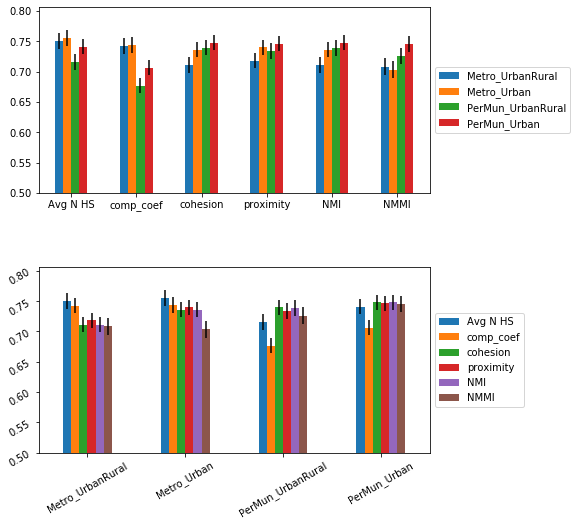

In [304]:

fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2,figsize=(8,8))
yerr =np.array([pd.DataFrame(df).values.T for df in intra_index_lvl_error_bar[True].values()])
pd.DataFrame(intra_index_lvl_aver[True]).plot(ax=ax1,kind='bar',yerr=yerr).legend(loc='center left', bbox_to_anchor=(1, 0.5))
pd.DataFrame(intra_index_lvl_aver[True]).T.plot(ax=ax2,kind='bar',yerr=yerr.transpose(2,1,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)

bottom = .5
top = None
ax1.set_ylim(bottom=bottom, top=top)
ax2.set_ylim(bottom=bottom, top=top)

# plt.savefig('figs/intra_methodLevel_SpearmnRho_chunking6.png', bbox_inches='tight')
plt.savefig('figs/intra_methodLevel_Jacc3_chunking6.png', bbox_inches='tight')


### within-method difference stability

In [177]:
# intra_metro_measures_chunking_diff[measure names (e.g. NMMI)][sun_id][key_combo (all mun_urb combo, all geom_type, all by)]

intra_metro_measures_hrdiff_chunking = defaultdict(lambda: defaultdict(dict))

for mname, lvl1 in intra_metro_measures_chunking.items():
    for sun, lvl2 in lvl1.items():
        diff_df = pd.DataFrame(lvl2) - pd.DataFrame(lvl2).apply(np.roll, shift=1)
        intra_metro_measures_hrdiff_chunking[mname][sun].update(diff_df.to_dict('list'))

srhos_4_astr_hrdiff_chunking = [get_srhos_per_astr(astr, intra_metro_measures_hrdiff_chunking) for astr in admin_strs]

Metro_UrbanRural
Avg N HS 

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

invalid value encountered in less_equal



9 16 29 33 39 54 58 59 59
comp_coef 9 15 16 20 29 39 54 58 59 59
cohesion 9 15 16 20 29 39 54 58 59 59
proximity 9 15 16 20 29 39 54 58 59 59
NMI 9 15 16 20 29 39 54 58 59 59
NMMI 59
Metro_Urban
Avg N HS 9 15 16 19 23 29 39 54 58 59 59
comp_coef 9 15 16 19 23 29 33 39 40 46 54 58 59 59
cohesion 9 15 16 19 23 29 33 39 40 46 54 58 59 59
proximity 9 15 16 19 23 29 33 39 40 46 54 58 59 59
NMI 9 15 16 19 23 29 33 39 40 46 54 58 59 59
NMMI 59
PerMun_UrbanRural
Avg N HS 9 23 33 51 54 58 59 59
comp_coef 9 15 19 20 23 54 58 59 59
cohesion 9 15 19 20 23 54 58 59 59
proximity 9 15 19 20 23 54 58 59 59
NMI 9 15 19 20 23 54 58 59 59
NMMI 59
PerMun_Urban
Avg N HS 9 15 16 19 20 23 39 40 54 58 59 59
comp_coef 9 15 16 19 20 23 39 40 51 54 58 59 59
cohesion 9 15 16 19 20 23 39 40 51 54 58 59 59
proximity 9 15 16 19 20 23 39 40 51 54 58 59 59
NMI 9 15 16 19 20 23 39 40 51 54 58 59 59
NMMI 59


#### index-lvl

In [180]:
intra_index_lvl_results = defaultdict(dict)
intra_index_lvl_aver = defaultdict(dict)
intra_index_lvl_error_bar = defaultdict(dict)

srhos_4_astr = srhos_4_astr_hrdiff_hourly

for aver_first in [True, False]:
    for i in range(4):
        astr = admin_strs[i]
        srhos_per_astr = srhos_4_astr[i]
        tmp_tbl, tbl_aver, tbl_error_bar = stats_of_srho_index_lvl(srhos_per_astr, aver_first=aver_first,average_on_raw=False)    
        intra_index_lvl_results[aver_first][astr]=tmp_tbl
        intra_index_lvl_aver[aver_first][astr]=tbl_aver
        intra_index_lvl_error_bar[aver_first][astr]=tbl_error_bar
#         break
#     break

Avg N HS 9 0 5 isnull
Avg N HS 9 0 6 isnull
Avg N HS 9 1 5 isnull
Avg N HS 9 1 6 isnull
Avg N HS 9 2 5 isnull
Avg N HS 9 2 6 isnull
Avg N HS 9 3 5 isnull
Avg N HS 9 3 6 isnull
Avg N HS 9 4 5 isnull
Avg N HS 9 4 6 isnull
Avg N HS 9 5 6 isnull
Avg N HS 16 0 5 isnull
Avg N HS 16 0 6 isnull
Avg N HS 16 1 5 isnull
Avg N HS 16 1 6 isnull
Avg N HS 16 2 5 isnull
Avg N HS 16 2 6 isnull
Avg N HS 16 3 5 isnull
Avg N HS 16 3 6 isnull
Avg N HS 16 4 5 isnull
Avg N HS 16 4 6 isnull
Avg N HS 16 5 6 isnull
Avg N HS 29 0 5 isnull
Avg N HS 29 0 6 isnull
Avg N HS 29 1 5 isnull
Avg N HS 29 1 6 isnull
Avg N HS 29 2 5 isnull
Avg N HS 29 2 6 isnull
Avg N HS 29 3 5 isnull
Avg N HS 29 3 6 isnull
Avg N HS 29 4 5 isnull
Avg N HS 29 4 6 isnull
Avg N HS 29 5 6 isnull
Avg N HS 33 0 5 isnull
Avg N HS 33 0 6 isnull
Avg N HS 33 1 5 isnull
Avg N HS 33 1 6 isnull
Avg N HS 33 2 5 isnull
Avg N HS 33 2 6 isnull
Avg N HS 33 3 5 isnull
Avg N HS 33 3 6 isnull
Avg N HS 33 4 5 isnull
Avg N HS 33 4 6 isnull
Avg N HS 33 5 6 isnull

comp_coef 23 0 5 isnull
comp_coef 23 1 5 isnull
comp_coef 23 2 5 isnull
comp_coef 23 3 5 isnull
comp_coef 23 4 5 isnull
comp_coef 23 5 6 isnull
comp_coef 29 0 6 isnull
comp_coef 29 1 6 isnull
comp_coef 29 2 6 isnull
comp_coef 29 3 6 isnull
comp_coef 29 4 6 isnull
comp_coef 29 5 6 isnull
comp_coef 39 0 5 isnull
comp_coef 39 1 5 isnull
comp_coef 39 2 5 isnull
comp_coef 39 3 5 isnull
comp_coef 39 4 5 isnull
comp_coef 39 5 6 isnull
comp_coef 54 0 1 isnull
comp_coef 54 0 2 isnull
comp_coef 54 0 3 isnull
comp_coef 54 0 4 isnull
comp_coef 54 0 5 isnull
comp_coef 54 0 6 isnull
comp_coef 54 1 3 isnull
comp_coef 54 1 5 isnull
comp_coef 54 1 6 isnull
comp_coef 54 2 3 isnull
comp_coef 54 2 5 isnull
comp_coef 54 2 6 isnull
comp_coef 54 3 4 isnull
comp_coef 54 3 5 isnull
comp_coef 54 3 6 isnull
comp_coef 54 4 5 isnull
comp_coef 54 4 6 isnull
comp_coef 54 5 6 isnull
comp_coef 58 0 2 isnull
comp_coef 58 0 5 isnull
comp_coef 58 0 6 isnull
comp_coef 58 1 2 isnull
comp_coef 58 1 5 isnull
comp_coef 58 1 6

comp_coef 54 0 6 isnull
comp_coef 54 1 6 isnull
comp_coef 54 2 6 isnull
comp_coef 54 3 6 isnull
comp_coef 54 4 6 isnull
comp_coef 54 5 6 isnull
comp_coef 58 0 2 isnull
comp_coef 58 0 5 isnull
comp_coef 58 0 6 isnull
comp_coef 58 1 2 isnull
comp_coef 58 1 5 isnull
comp_coef 58 1 6 isnull
comp_coef 58 2 3 isnull
comp_coef 58 2 4 isnull
comp_coef 58 2 5 isnull
comp_coef 58 2 6 isnull
comp_coef 58 3 5 isnull
comp_coef 58 3 6 isnull
comp_coef 58 4 5 isnull
comp_coef 58 4 6 isnull
comp_coef 58 5 6 isnull
comp_coef 59 0 6 isnull
comp_coef 59 1 6 isnull
comp_coef 59 2 6 isnull
comp_coef 59 3 6 isnull
comp_coef 59 4 6 isnull
comp_coef 59 5 6 isnull
cohesion 9 0 5 isnull
cohesion 9 0 6 isnull
cohesion 9 1 5 isnull
cohesion 9 1 6 isnull
cohesion 9 2 5 isnull
cohesion 9 2 6 isnull
cohesion 9 3 5 isnull
cohesion 9 3 6 isnull
cohesion 9 4 5 isnull
cohesion 9 4 6 isnull
cohesion 9 5 6 isnull
cohesion 16 0 5 isnull
cohesion 16 1 5 isnull
cohesion 16 2 5 isnull
cohesion 16 3 5 isnull
cohesion 16 4 5 is

cohesion 54 0 4 isnull
cohesion 54 0 5 isnull
cohesion 54 0 6 isnull
cohesion 54 1 5 isnull
cohesion 54 1 6 isnull
cohesion 54 2 5 isnull
cohesion 54 2 6 isnull
cohesion 54 3 5 isnull
cohesion 54 3 6 isnull
cohesion 54 4 5 isnull
cohesion 54 4 6 isnull
cohesion 54 5 6 isnull
cohesion 58 0 1 isnull
cohesion 58 0 2 isnull
cohesion 58 0 3 isnull
cohesion 58 0 4 isnull
cohesion 58 0 5 isnull
cohesion 58 0 6 isnull
cohesion 58 1 2 isnull
cohesion 58 1 6 isnull
cohesion 58 2 3 isnull
cohesion 58 2 4 isnull
cohesion 58 2 5 isnull
cohesion 58 2 6 isnull
cohesion 58 3 6 isnull
cohesion 58 4 6 isnull
cohesion 58 5 6 isnull
cohesion 59 0 5 isnull
cohesion 59 0 6 isnull
cohesion 59 1 5 isnull
cohesion 59 1 6 isnull
cohesion 59 2 5 isnull
cohesion 59 2 6 isnull
cohesion 59 3 5 isnull
cohesion 59 3 6 isnull
cohesion 59 4 5 isnull
cohesion 59 4 6 isnull
cohesion 59 5 6 isnull
proximity 9 0 1 isnull
proximity 9 0 2 isnull
proximity 9 0 3 isnull
proximity 9 0 4 isnull
proximity 9 0 5 isnull
proximity 9

NMI 16 0 6 isnull
NMI 16 1 6 isnull
NMI 16 2 6 isnull
NMI 16 3 6 isnull
NMI 16 4 6 isnull
NMI 16 5 6 isnull
NMI 29 0 5 isnull
NMI 29 0 6 isnull
NMI 29 1 5 isnull
NMI 29 1 6 isnull
NMI 29 2 5 isnull
NMI 29 2 6 isnull
NMI 29 3 5 isnull
NMI 29 3 6 isnull
NMI 29 4 5 isnull
NMI 29 4 6 isnull
NMI 29 5 6 isnull
NMI 39 0 5 isnull
NMI 39 1 5 isnull
NMI 39 2 5 isnull
NMI 39 3 5 isnull
NMI 39 4 5 isnull
NMI 39 5 6 isnull
NMI 54 0 6 isnull
NMI 54 1 6 isnull
NMI 54 2 6 isnull
NMI 54 3 6 isnull
NMI 54 4 6 isnull
NMI 54 5 6 isnull
NMI 58 0 2 isnull
NMI 58 0 5 isnull
NMI 58 0 6 isnull
NMI 58 1 2 isnull
NMI 58 1 5 isnull
NMI 58 1 6 isnull
NMI 58 2 3 isnull
NMI 58 2 4 isnull
NMI 58 2 5 isnull
NMI 58 2 6 isnull
NMI 58 3 5 isnull
NMI 58 3 6 isnull
NMI 58 4 5 isnull
NMI 58 4 6 isnull
NMI 58 5 6 isnull
NMI 59 0 5 isnull
NMI 59 1 5 isnull
NMI 59 2 5 isnull
NMI 59 3 5 isnull
NMI 59 4 5 isnull
NMI 59 5 6 isnull
Avg N HS 9 0 1 isnull
Avg N HS 9 0 2 isnull
Avg N HS 9 0 3 isnull
Avg N HS 9 0 4 isnull
Avg N HS 9 0

NMI 9 0 1 isnull
NMI 9 0 2 isnull
NMI 9 0 3 isnull
NMI 9 0 4 isnull
NMI 9 0 5 isnull
NMI 9 0 6 isnull
NMI 9 1 5 isnull
NMI 9 1 6 isnull
NMI 9 2 5 isnull
NMI 9 2 6 isnull
NMI 9 3 5 isnull
NMI 9 3 6 isnull
NMI 9 4 5 isnull
NMI 9 4 6 isnull
NMI 9 5 6 isnull
NMI 15 0 5 isnull
NMI 15 1 5 isnull
NMI 15 2 5 isnull
NMI 15 3 5 isnull
NMI 15 4 5 isnull
NMI 15 5 6 isnull
NMI 16 0 5 isnull
NMI 16 1 5 isnull
NMI 16 2 5 isnull
NMI 16 3 5 isnull
NMI 16 4 5 isnull
NMI 16 5 6 isnull
NMI 19 0 5 isnull
NMI 19 1 5 isnull
NMI 19 2 5 isnull
NMI 19 3 5 isnull
NMI 19 4 5 isnull
NMI 19 5 6 isnull
NMI 23 0 5 isnull
NMI 23 1 5 isnull
NMI 23 2 5 isnull
NMI 23 3 5 isnull
NMI 23 4 5 isnull
NMI 23 5 6 isnull
NMI 29 0 6 isnull
NMI 29 1 6 isnull
NMI 29 2 6 isnull
NMI 29 3 6 isnull
NMI 29 4 6 isnull
NMI 29 5 6 isnull
NMI 39 0 5 isnull
NMI 39 1 5 isnull
NMI 39 2 5 isnull
NMI 39 3 5 isnull
NMI 39 4 5 isnull
NMI 39 5 6 isnull
NMI 54 0 1 isnull
NMI 54 0 2 isnull
NMI 54 0 3 isnull
NMI 54 0 4 isnull
NMI 54 0 5 isnull
NMI 54 

comp_coef 9 0 1 isnull
comp_coef 9 0 2 isnull
comp_coef 9 0 3 isnull
comp_coef 9 0 4 isnull
comp_coef 9 0 5 isnull
comp_coef 9 0 6 isnull
comp_coef 9 1 5 isnull
comp_coef 9 1 6 isnull
comp_coef 9 2 5 isnull
comp_coef 9 2 6 isnull
comp_coef 9 3 5 isnull
comp_coef 9 3 6 isnull
comp_coef 9 4 5 isnull
comp_coef 9 4 6 isnull
comp_coef 9 5 6 isnull
comp_coef 15 0 6 isnull
comp_coef 15 1 6 isnull
comp_coef 15 2 6 isnull
comp_coef 15 3 6 isnull
comp_coef 15 4 6 isnull
comp_coef 15 5 6 isnull
comp_coef 16 0 5 isnull
comp_coef 16 1 5 isnull
comp_coef 16 2 5 isnull
comp_coef 16 3 5 isnull
comp_coef 16 4 5 isnull
comp_coef 16 5 6 isnull
comp_coef 19 0 5 isnull
comp_coef 19 1 5 isnull
comp_coef 19 2 5 isnull
comp_coef 19 3 5 isnull
comp_coef 19 4 5 isnull
comp_coef 19 5 6 isnull
comp_coef 20 0 6 isnull
comp_coef 20 1 6 isnull
comp_coef 20 2 6 isnull
comp_coef 20 3 6 isnull
comp_coef 20 4 6 isnull
comp_coef 20 5 6 isnull
comp_coef 23 0 6 isnull
comp_coef 23 1 6 isnull
comp_coef 23 2 6 isnull
comp_co

In [181]:
print('color by average')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[True]), 0, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))

color by average


,Metro_UrbanRural,Metro_Urban,PerMun_UrbanRural,PerMun_Urban
Avg N HS,"0.285 (0.162)(0.213~0.350)(-0.072~0.065)0.219 (0.181~0.362)[0.104, 0.690]","0.270 (0.127)(0.213~0.320)(-0.056~0.051)0.218 (0.185~0.341)[0.096, 0.578]","0.219 (0.115)(0.166~0.264)(-0.053~0.045)0.177 (0.148~0.292)[0.074, 0.534]","0.242 (0.113)(0.192~0.288)(-0.051~0.045)0.196 (0.158~0.315)[0.106, 0.522]"
comp_coef,"0.330 (0.088)(0.288~0.363)(-0.042~0.033)0.311 (0.278~0.345)[0.218, 0.632]","0.316 (0.053)(0.292~0.336)(-0.023~0.021)0.312 (0.281~0.330)[0.237, 0.458]","0.190 (0.069)(0.158~0.217)(-0.032~0.027)0.169 (0.142~0.211)[0.107, 0.386]","0.209 (0.055)(0.185~0.231)(-0.024~0.022)0.216 (0.163~0.233)[0.131, 0.332]"
cohesion,"0.162 (0.088)(0.120~0.191)(-0.042~0.029)0.137 (0.121~0.157)[0.084, 0.518]","0.177 (0.042)(0.159~0.194)(-0.018~0.017)0.167 (0.157~0.198)[0.116, 0.277]","0.196 (0.057)(0.170~0.219)(-0.026~0.023)0.178 (0.156~0.256)[0.122, 0.348]","0.220 (0.076)(0.186~0.251)(-0.034~0.030)0.202 (0.175~0.240)[0.117, 0.427]"
proximity,"0.169 (0.090)(0.125~0.201)(-0.044~0.032)0.132 (0.120~0.186)[0.097, 0.515]","0.190 (0.046)(0.170~0.209)(-0.020~0.019)0.184 (0.160~0.216)[0.116, 0.281]","0.191 (0.060)(0.164~0.215)(-0.027~0.024)0.173 (0.140~0.233)[0.123, 0.351]","0.222 (0.075)(0.189~0.253)(-0.033~0.030)0.201 (0.177~0.251)[0.117, 0.439]"
NMI,"0.162 (0.088)(0.119~0.192)(-0.043~0.030)0.137 (0.120~0.157)[0.084, 0.518]","0.177 (0.042)(0.159~0.194)(-0.018~0.017)0.167 (0.157~0.198)[0.116, 0.277]","0.194 (0.058)(0.168~0.218)(-0.026~0.024)0.170 (0.145~0.256)[0.122, 0.348]","0.220 (0.076)(0.186~0.250)(-0.034~0.030)0.202 (0.175~0.240)[0.117, 0.427]"
NMMI,"0.216 (0.097)(0.172~0.253)(-0.045~0.036)0.184 (0.160~0.246)[0.104, 0.563]","0.232 (0.064)(0.204~0.259)(-0.027~0.027)0.235 (0.180~0.266)[0.125, 0.372]","0.275 (0.085)(0.236~0.308)(-0.038~0.033)0.267 (0.216~0.288)[0.174, 0.493]","0.299 (0.074)(0.267~0.331)(-0.031~0.032)0.303 (0.256~0.348)[0.152, 0.431]"


color by median


,Metro_UrbanRural,Metro_Urban,PerMun_UrbanRural,PerMun_Urban
Avg N HS,"0.219 (0.181~0.362)[0.104, 0.690]0.285 (0.162)(0.212~0.349)(-0.073~0.064)","0.218 (0.185~0.341)[0.096, 0.578]0.270 (0.127)(0.212~0.320)(-0.058~0.051)","0.177 (0.148~0.292)[0.074, 0.534]0.219 (0.115)(0.167~0.264)(-0.052~0.046)","0.196 (0.158~0.315)[0.106, 0.522]0.242 (0.113)(0.192~0.288)(-0.050~0.046)"
comp_coef,"0.311 (0.278~0.345)[0.218, 0.632]0.330 (0.088)(0.288~0.363)(-0.041~0.033)","0.312 (0.281~0.330)[0.237, 0.458]0.316 (0.053)(0.292~0.337)(-0.024~0.021)","0.169 (0.142~0.211)[0.107, 0.386]0.190 (0.069)(0.159~0.218)(-0.032~0.028)","0.216 (0.163~0.233)[0.131, 0.332]0.209 (0.055)(0.185~0.232)(-0.024~0.023)"
cohesion,"0.137 (0.121~0.157)[0.084, 0.518]0.162 (0.088)(0.120~0.192)(-0.042~0.030)","0.167 (0.157~0.198)[0.116, 0.277]0.177 (0.042)(0.159~0.194)(-0.018~0.017)","0.178 (0.156~0.256)[0.122, 0.348]0.196 (0.057)(0.170~0.219)(-0.026~0.023)","0.202 (0.175~0.240)[0.117, 0.427]0.220 (0.076)(0.187~0.250)(-0.033~0.030)"
proximity,"0.132 (0.120~0.186)[0.097, 0.515]0.169 (0.090)(0.125~0.200)(-0.044~0.032)","0.184 (0.160~0.216)[0.116, 0.281]0.190 (0.046)(0.170~0.209)(-0.020~0.019)","0.173 (0.140~0.233)[0.123, 0.351]0.191 (0.060)(0.164~0.215)(-0.026~0.024)","0.201 (0.177~0.251)[0.117, 0.439]0.222 (0.075)(0.188~0.252)(-0.034~0.030)"
NMI,"0.137 (0.120~0.157)[0.084, 0.518]0.162 (0.088)(0.119~0.191)(-0.043~0.029)","0.167 (0.157~0.198)[0.116, 0.277]0.177 (0.042)(0.159~0.194)(-0.018~0.017)","0.170 (0.145~0.256)[0.122, 0.348]0.194 (0.058)(0.169~0.218)(-0.026~0.024)","0.202 (0.175~0.240)[0.117, 0.427]0.220 (0.076)(0.186~0.251)(-0.034~0.031)"
NMMI,"0.184 (0.160~0.246)[0.104, 0.563]0.216 (0.097)(0.171~0.253)(-0.046~0.036)","0.235 (0.180~0.266)[0.125, 0.372]0.232 (0.064)(0.204~0.259)(-0.028~0.027)","0.267 (0.216~0.288)[0.174, 0.493]0.275 (0.085)(0.236~0.308)(-0.039~0.033)","0.303 (0.256~0.348)[0.152, 0.431]0.299 (0.074)(0.267~0.330)(-0.031~0.031)"


In [57]:
print('color by average')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[True]), 0, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(intra_index_lvl_results[False]), 0, 1, mask_tril=False))


color by average


,Metro_UrbanRural,Metro_Urban,PerMun_UrbanRural,PerMun_Urban
Avg N HS,"0.375 (0.193)(0.288~0.453)(-0.087~0.078)0.291 (0.246~0.514)[0.156, 0.818]","0.372 (0.156)(0.304~0.436)(-0.069~0.064)0.324 (0.259~0.495)[0.141, 0.681]","0.314 (0.161)(0.242~0.377)(-0.071~0.064)0.241 (0.207~0.436)[0.145, 0.711]","0.342 (0.148)(0.276~0.404)(-0.066~0.061)0.286 (0.229~0.475)[0.175, 0.639]"
comp_coef,"0.528 (0.084)(0.490~0.562)(-0.038~0.034)0.519 (0.461~0.551)[0.397, 0.771]","0.537 (0.053)(0.514~0.559)(-0.023~0.022)0.523 (0.510~0.570)[0.445, 0.669]","0.299 (0.085)(0.259~0.331)(-0.039~0.033)0.269 (0.247~0.314)[0.195, 0.563]","0.327 (0.081)(0.290~0.359)(-0.036~0.032)0.297 (0.277~0.349)[0.222, 0.506]"
cohesion,"0.250 (0.095)(0.204~0.285)(-0.046~0.035)0.235 (0.182~0.269)[0.140, 0.600]","0.289 (0.057)(0.264~0.313)(-0.025~0.024)0.284 (0.244~0.319)[0.178, 0.404]","0.292 (0.084)(0.254~0.326)(-0.038~0.034)0.258 (0.235~0.358)[0.186, 0.513]","0.356 (0.105)(0.310~0.401)(-0.046~0.045)0.356 (0.264~0.437)[0.193, 0.572]"
proximity,"0.260 (0.099)(0.214~0.299)(-0.046~0.039)0.245 (0.189~0.299)[0.149, 0.592]","0.306 (0.058)(0.281~0.330)(-0.025~0.025)0.296 (0.275~0.332)[0.195, 0.439]","0.291 (0.090)(0.251~0.328)(-0.040~0.037)0.257 (0.215~0.359)[0.195, 0.526]","0.356 (0.100)(0.312~0.398)(-0.045~0.041)0.369 (0.267~0.442)[0.215, 0.574]"
NMI,"0.250 (0.095)(0.205~0.285)(-0.045~0.035)0.235 (0.182~0.269)[0.140, 0.600]","0.289 (0.057)(0.264~0.313)(-0.025~0.024)0.284 (0.244~0.319)[0.178, 0.404]","0.290 (0.084)(0.252~0.324)(-0.038~0.033)0.253 (0.234~0.347)[0.186, 0.513]","0.356 (0.105)(0.310~0.401)(-0.046~0.044)0.356 (0.264~0.437)[0.193, 0.572]"
NMMI,"0.300 (0.112)(0.249~0.344)(-0.052~0.044)0.266 (0.211~0.358)[0.174, 0.653]","0.334 (0.084)(0.298~0.368)(-0.036~0.034)0.319 (0.276~0.383)[0.172, 0.538]","0.354 (0.106)(0.305~0.396)(-0.048~0.042)0.346 (0.276~0.373)[0.215, 0.655]","0.387 (0.087)(0.350~0.424)(-0.037~0.037)0.385 (0.329~0.434)[0.231, 0.564]"


color by median


,Metro_UrbanRural,Metro_Urban,PerMun_UrbanRural,PerMun_Urban
Avg N HS,"0.291 (0.246~0.514)[0.156, 0.818]0.375 (0.193)(0.287~0.454)(-0.088~0.079)","0.324 (0.259~0.495)[0.141, 0.681]0.372 (0.156)(0.302~0.436)(-0.070~0.063)","0.241 (0.207~0.436)[0.145, 0.711]0.314 (0.161)(0.241~0.378)(-0.073~0.064)","0.286 (0.229~0.475)[0.175, 0.639]0.342 (0.148)(0.276~0.403)(-0.066~0.060)"
comp_coef,"0.519 (0.461~0.551)[0.397, 0.771]0.528 (0.084)(0.491~0.562)(-0.037~0.034)","0.523 (0.510~0.570)[0.445, 0.669]0.537 (0.053)(0.513~0.559)(-0.024~0.022)","0.269 (0.247~0.314)[0.195, 0.563]0.299 (0.085)(0.260~0.331)(-0.039~0.033)","0.297 (0.277~0.349)[0.222, 0.506]0.327 (0.081)(0.291~0.359)(-0.036~0.033)"
cohesion,"0.235 (0.182~0.269)[0.140, 0.600]0.250 (0.095)(0.205~0.285)(-0.045~0.035)","0.284 (0.244~0.319)[0.178, 0.404]0.289 (0.057)(0.265~0.313)(-0.024~0.024)","0.258 (0.235~0.358)[0.186, 0.513]0.292 (0.084)(0.255~0.326)(-0.037~0.034)","0.356 (0.264~0.437)[0.193, 0.572]0.356 (0.105)(0.311~0.400)(-0.045~0.044)"
proximity,"0.245 (0.189~0.299)[0.149, 0.592]0.260 (0.099)(0.212~0.298)(-0.048~0.038)","0.296 (0.275~0.332)[0.195, 0.439]0.306 (0.058)(0.280~0.330)(-0.025~0.025)","0.257 (0.215~0.359)[0.195, 0.526]0.291 (0.090)(0.250~0.327)(-0.041~0.036)","0.369 (0.267~0.442)[0.215, 0.574]0.356 (0.100)(0.312~0.398)(-0.044~0.041)"
NMI,"0.235 (0.182~0.269)[0.140, 0.600]0.250 (0.095)(0.205~0.285)(-0.045~0.036)","0.284 (0.244~0.319)[0.178, 0.404]0.289 (0.057)(0.264~0.314)(-0.025~0.024)","0.253 (0.234~0.347)[0.186, 0.513]0.290 (0.084)(0.252~0.324)(-0.038~0.034)","0.356 (0.264~0.437)[0.193, 0.572]0.356 (0.105)(0.312~0.400)(-0.045~0.044)"
NMMI,"0.266 (0.211~0.358)[0.174, 0.653]0.300 (0.112)(0.250~0.344)(-0.050~0.044)","0.319 (0.276~0.383)[0.172, 0.538]0.334 (0.084)(0.297~0.368)(-0.037~0.035)","0.346 (0.276~0.373)[0.215, 0.655]0.354 (0.106)(0.306~0.397)(-0.048~0.043)","0.385 (0.329~0.434)[0.231, 0.564]0.387 (0.087)(0.350~0.424)(-0.037~0.037)"


### cluster-based

#### level of preservation then clustering

In [542]:
weak_tau = 0.3
strong_tau = 0.7
medium_tau = 0.5


In [543]:
def flat_triu(matrix):
    return matrix.values[np.triu_indices(len(matrix),1)]

In [588]:
sun = 45

grad_bg(srhos_4_astr[0]['Avg N HS'][sun], mini=0, maxi=1, mask_tril=True)

In [579]:
measure_type = ['Avg N HS', 'comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'][0]
srhos = srhos_4_astr[0][measure_type]

triu_srhos = {sun:flat_triu(k) for sun, k in srhos.items()}
triu_srhos = pd.DataFrame(triu_srhos).T
triu_srhos.index.name='zm'
triu_srhos.columns.name='srho'

n_none = triu_srhos.apply(lambda k: (k<weak_tau).sum(), axis=1)
n_weak = triu_srhos.apply(lambda k: ((k>=weak_tau)&(k<medium_tau)).sum(), axis=1)
n_medium = triu_srhos.apply(lambda k: ((k>=medium_tau)&(k<strong_tau)).sum(), axis=1)
# n_medium_above = triu_srhos.apply(lambda k: (k>=medium_tau).sum(), axis=1)
n_strong = triu_srhos.apply(lambda k: (k>=strong_tau).sum(), axis=1)


triu_srhos_stats = pd.DataFrame([n_none,n_weak, n_medium, n_strong], index=['None','Weak', 'Medm', 'Strn']).T
disp_df = triu_srhos_stats.sort_values(['Strn','Medm','Weak'],ascending=False)
disp_df = triu_srhos_stats.reindex(list(range(1,60)))

print(astr)
print(measure_type)
display(grad_bg(disp_df, format_float=False, mask_tril=False,mini=0, maxi=21))


PerMun_Urban
Avg N HS


,None,Weak,Medm,Strn
zm,,,,
1,16,1,0,4
2,14,0,0,7
3,9,3,5,4
4,12,0,2,7
5,12,5,0,4
6,10,1,4,6
7,14,1,3,3
8,12,1,2,6
9,,,,


In [545]:
#
print(astr)
print(measure_type)

c = cluster.OPTICS().fit(triu_ktaus_stats)
print(c.labels_)
cluster_members = pd.DataFrame(np.unique(c.labels_, return_counts=True), index=['c','#']).T.set_index('c')


c_avg = {}
for cl in cluster_members.index.values:
#     if cl ==-1: continue
    c_avg[cl]=triu_ktaus_stats.loc[c.labels_==cl].mean().round(1).astype(str) +' ('+triu_ktaus_stats.loc[c.labels_==cl].std().round(1).astype(str) +')'

cluster_members.join(pd.DataFrame(c_avg).T)

PerMun_Urban
NMMI


NameError: name 'cluster' is not defined

In [546]:

display(grad_bg(ktaus[4], mask_tril=True,mini=0, maxi=1))


/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



#### clustering on Kendall tau matrix

In [640]:
import sklearn.cluster as cluster

In [716]:
ktaus_per_astr.keys()

dict_keys(['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'])

In [761]:
# clustered = cluster.AgglomerativeClustering(n_clusters=5, affinity='precomputed',linkage='average').fit(dist)
# clustered = cluster.OPTICS(metric='precomputed').fit(dist)

# default settings of minkowski distance seems to be equal to euclidean
# metric = ['braycurtis','chebyshev', 'hamming', 'minkowski'][0]
metric= ['cityblock', 'cosine', 'euclidean', 'l1', 'l2','manhattan'][1]
metric = ['canberra', 'correlation', 'sqeuclidean', ][0]
print('metric =',metric)

labels_for_each_mname = {}
for measure_name in ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI']:
    ktaus = ktaus_per_astr[measure_name]
    ftrs = [k.values[np.triu_indices(len(k),1)] for k in ktaus.values()]
    clustered = cluster.OPTICS(metric=metric).fit(ftrs)
    labels_for_each_mname[measure_name] = clustered.labels_
    

pd.DataFrame({k: pd.Series(v).value_counts().to_dict() for k, v in labels_for_each_mname.items()}).sort_index()

metric = canberra


,comp_coef,cohesion,proximity,NMI,NMMI
-1,41.0,NaN,28,NaN,51.0
0,8.0,49.0,9,49.0,8.0
1,NaN,NaN,6,NaN,NaN
2,NaN,NaN,6,NaN,NaN


In [778]:
measure_name = ['comp_coef', 'cohesion', 'proximity', 'NMI', 'NMMI'][2]
labels = labels_for_each_mname[measure_name]
ktaus = ktaus_per_astr[measure_name]
label_members = np.array(list(ktaus.keys()))[labels==0]
label_members

array([17, 24, 36, 42, 44, 46, 47, 51, 55])

In [779]:
swap_df = ktaus[label_members[0]]
display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True,mini=0, maxi=1))

In [780]:
swap_df = ktaus[label_members[1]]
display(grad_bg(swap_df.T.sort_index(level=0).T.sort_index(level=0), mask_tril=True,mini=0, maxi=1))

# hotspot overlap

In [52]:
if loading == ('ageb', 'grid', 'idw'):
    method_order = {
        'ageb<br/>area': 0,
        'ageb<br/>pop': 1,
        'grid<br/>_idw': 2,
        'grid<br/>area': 3,
        'grid<br/>pop': 4,
    }
elif loading == ('ageb', 'grid', 'idw', 'vor'):
    method_order = {
        'ageb<br/>area': 0,
        'ageb<br/>pop': 1,
        'grid<br/>_idw': 2,
        'grid<br/>area': 3,
        'grid<br/>pop': 4,
        'vor<br/>area': 5,
        'vor<br/>pop': 6
    }
method_names = list(method_order.keys())
method_order

{'ageb<br/>area': 0,
 'ageb<br/>pop': 1,
 'grid<br/>_idw': 2,
 'grid<br/>area': 3,
 'grid<br/>pop': 4,
 'vor<br/>area': 5,
 'vor<br/>pop': 6}

## organize avg, geoms

In [60]:
zms_agebs = zms_agebs.merge(mg_mappings[['ageb_id','CVE_SUN']], right_on='ageb_id', left_index=True)

zms_agebs.set_index('ageb_id',inplace=True)

In [61]:
zms_agebs_tmp = {}
zms_agebs_urb = zms_agebs[zms_agebs.Type=="Urban"]
zms_agebs_tmp[(False, False)] = zms_agebs
zms_agebs_tmp[(True, False)] = zms_agebs
zms_agebs_tmp[(False, True)] = zms_agebs_urb
zms_agebs_tmp[(True, True)] = zms_agebs_urb

zms_all_geoms={'ageb': zms_agebs_tmp, 'grid':zms_grids, 'vor': zms_sub_vors}  #[geom_type][(per_mun, urb_only)]

In [62]:
avg_all_geoms={}  # keys: (geom_type, by, per_mun, urb_only)
for per_mun in [False, True]:
    for urb_only in [False, True]:
        avg_all_geoms[('ageb', 'area', per_mun, urb_only)] = avg_a['area']
        avg_all_geoms[('ageb', 'pop', per_mun, urb_only)] = avg_a['pop']
        avg_all_geoms[('grid', 'area', per_mun, urb_only)] = avg_g[('area', per_mun, urb_only)]
        avg_all_geoms[('grid', 'pop', per_mun, urb_only)] = avg_g[('pop', per_mun, urb_only)]
        avg_all_geoms[('grid', '_idw', per_mun, urb_only)] = avg_idw[(per_mun, urb_only)]
        avg_all_geoms[('vor', 'area', per_mun, urb_only)] = avg_vor[('area', per_mun, urb_only)]
        avg_all_geoms[('vor', 'pop', per_mun, urb_only)] = avg_vor[('pop', per_mun, urb_only)]

## get_permanent index for each sun in each method and mun_urb_combo

In [63]:
def get_hs_permanent_hourly_index(zms, zms_geoms, avg_geoms, verbose=0, per_mun=False, geom_type='grid', hotspot_type='loubar'):
    permanent_indexes = {}
    hourly_indexes = {}
    for sun in sorted(zms.index):
        print(sun, end=' ')
        zm = zms.loc[sun]
        zm_g = zms_geoms[zms_geoms.CVE_SUN == sun].copy()
        zm_avg_g = avg_geoms.reindex(zm_g.index, fill_value=0).copy()
        hs = ud_helper.ftr_hs.HotSpot(zm_avg_g, zm_g, zm, hotspot_type, verbose=verbose)
        hs_avg = None

        if per_mun:
            hs_avg = []
            for _, mun_g in zm_g.groupby('mun_id'):
                mun_avg_g = avg_geoms.reindex(mun_g.index, fill_value=0).copy()
                # print(sun, mun_g.mun_id.iloc[0],'mun g not in avg', set(mun_g.index) - set(avg_g.index))
                # print('mun_avg_g isnull', mun_avg_g.isnull().sum(), mun_avg_g.shape)
                # TODO: I don't remember why set 10 for grid. 10 doesn't work for Vor, sun 15 always < 10 in PerMun True
                if geom_type == 'grid' and len(mun_g) < 10:
                    continue
                if geom_type == 'vor' and len(mun_g) < 2:
                    continue
                mun_hot = ud_helper.ftr_hs.keep_hotspot(mun_avg_g, hotspot_type)
                hs_avg.append(mun_hot)

            hs_avg = pd.concat(hs_avg).reindex(zm_g.index, fill_value=0)
        
        hs._get_hs(hs_avg)
        hs._hs_type_by_persistence()
        permanent_indexes[sun] = hs.hs_permanent.index.tolist()
        hourly_indexes[sun] = hs.get_hourly_hs_index()
        
    return permanent_indexes, hourly_indexes

In [64]:
permanent_all_indexes = defaultdict(dict) #  [(per_mun, urb_only)][(geom_type, by)][sun] = indexes of this geom_type in sun
hourly_all_indexes = defaultdict(dict) #  [(per_mun, urb_only)][(geom_type, by)][sun][hour] = indexes of this geom_type in sun of this hour

for (geom_type, by, per_mun, urb_only), avg_geoms in avg_all_geoms.items():
#     if per_mun or urb_only: continue
    print(ADMIN_STR(per_mun, urb_only), geom_type, by, end=' ')
    zms_geoms = zms_all_geoms[geom_type][(per_mun, urb_only)]
    permanent_index, hourly_index = get_hs_permanent_hourly_index(zms, zms_geoms, avg_geoms, per_mun=per_mun, geom_type=geom_type)
    permanent_all_indexes[(per_mun, urb_only)][(geom_type, by)] = permanent_index
    hourly_all_indexes[(per_mun, urb_only)][(geom_type, by)] = hourly_index

    print()


Metro_UrbanRural ageb area 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural ageb pop 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural grid area 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural grid pop 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural grid _idw 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
Metro_UrbanRural vor a

## compute overlap score for each per_mun, urb_only combo separetely

In [65]:
def intersection_handling_error(zm_geoms1_union, zm_geoms2_union, msg=None):
    buffer=0
    delta = 1e-10
    while True:
        try:
            if not buffer:
                # first time
                zm_geoms12_inxn = zm_geoms1_union.intersection(zm_geoms2_union)
            else: 
                zm_geoms12_inxn = zm_geoms1_union.buffer(buffer).intersection(zm_geoms2_union.buffer(buffer))
            # successful, break loop
            break
        except TopologicalError:
            buffer += delta
            print(msg,'using buffer:',buffer)
    return zm_geoms12_inxn

In [66]:
def get_overlap_scores(indexes_mun_urb_combo, verbose=0):
    overlap_scores =[]
    for (gt1, by1), (gt2,by2) in combinations(indexes_mun_urb_combo.keys(), 2):
        if verbose: print('method pair', gt1, by1, gt2,by2, end=' ')
        idx1 = indexes_mun_urb_combo[(gt1, by1)]
        idx2 = indexes_mun_urb_combo[(gt2, by2)]
        geoms1 = zms_all_geoms[gt1][(per_mun, urb_only)]
        geoms2 = zms_all_geoms[gt2][(per_mun, urb_only)]
        for sun_id in idx1.keys():
            if verbose: print(sun_id, end=' ')
            zm_idx1 = idx1[sun_id]
            zm_idx2 = idx2[sun_id]
            zm_geoms1 = geoms1.loc[zm_idx1]
            zm_geoms2 = geoms2.loc[zm_idx2]
            zm_geoms1_union = cascaded_union(zm_geoms1.geometry)
            zm_geoms2_union = cascaded_union(zm_geoms2.geometry)
            zm_geoms12_inxn = intersection_handling_error(zm_geoms1_union, zm_geoms2_union, msg=f'({gt1},{by1}), ({gt2},{by2}), {sun_id}')
            overlap_scores.append({'gt1': gt1, 'by1': by1, 'gt2':gt2, 'by2': by2, 'CVE_SUN': sun_id, 
                                   'area1': zm_geoms1_union.area, 'area2': zm_geoms2_union.area,
                                  'area_overlap': zm_geoms12_inxn.area})
    #         break
        if verbose: print()
    #     break
    overlap_scores = pd.DataFrame(overlap_scores)
    overlap_scores['jaccard'] = overlap_scores.area_overlap /(overlap_scores.area1+ overlap_scores.area2 - overlap_scores.area_overlap)
    overlap_scores['overlap_score_norm_by_sum'] = 2* overlap_scores.area_overlap / (overlap_scores.area1+ overlap_scores.area2)
    overlap_scores['overlap_score_norm_by_min'] = overlap_scores.area_overlap / overlap_scores[['area1', 'area2']].min(axis=1)
    return overlap_scores

In [67]:
from shapely.errors import TopologicalError

In [68]:
all_overlap_scores = {}
for per_mun in [False, True, ]:
    for urb_only in [False, True]:
#         if not per_mun: continue
        astr = ADMIN_STR(per_mun, urb_only)
        print(astr)
        indexes_mun_urb_combo = permanent_all_indexes[(per_mun, urb_only)]
        overlap_scores = get_overlap_scores(indexes_mun_urb_combo)
        all_overlap_scores[astr] = overlap_scores
#         break
#     break
 

Metro_UrbanRural
Metro_Urban
PerMun_UrbanRural


TopologyException: found non-noded intersection between LINESTRING (2.8367e+06 798323, 2.83673e+06 798302) and LINESTRING (2.83673e+06 798302, 2.8367e+06 798323) at 2836729.1507910709 798302.18663725257


(ageb,area), (ageb,pop), 13 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.90849e+06 820552, 2.9085e+06 820539) and LINESTRING (2.9085e+06 820539, 2.90849e+06 820552) at 2908498.7766025183 820539.13343995099


(ageb,area), (grid,_idw), 46 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.9094e+06 819736, 2.90942e+06 819694) and LINESTRING (2.90942e+06 819694, 2.9094e+06 819736) at 2909422.7387550967 819694.00822938513


(ageb,area), (grid,_idw), 46 using buffer: 2e-10


TopologyException: found non-noded intersection between LINESTRING (2.90884e+06 820269, 2.90884e+06 820264) and LINESTRING (2.90884e+06 820264, 2.90884e+06 820269) at 2908841.5182515387 820264.17049919686


(ageb,area), (grid,_idw), 46 using buffer: 3e-10


TopologyException: found non-noded intersection between LINESTRING (2.80237e+06 853769, 2.80237e+06 853726) and LINESTRING (2.80237e+06 853772, 2.80237e+06 853768) at 2802373.610058201 853768.75129700999


(grid,area), (grid,_idw), 13 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.80237e+06 853769, 2.80237e+06 853726) and LINESTRING (2.80237e+06 853772, 2.80237e+06 853768) at 2802373.610058201 853768.75129700999


(grid,area), (grid,_idw), 13 using buffer: 2e-10


TopologyException: found non-noded intersection between LINESTRING (2.88993e+06 813664, 2.88992e+06 813662) and LINESTRING (2.88992e+06 813663, 2.88992e+06 813662) at 2889923.5454860912 813663.29249359923


(grid,area), (grid,_idw), 46 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.90297e+06 811634, 2.90295e+06 811628) and LINESTRING (2.90296e+06 811630, 2.90295e+06 811628) at 2902956.3355114697 811629.22170968051


(grid,area), (grid,_idw), 46 using buffer: 2e-10


TopologyException: found non-noded intersection between LINESTRING (2.90299e+06 811637, 2.90297e+06 811633) and LINESTRING (2.90298e+06 811635, 2.90297e+06 811633) at 2902971.9570866013 811633.42553371633


(grid,area), (grid,_idw), 46 using buffer: 3e-10


TopologyException: found non-noded intersection between LINESTRING (2.83309e+06 868581, 2.83264e+06 868557) and LINESTRING (2.83271e+06 868535, 2.83264e+06 868559) at 2832643.2163642687 868556.9660753092


(grid,area), (vor,area), 13 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.84117e+06 790629, 2.8412e+06 790630) and LINESTRING (2.84117e+06 790628, 2.84117e+06 790633) at 2841171.2453475189 790628.6546688833


(grid,area), (vor,area), 13 using buffer: 2e-10


TopologyException: found non-noded intersection between LINESTRING (2.83309e+06 868581, 2.83264e+06 868557) and LINESTRING (2.83271e+06 868535, 2.83264e+06 868559) at 2832643.2163642687 868556.9660753092


(grid,area), (vor,pop), 13 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.84811e+06 791649, 2.84811e+06 791649) and LINESTRING (2.84811e+06 791649, 2.84811e+06 791649) at 2848106.8245052639 791648.68099646841


(grid,area), (vor,pop), 13 using buffer: 2e-10


TopologyException: found non-noded intersection between LINESTRING (2.80613e+06 854449, 2.80613e+06 854451) and LINESTRING (2.80613e+06 854449, 2.80613e+06 854451) at 2806130.2871093568 854449.66426600167


(grid,pop), (grid,_idw), 13 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.80632e+06 855280, 2.80632e+06 855308) and LINESTRING (2.80632e+06 855310, 2.80632e+06 855280) at 2806322.8959724167 855307.06679088436


(grid,pop), (grid,_idw), 13 using buffer: 2e-10


TopologyException: found non-noded intersection between LINESTRING (2.80442e+06 859365, 2.80437e+06 859464) and LINESTRING (2.80324e+06 859418, 2.80439e+06 859423) at 2804388.8302088608 859422.65602858225


(grid,_idw), (vor,area), 13 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.83922e+06 790561, 2.83922e+06 790561) and LINESTRING (2.83922e+06 790561, 2.83922e+06 790561) at 2839223.4360999987 790561.25849999872


(grid,_idw), (vor,area), 13 using buffer: 2e-10


TopologyException: found non-noded intersection between LINESTRING (2.83671e+06 798548, 2.83669e+06 798491) and LINESTRING (2.83669e+06 798491, 2.83807e+06 799057) at 2836686.9078631233 798491.15850429609


(grid,_idw), (vor,pop), 13 using buffer: 1e-10


TopologyException: found non-noded intersection between LINESTRING (2.83284e+06 787045, 2.83294e+06 786997) and LINESTRING (2.83284e+06 787045, 2.83294e+06 786997) at 2832928.6224386729 787001.93558368855


(grid,_idw), (vor,pop), 13 using buffer: 2e-10
PerMun_Urban


In [215]:
overlap_scores = all_overlap_scores['Metro_Urban']
tmp = overlap_scores[overlap_scores.CVE_SUN==1].sort_values(['gt1','by1','gt2','by2'])
tmp

,gt1,by1,gt2,by2,CVE_SUN,area1,area2,area_overlap,jaccard,overlap_score_norm_by_sum,overlap_score_norm_by_min
0,ageb,area,ageb,pop,1,1.896573e+07,1.768174e+07,8.217604e+06,0.289048,0.448468,0.464751
177,ageb,area,grid,_idw,1,1.896573e+07,3.248503e+06,6.785394e+05,0.031508,0.061091,0.208878
59,ageb,area,grid,area,1,1.896573e+07,7.726606e+06,1.949377e+06,0.078785,0.146063,0.252294
118,ageb,area,grid,pop,1,1.896573e+07,1.022083e+07,1.878265e+06,0.068780,0.128708,0.183768
236,ageb,area,vor,area,1,1.896573e+07,2.468424e+07,8.487464e+06,0.241378,0.388887,0.447516
295,ageb,area,vor,pop,1,1.896573e+07,3.338572e+07,8.617461e+06,0.197043,0.329216,0.454370
472,ageb,pop,grid,_idw,1,1.768174e+07,3.248503e+06,1.119545e+06,0.056512,0.106979,0.344634
354,ageb,pop,grid,area,1,1.768174e+07,7.726606e+06,2.020797e+06,0.086405,0.159066,0.261537
413,ageb,pop,grid,pop,1,1.768174e+07,1.022083e+07,5.665407e+06,0.254772,0.406085,0.554300
531,ageb,pop,vor,area,1,1.768174e+07,2.468424e+07,1.018049e+07,0.316307,0.480597,0.575763


## Analysis index-lvl and method lvl

In [339]:
def stats_str_for_arr(arr, aver_first=True, return_values=True):
    bres = bs.bootstrap(arr, stat_func=bs_stats.mean)
    l_diff = f'{(bres.lower_bound-bres.value):.3f}'
    u_diff = f'{(bres.upper_bound-bres.value):.3f}'
    str_median_quantile = f'{np.median(arr):.3f} <br/>({np.percentile(arr,25):.3f}~{np.percentile(arr,75):.3f})'
    str_mean_std = f'{bres.value:.3f} ({arr.std():.3f})'
    str_conf_inter = f'({bres.lower_bound:.3f}~{bres.upper_bound:.3f})<br/>({l_diff}~{u_diff})'
    str_min_max = f'[{arr.min():.3f}, {arr.max():.3f}]'
    if aver_first:
        final_str = f'{str_mean_std}<br/>{str_conf_inter}<br/>{str_median_quantile}<br/>{str_min_max}'
    else: 
        final_str = f'{str_median_quantile}<br/>{str_min_max}<br/>{str_mean_std}<br/>{str_conf_inter}'
    if return_values:
        return final_str, bres.value, bres.value-bres.lower_bound,bres.upper_bound-bres.value
    else:
        return final_str

### index lvl

In [216]:
ovsc_res = defaultdict(lambda : defaultdict(dict))
tbl_aver = defaultdict(lambda : defaultdict(dict))
tbl_error_bar = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
for aver_first in [True, False]:
    for astr, overlap_scores in all_overlap_scores.items():

        mname = 'jaccard'
        fstr, mean, lb, ub = stats_str_for_arr(overlap_scores.jaccard.values,aver_first=aver_first)
        ovsc_res[aver_first][astr][mname] = fstr
        tbl_aver[aver_first][astr][mname]= mean
        tbl_error_bar[aver_first][astr]['lower'][mname] = lb
        tbl_error_bar[aver_first][astr]['upper'][mname] =ub
        
        mname = 'overlap_score<br/>norm_by_sum'
        fstr, mean, lb, ub = stats_str_for_arr(overlap_scores.overlap_score_norm_by_sum.values,aver_first=aver_first)
        ovsc_res[aver_first][astr][mname] = fstr
        tbl_aver[aver_first][astr][mname]= mean
        tbl_error_bar[aver_first][astr]['lower'][mname] = lb
        tbl_error_bar[aver_first][astr]['upper'][mname] =ub
        
        mname = 'overlap_score<br/>norm_by_min'
        fstr, mean, lb, ub = stats_str_for_arr(overlap_scores.overlap_score_norm_by_min.values,aver_first=aver_first)
        ovsc_res[aver_first][astr][mname] = fstr
        tbl_aver[aver_first][astr][mname]= mean
        tbl_error_bar[aver_first][astr]['lower'][mname] = lb
        tbl_error_bar[aver_first][astr]['upper'][mname] =ub
        

In [307]:
print('color by average')
cols = ['Metro_UrbanRural','Metro_Urban','PerMun_UrbanRural','PerMun_Urban']
display_cols = [col.replace('_','<br/>') for col in cols]

# tmp_df = pd.concat([pd.DataFrame(intra_index_lvl_results[True]), pd.DataFrame(ovsc_res[True])],sort=False)
tmp_df = pd.DataFrame(ovsc_res[True])[cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))
print('color by median')
# tmp_df = pd.concat([pd.DataFrame(intra_index_lvl_results[False]), pd.DataFrame(ovsc_res[False])],sort=False)

tmp_df = pd.DataFrame(ovsc_res[False])[cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))


color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
jaccard,"0.193 (0.204)(0.182~0.204)(-0.011~0.011)0.135 (0.046~0.271)[0.000, 1.000]","0.237 (0.163)(0.227~0.246)(-0.009~0.009)0.209 (0.119~0.314)[0.000, 1.000]","0.174 (0.171)(0.164~0.183)(-0.010~0.009)0.129 (0.062~0.227)[0.001, 1.000]","0.285 (0.152)(0.276~0.293)(-0.009~0.008)0.264 (0.174~0.365)[0.000, 1.000]"
overlap_scorenorm_by_sum,"0.285 (0.234)(0.271~0.298)(-0.013~0.013)0.238 (0.088~0.427)[0.000, 1.000]","0.358 (0.195)(0.347~0.368)(-0.011~0.011)0.346 (0.213~0.478)[0.000, 1.000]","0.267 (0.202)(0.256~0.278)(-0.012~0.011)0.229 (0.117~0.371)[0.002, 1.000]","0.423 (0.171)(0.414~0.433)(-0.009~0.010)0.418 (0.296~0.535)[0.000, 1.000]"
overlap_scorenorm_by_min,"0.543 (0.256)(0.529~0.558)(-0.014~0.014)0.519 (0.354~0.727)[0.000, 1.000]","0.508 (0.230)(0.495~0.521)(-0.013~0.013)0.487 (0.335~0.665)[0.000, 1.000]","0.539 (0.203)(0.528~0.550)(-0.012~0.011)0.530 (0.402~0.665)[0.008, 1.000]","0.532 (0.181)(0.522~0.543)(-0.010~0.010)0.530 (0.401~0.646)[0.000, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
jaccard,"0.135 (0.046~0.271)[0.000, 1.000]0.193 (0.204)(0.181~0.204)(-0.012~0.011)","0.209 (0.119~0.314)[0.000, 1.000]0.237 (0.163)(0.228~0.246)(-0.009~0.009)","0.129 (0.062~0.227)[0.001, 1.000]0.174 (0.171)(0.164~0.183)(-0.010~0.010)","0.264 (0.174~0.365)[0.000, 1.000]0.285 (0.152)(0.276~0.293)(-0.008~0.008)"
overlap_scorenorm_by_sum,"0.238 (0.088~0.427)[0.000, 1.000]0.285 (0.234)(0.272~0.298)(-0.013~0.013)","0.346 (0.213~0.478)[0.000, 1.000]0.358 (0.195)(0.346~0.368)(-0.011~0.011)","0.229 (0.117~0.371)[0.002, 1.000]0.267 (0.202)(0.256~0.278)(-0.011~0.011)","0.418 (0.296~0.535)[0.000, 1.000]0.423 (0.171)(0.414~0.433)(-0.009~0.010)"
overlap_scorenorm_by_min,"0.519 (0.354~0.727)[0.000, 1.000]0.543 (0.256)(0.529~0.558)(-0.014~0.014)","0.487 (0.335~0.665)[0.000, 1.000]0.508 (0.230)(0.495~0.521)(-0.013~0.013)","0.530 (0.402~0.665)[0.008, 1.000]0.539 (0.203)(0.528~0.551)(-0.011~0.011)","0.530 (0.401~0.646)[0.000, 1.000]0.532 (0.181)(0.522~0.542)(-0.010~0.010)"


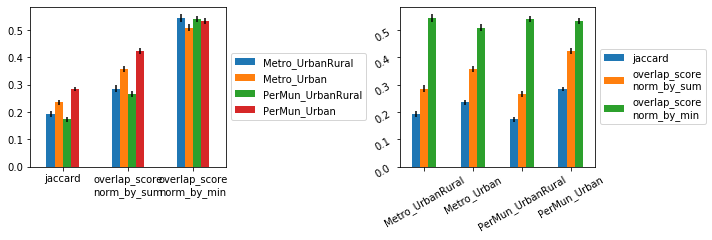

In [219]:

fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(10,4))
# yerr =    np.array([pd.DataFrame(df).values.T for df in intra_index_lvl_error_bar[True].values()])
yerr = np.array([pd.DataFrame(df).values.T for df in tbl_error_bar[True].values()])
# yerr = np.append(yerr, yerr2, axis=2)

# tmp_df = pd.concat([pd.DataFrame(intra_index_lvl_aver[True]), pd.DataFrame(tbl_aver[True])], sort=False)
tmp_df = pd.DataFrame(tbl_aver[True])[cols]
tmp_df.index = [i.replace('<br/>','\n') for i in tmp_df.index]
tmp_df.plot(ax=ax1,kind='bar',yerr=yerr).legend(loc='center left', bbox_to_anchor=(1, 0.5))
tmp_df.T.plot(ax=ax2,kind='bar',yerr=yerr.transpose(2,1,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=30)


plt.savefig('figs/intra_methodLevel_Overlap.png', bbox_inches='tight')


### method lvl

In [310]:
def get_method_lvl_mats(overlap_scores, aver_first=True, add_mean=True):
    n=7
    mat_sum = np.ones((n,n)).astype(object)
    mat_min = np.ones((n,n)).astype(object)
    for (gt1,by1,gt2,by2), method_flattened_matrix in overlap_scores.groupby(['gt1','by1','gt2','by2']):
        m1 = gt1+'<br/>'+by1
        m2 = gt2+'<br/>'+by2
        i = method_order[m1]
        j = method_order[m2]
        mat_min[i,j] = mat_min[j,i] = stats_str_for_arr(method_flattened_matrix.overlap_score_norm_by_min.values,aver_first=aver_first,return_values=False)
        mat_sum[i,j] = mat_sum[j,i] = stats_str_for_arr(method_flattened_matrix.overlap_score_norm_by_sum.values,aver_first=aver_first,return_values=False)
    mat_min = pd.DataFrame(mat_min, index=method_names, columns=method_names)
    mat_min.index.name = 'overlap_score<br/>norm_by_min'
    mat_sum = pd.DataFrame(mat_sum, index=method_names, columns=method_names)
    mat_sum.index.name = 'overlap_score<br/>norm_by_sum'
    
    if add_mean:
        mat_sum['row<br/>mean'] = (mat_sum.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mat_sum['row<br/>mean'] = mat_sum['row<br/>mean'].apply(lambda x: f'{x:.03f}')
        mat_min['row<br/>mean'] = (mat_min.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mat_min['row<br/>mean'] = mat_min['row<br/>mean'].apply(lambda x: f'{x:.03f}')
    
    return mat_min, mat_sum

In [311]:
i = 3
astr = admin_strs[i]
overlap_scores = all_overlap_scores[astr]
mat_min, mat_sum = get_method_lvl_mats(overlap_scores, aver_first=False, add_mean=True)
print(astr.replace('_', '\n'))
display(grad_bg_with_str(mat_sum, 0, 1, mask_tril=True))
display(grad_bg_with_str(mat_min, 0, 1, mask_tril=True))

PerMun
Urban


/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop,rowmean
overlap_scorenorm_by_sum,,,,,,,,
agebarea,1,"0.519 (0.383~0.608)[0.085, 0.849]0.513 (0.162)(0.472~0.554)(-0.041~0.042)","0.316 (0.254~0.461)[0.048, 0.607]0.332 (0.133)(0.298~0.366)(-0.035~0.034)","0.493 (0.371~0.588)[0.213, 0.800]0.496 (0.140)(0.460~0.532)(-0.037~0.036)","0.248 (0.180~0.339)[0.073, 0.707]0.276 (0.137)(0.240~0.310)(-0.036~0.034)","0.437 (0.357~0.559)[0.117, 0.708]0.451 (0.139)(0.416~0.487)(-0.035~0.036)","0.320 (0.243~0.436)[0.101, 0.672]0.344 (0.143)(0.307~0.381)(-0.037~0.037)",0.389
agebpop,,1,"0.344 (0.286~0.458)[0.156, 0.618]0.369 (0.118)(0.339~0.399)(-0.029~0.030)","0.454 (0.367~0.536)[0.176, 0.746]0.452 (0.124)(0.420~0.484)(-0.032~0.032)","0.492 (0.394~0.581)[0.276, 0.751]0.493 (0.112)(0.464~0.522)(-0.029~0.029)","0.355 (0.262~0.471)[0.168, 0.621]0.371 (0.122)(0.339~0.401)(-0.032~0.030)","0.351 (0.243~0.473)[0.123, 0.621]0.366 (0.138)(0.331~0.401)(-0.035~0.035)",0.419
grid_idw,,,1,"0.450 (0.362~0.529)[0.174, 0.727]0.448 (0.113)(0.419~0.477)(-0.029~0.029)","0.422 (0.319~0.516)[0.140, 0.756]0.417 (0.132)(0.384~0.451)(-0.033~0.033)","0.376 (0.305~0.460)[0.090, 0.625]0.372 (0.128)(0.339~0.404)(-0.032~0.033)","0.350 (0.246~0.447)[0.043, 0.610]0.344 (0.131)(0.311~0.378)(-0.033~0.034)",0.376
gridarea,,,,1,"0.589 (0.507~0.650)[0.255, 0.833]0.562 (0.134)(0.528~0.597)(-0.034~0.035)","0.508 (0.386~0.681)[0.142, 0.921]0.525 (0.189)(0.477~0.574)(-0.049~0.048)","0.345 (0.198~0.495)[0.073, 0.790]0.358 (0.184)(0.312~0.404)(-0.047~0.046)",0.473
gridpop,,,,,1,"0.353 (0.281~0.450)[0.203, 0.652]0.371 (0.114)(0.342~0.400)(-0.030~0.029)","0.342 (0.256~0.455)[0.108, 0.652]0.354 (0.139)(0.318~0.389)(-0.035~0.035)",0.408
vorarea,,,,,,1,"0.718 (0.509~0.844)[0.000, 1.000]0.668 (0.240)(0.608~0.729)(-0.060~0.061)",0.458
vorpop,,,,,,,1,0.404


,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop,rowmean
overlap_scorenorm_by_min,,,,,,,,
agebarea,1,"0.572 (0.463~0.714)[0.102, 0.923]0.575 (0.172)(0.531~0.619)(-0.044~0.044)","0.370 (0.305~0.516)[0.055, 0.809]0.399 (0.150)(0.361~0.438)(-0.038~0.039)","0.582 (0.511~0.671)[0.216, 0.903]0.585 (0.133)(0.550~0.619)(-0.034~0.034)","0.345 (0.264~0.470)[0.091, 0.728]0.353 (0.147)(0.316~0.390)(-0.037~0.037)","0.505 (0.443~0.605)[0.128, 0.862]0.525 (0.152)(0.486~0.564)(-0.038~0.039)","0.428 (0.352~0.536)[0.128, 0.998]0.443 (0.156)(0.402~0.482)(-0.041~0.039)",0.467
agebpop,,1,"0.466 (0.322~0.529)[0.165, 0.756]0.437 (0.134)(0.402~0.471)(-0.035~0.034)","0.526 (0.419~0.621)[0.194, 0.833]0.523 (0.139)(0.488~0.559)(-0.035~0.036)","0.598 (0.509~0.655)[0.345, 0.802]0.594 (0.098)(0.568~0.618)(-0.025~0.025)","0.444 (0.341~0.565)[0.204, 0.866]0.464 (0.145)(0.426~0.500)(-0.038~0.037)","0.504 (0.386~0.580)[0.204, 0.850]0.498 (0.146)(0.461~0.535)(-0.038~0.037)",0.518
grid_idw,,,1,"0.556 (0.436~0.635)[0.181, 0.847]0.542 (0.141)(0.506~0.578)(-0.036~0.037)","0.532 (0.399~0.614)[0.199, 0.847]0.520 (0.151)(0.482~0.558)(-0.038~0.039)","0.491 (0.376~0.583)[0.118, 0.863]0.489 (0.158)(0.449~0.530)(-0.040~0.041)","0.524 (0.397~0.611)[0.118, 0.881]0.503 (0.144)(0.466~0.540)(-0.037~0.038)",0.490
gridarea,,,,1,"0.674 (0.570~0.734)[0.275, 0.894]0.646 (0.143)(0.609~0.683)(-0.036~0.037)","0.678 (0.561~0.806)[0.175, 0.965]0.663 (0.182)(0.618~0.711)(-0.046~0.047)","0.504 (0.390~0.641)[0.175, 0.991]0.512 (0.178)(0.467~0.555)(-0.045~0.044)",0.587
gridpop,,,,,1,"0.483 (0.409~0.609)[0.305, 0.813]0.514 (0.135)(0.480~0.548)(-0.035~0.034)","0.564 (0.474~0.648)[0.332, 0.983]0.578 (0.141)(0.543~0.614)(-0.036~0.036)",0.533
vorarea,,,,,,1,"0.878 (0.727~0.988)[0.000, 1.000]0.817 (0.218)(0.764~0.876)(-0.053~0.059)",0.580
vorpop,,,,,,,1,0.567


## overlap score within method temporal change correlation

In [69]:
def overlap_jaccard_with_next_hour(hourly_index, geoms):
    overlap = []
    for i in range(n_bins):
        index_hour1 = hourly_index[str(i)]
        index_hour2 = hourly_index[str((i+1)%n_bins)]
        index_intxn = set(index_hour1) & set(index_hour2)
        index_union = set(index_hour1) | set(index_hour2)
        # geoms_hour1 = cascaded_union(geoms.loc[index_hour1].geometry)
        # geoms_hour2 = cascaded_union(geoms.loc[index_hour2].geometry)
        # geoms_intxn = cascaded_union(geoms.loc[index_intxn].geometry)
        # geoms_union = cascaded_union(geoms.loc[index_union].geometry)
        area_hour1 = geoms.loc[index_hour1].area.sum()
        area_hour2 = geoms.loc[index_hour2].area.sum()
        area_intxn = geoms.loc[index_intxn].area.sum()
        
        jacc = area_intxn/(area_hour1+area_hour2-area_intxn)
        norm_by_sum = 2* area_intxn / (area_hour1+area_hour2)
        norm_by_min = area_intxn / min(area_hour1,area_hour2)
        overlap.append({'jacc': jacc, 'norm_by_sum':norm_by_sum, 'norm_by_min':norm_by_min})
    return overlap

In [70]:
methods = [('ageb', 'area'), ('ageb', 'pop'), ('grid', '_idw'), ('grid', 'area'), ('grid', 'pop'), ('vor','area'), ('vor','pop')]

In [226]:
pd.DataFrame(overlap_next_hour[admin_strs[0]][2][('ageb', 'pop')]).jacc.mean()

0.8490326600738477

In [227]:
pd.DataFrame(overlap_next_hour[admin_strs[0]][2][('grid', 'pop')]).jacc.mean()

0.8290525473771327

In [88]:
overlap_next_hour = defaultdict(lambda: defaultdict(dict)) # [astr][sun][(geom_type, by)]=[{mname1:score, ...}, ...]
for per_mun, urb_only in [(False,False), (False, True), (True, False), (True, True)]:
    astr = ADMIN_STR(per_mun, urb_only)
    print('='*20, astr)
    for geom_type, by in methods:
        print(geom_type, by, end=' ')
        geoms = zms_all_geoms[geom_type][(per_mun, urb_only)]
        for sun, hourly_index in hourly_all_indexes[(per_mun, urb_only)][(geom_type, by)].items():
            print(sun, end=' ')
            overlap = overlap_jaccard_with_next_hour(hourly_index, geoms)
            overlap_next_hour[astr][sun][(geom_type, by)]=overlap
        print()


==================== Metro_UrbanRural
ageb area 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
ageb pop 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
grid _idw 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
grid area 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
grid pop 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
vor area 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

In [122]:
srho_on_ovlap_next_hour = defaultdict(lambda:defaultdict(dict))
for mname in ['jacc', 'norm_by_sum', 'norm_by_min']:
    for per_mun, urb_only in [(False,False), (False, True), (True, False), (True, True)]:
        astr = ADMIN_STR(per_mun, urb_only)
        for sun in overlap_next_hour[astr].keys():
            _, r = spe_rho_corr(pd.DataFrame(overlap_next_hour[astr][sun]).applymap(lambda x: x[mname]), clean_table=False, larger_than=0)    
            srho_on_ovlap_next_hour[astr][mname][sun] = r

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

invalid value encountered in less_equal



In [108]:
mname = 'jacc'
astr = ADMIN_STR(False,False)
corr = extract_corr_for_one_measure(srho_on_ovlap_next_hour[astr][mname], mname, average_on_raw=False, return_pd=True)
corr.columns = [method_names[i].replace('<br/>',' ') + '<br/>' + method_names[j].replace('<br/>',' ') for i in range(len(method_names)) for j in range(i+1, len(method_names))]
corr = corr.loc[corr.mean(axis=1).sort_values(ascending=False).index]
# corr.sort_values([corr.columns[-1], corr.columns[0]], ascending=False)
grad_bg(corr,mini=0,maxi=1)

jacc 9 0 5 isnull
jacc 9 1 5 isnull
jacc 9 2 5 isnull
jacc 9 3 5 isnull
jacc 9 4 5 isnull
jacc 9 5 6 isnull
jacc 16 0 6 isnull
jacc 16 1 6 isnull
jacc 16 2 6 isnull
jacc 16 3 6 isnull
jacc 16 4 6 isnull
jacc 16 5 6 isnull
jacc 29 0 5 isnull
jacc 29 0 6 isnull
jacc 29 1 5 isnull
jacc 29 1 6 isnull
jacc 29 2 5 isnull
jacc 29 2 6 isnull
jacc 29 3 5 isnull
jacc 29 3 6 isnull
jacc 29 4 5 isnull
jacc 29 4 6 isnull
jacc 29 5 6 isnull
jacc 39 0 5 isnull
jacc 39 1 5 isnull
jacc 39 2 5 isnull
jacc 39 3 5 isnull
jacc 39 4 5 isnull
jacc 39 5 6 isnull
jacc 54 0 6 isnull
jacc 54 1 6 isnull
jacc 54 2 6 isnull
jacc 54 3 6 isnull
jacc 54 4 6 isnull
jacc 54 5 6 isnull
jacc 58 0 2 isnull
jacc 58 0 5 isnull
jacc 58 0 6 isnull
jacc 58 1 2 isnull
jacc 58 1 5 isnull
jacc 58 1 6 isnull
jacc 58 2 3 isnull
jacc 58 2 4 isnull
jacc 58 2 5 isnull
jacc 58 2 6 isnull
jacc 58 3 5 isnull
jacc 58 3 6 isnull
jacc 58 4 5 isnull
jacc 58 4 6 isnull
jacc 58 5 6 isnull
jacc 59 0 5 isnull
jacc 59 1 5 isnull
jacc 59 2 5 isnull

,ageb areaageb pop,ageb areagrid _idw,ageb areagrid area,ageb areagrid pop,ageb areavor area,ageb areavor pop,ageb popgrid _idw,ageb popgrid area,ageb popgrid pop,ageb popvor area,ageb popvor pop,grid _idwgrid area,grid _idwgrid pop,grid _idwvor area,grid _idwvor pop,grid areagrid pop,grid areavor area,grid areavor pop,grid popvor area,grid popvor pop,vor areavor pop
1,0.823,0.772,0.814,0.885,0.752,0.710,0.853,0.830,0.917,0.640,0.605,0.842,0.785,0.654,0.616,0.789,0.770,0.753,0.683,0.656,0.986
12,0.901,0.779,0.614,0.809,0.729,0.846,0.887,0.745,0.860,0.641,0.813,0.783,0.822,0.610,0.798,0.851,0.337,0.588,0.550,0.726,0.941
10,0.861,0.803,0.752,0.846,0.588,0.576,0.859,0.762,0.865,0.548,0.569,0.800,0.875,0.619,0.722,0.897,0.561,0.667,0.611,0.668,0.902
20,0.697,0.714,0.734,0.863,0.497,0.754,0.817,0.636,0.786,0.817,0.663,0.836,0.790,0.677,0.690,0.879,0.500,0.643,0.556,0.697,0.701
11,0.580,0.618,0.490,0.610,0.353,0.442,0.777,0.815,0.907,0.687,0.712,0.761,0.750,0.627,0.606,0.838,0.613,0.660,0.667,0.682,0.937
43,0.532,0.206,0.457,0.532,0.501,0.514,0.484,0.598,0.878,0.756,0.764,0.493,0.530,0.478,0.483,0.648,0.653,0.601,0.869,0.866,0.987
54,0.745,0.684,0.694,0.569,0.337,0.250,0.893,0.873,0.812,0.528,0.212,0.854,0.855,0.697,0.330,0.864,0.470,0.500,0.488,0.462,0.235
24,0.602,0.576,0.791,0.600,0.396,0.354,0.617,0.685,0.600,0.391,0.367,0.613,0.808,0.478,0.397,0.834,0.452,0.431,0.483,0.414,0.955
30,0.830,0.834,0.889,0.828,0.070,0.070,0.925,0.789,0.944,0.293,0.293,0.761,0.895,0.311,0.311,0.782,0.123,0.123,0.367,0.367,1.000
39,0.554,0.780,0.275,0.686,0.400,0.444,0.616,0.187,0.777,0.444,0.558,0.410,0.774,0.663,0.699,0.313,0.468,0.454,0.607,0.613,0.907


In [111]:
def ovlp_next_hour_stats_astr(srho_on_ovlap_next_hour, astr, aver_first=True, average_on_raw=False):
    tbl = {}
    tbl_aver = {}
    tbl_error_bar = defaultdict(dict)
    # extract_corr_for_one_measure defined 6.2.4 index-level

    for mname,srhos_per_mname in srho_on_ovlap_next_hour[astr].items():
        corr = extract_corr_for_one_measure(srhos_per_mname, mname, average_on_raw=average_on_raw, return_pd=False)

        bres = bs.bootstrap(corr, stat_func=bs_stats.mean)
        print(bres.value)
        l_diff = f'{(bres.lower_bound-bres.value):.3f}'
        u_diff = f'{(bres.upper_bound-bres.value):.3f}'
        str_median_quantile = f'{np.median(corr):.3f} <br/>({np.percentile(corr,25):.3f}~{np.percentile(corr,75):.3f})'
        str_mean_std = f'{bres.value:.3f} ({corr.std():.3f})'
        str_conf_inter = f'({bres.lower_bound:.3f}~{bres.upper_bound:.3f})<br/>({l_diff}~{u_diff})'
        str_min_max = f'[{corr.min():.3f}, {corr.max():.3f}]'
        if aver_first:
            final_str = f'{str_mean_std}<br/>{str_conf_inter}<br/>{str_median_quantile}<br/>{str_min_max}'
        else: 
            final_str = f'{str_median_quantile}<br/>{str_min_max}<br/>{str_mean_std}<br/>{str_conf_inter}'
        tbl[mname]=final_str
        tbl_aver[mname]= bres.value
        tbl_error_bar['lower'][mname] = bres.value-bres.lower_bound
        tbl_error_bar['upper'][mname] =bres.upper_bound-bres.value
    return tbl, tbl_aver, tbl_error_bar

In [133]:

ovnh_index_lvl_results = defaultdict(dict)
ovnh_index_lvl_aver = defaultdict(dict)
ovnh_index_lvl_error_bar = defaultdict(dict)


for aver_first in [True, False]:
    for i in range(4):
        astr = admin_strs[i]
        tmp_tbl, tbl_aver, tbl_error_bar = stats_of_srho_index_lvl(
            srho_on_ovlap_next_hour[astr],aver_first=aver_first, average_on_raw=False)    
        ovnh_index_lvl_results[aver_first][astr]=tmp_tbl
        ovnh_index_lvl_aver[aver_first][astr]=tbl_aver
        ovnh_index_lvl_error_bar[aver_first][astr]=tbl_error_bar
#         break
#     break

jacc 9 0 5 isnull
jacc 9 1 5 isnull
jacc 9 2 5 isnull
jacc 9 3 5 isnull
jacc 9 4 5 isnull
jacc 9 5 6 isnull
jacc 16 0 6 isnull
jacc 16 1 6 isnull
jacc 16 2 6 isnull
jacc 16 3 6 isnull
jacc 16 4 6 isnull
jacc 16 5 6 isnull
jacc 29 0 5 isnull
jacc 29 0 6 isnull
jacc 29 1 5 isnull
jacc 29 1 6 isnull
jacc 29 2 5 isnull
jacc 29 2 6 isnull
jacc 29 3 5 isnull
jacc 29 3 6 isnull
jacc 29 4 5 isnull
jacc 29 4 6 isnull
jacc 29 5 6 isnull
jacc 39 0 5 isnull
jacc 39 1 5 isnull
jacc 39 2 5 isnull
jacc 39 3 5 isnull
jacc 39 4 5 isnull
jacc 39 5 6 isnull
jacc 54 0 6 isnull
jacc 54 1 6 isnull
jacc 54 2 6 isnull
jacc 54 3 6 isnull
jacc 54 4 6 isnull
jacc 54 5 6 isnull
jacc 58 0 2 isnull
jacc 58 0 5 isnull
jacc 58 0 6 isnull
jacc 58 1 2 isnull
jacc 58 1 5 isnull
jacc 58 1 6 isnull
jacc 58 2 3 isnull
jacc 58 2 4 isnull
jacc 58 2 5 isnull
jacc 58 2 6 isnull
jacc 58 3 5 isnull
jacc 58 3 6 isnull
jacc 58 4 5 isnull
jacc 58 4 6 isnull
jacc 58 5 6 isnull
jacc 59 0 5 isnull
jacc 59 1 5 isnull
jacc 59 2 5 isnull

norm_by_min 27 0 5 isnull
norm_by_min 27 1 5 isnull
norm_by_min 27 2 5 isnull
norm_by_min 27 3 5 isnull
norm_by_min 27 4 5 isnull
norm_by_min 27 5 6 isnull
norm_by_min 29 0 6 isnull
norm_by_min 29 1 6 isnull
norm_by_min 29 2 6 isnull
norm_by_min 29 3 6 isnull
norm_by_min 29 4 6 isnull
norm_by_min 29 5 6 isnull
norm_by_min 33 0 5 isnull
norm_by_min 33 1 5 isnull
norm_by_min 33 2 5 isnull
norm_by_min 33 3 5 isnull
norm_by_min 33 4 5 isnull
norm_by_min 33 5 6 isnull
norm_by_min 39 0 5 isnull
norm_by_min 39 0 6 isnull
norm_by_min 39 1 5 isnull
norm_by_min 39 1 6 isnull
norm_by_min 39 2 5 isnull
norm_by_min 39 2 6 isnull
norm_by_min 39 3 5 isnull
norm_by_min 39 3 6 isnull
norm_by_min 39 4 5 isnull
norm_by_min 39 4 6 isnull
norm_by_min 39 5 6 isnull
norm_by_min 40 0 5 isnull
norm_by_min 40 1 5 isnull
norm_by_min 40 2 5 isnull
norm_by_min 40 3 5 isnull
norm_by_min 40 4 5 isnull
norm_by_min 40 5 6 isnull
norm_by_min 54 0 1 isnull
norm_by_min 54 0 2 isnull
norm_by_min 54 0 3 isnull
norm_by_min 

norm_by_min 39 0 5 isnull
norm_by_min 39 1 5 isnull
norm_by_min 39 2 5 isnull
norm_by_min 39 3 5 isnull
norm_by_min 39 4 5 isnull
norm_by_min 39 5 6 isnull
norm_by_min 40 0 5 isnull
norm_by_min 40 1 5 isnull
norm_by_min 40 2 5 isnull
norm_by_min 40 3 5 isnull
norm_by_min 40 4 5 isnull
norm_by_min 40 5 6 isnull
norm_by_min 54 0 1 isnull
norm_by_min 54 0 2 isnull
norm_by_min 54 0 3 isnull
norm_by_min 54 0 4 isnull
norm_by_min 54 0 5 isnull
norm_by_min 54 0 6 isnull
norm_by_min 54 1 2 isnull
norm_by_min 54 1 3 isnull
norm_by_min 54 1 4 isnull
norm_by_min 54 1 5 isnull
norm_by_min 54 1 6 isnull
norm_by_min 54 2 5 isnull
norm_by_min 54 2 6 isnull
norm_by_min 54 3 5 isnull
norm_by_min 54 3 6 isnull
norm_by_min 54 4 5 isnull
norm_by_min 54 4 6 isnull
norm_by_min 54 5 6 isnull
norm_by_min 58 0 1 isnull
norm_by_min 58 0 2 isnull
norm_by_min 58 0 3 isnull
norm_by_min 58 0 4 isnull
norm_by_min 58 0 5 isnull
norm_by_min 58 0 6 isnull
norm_by_min 58 1 2 isnull
norm_by_min 58 1 6 isnull
norm_by_min 

norm_by_min 19 1 5 isnull
norm_by_min 19 2 5 isnull
norm_by_min 19 3 5 isnull
norm_by_min 19 4 5 isnull
norm_by_min 19 5 6 isnull
norm_by_min 23 0 5 isnull
norm_by_min 23 0 6 isnull
norm_by_min 23 1 5 isnull
norm_by_min 23 1 6 isnull
norm_by_min 23 2 5 isnull
norm_by_min 23 2 6 isnull
norm_by_min 23 3 5 isnull
norm_by_min 23 3 6 isnull
norm_by_min 23 4 5 isnull
norm_by_min 23 4 6 isnull
norm_by_min 23 5 6 isnull
norm_by_min 27 0 5 isnull
norm_by_min 27 1 5 isnull
norm_by_min 27 2 5 isnull
norm_by_min 27 3 5 isnull
norm_by_min 27 4 5 isnull
norm_by_min 27 5 6 isnull
norm_by_min 29 0 6 isnull
norm_by_min 29 1 6 isnull
norm_by_min 29 2 6 isnull
norm_by_min 29 3 6 isnull
norm_by_min 29 4 6 isnull
norm_by_min 29 5 6 isnull
norm_by_min 33 0 5 isnull
norm_by_min 33 1 5 isnull
norm_by_min 33 2 5 isnull
norm_by_min 33 3 5 isnull
norm_by_min 33 4 5 isnull
norm_by_min 33 5 6 isnull
norm_by_min 39 0 5 isnull
norm_by_min 39 0 6 isnull
norm_by_min 39 1 5 isnull
norm_by_min 39 1 6 isnull
norm_by_min 

norm_by_min 39 0 5 isnull
norm_by_min 39 1 5 isnull
norm_by_min 39 2 5 isnull
norm_by_min 39 3 5 isnull
norm_by_min 39 4 5 isnull
norm_by_min 39 5 6 isnull
norm_by_min 40 0 5 isnull
norm_by_min 40 1 5 isnull
norm_by_min 40 2 5 isnull
norm_by_min 40 3 5 isnull
norm_by_min 40 4 5 isnull
norm_by_min 40 5 6 isnull
norm_by_min 54 0 1 isnull
norm_by_min 54 0 2 isnull
norm_by_min 54 0 3 isnull
norm_by_min 54 0 4 isnull
norm_by_min 54 0 5 isnull
norm_by_min 54 0 6 isnull
norm_by_min 54 1 2 isnull
norm_by_min 54 1 3 isnull
norm_by_min 54 1 4 isnull
norm_by_min 54 1 5 isnull
norm_by_min 54 1 6 isnull
norm_by_min 54 2 5 isnull
norm_by_min 54 2 6 isnull
norm_by_min 54 3 5 isnull
norm_by_min 54 3 6 isnull
norm_by_min 54 4 5 isnull
norm_by_min 54 4 6 isnull
norm_by_min 54 5 6 isnull
norm_by_min 58 0 1 isnull
norm_by_min 58 0 2 isnull
norm_by_min 58 0 3 isnull
norm_by_min 58 0 4 isnull
norm_by_min 58 0 5 isnull
norm_by_min 58 0 6 isnull
norm_by_min 58 1 2 isnull
norm_by_min 58 1 6 isnull
norm_by_min 

In [323]:
print('color by average')
display(grad_bg_with_str(pd.DataFrame(ovnh_index_lvl_results[True]), 0, 1, mask_tril=False))
print('color by median')
display(grad_bg_with_str(pd.DataFrame(ovnh_index_lvl_results[False]), 0, 1, mask_tril=False))


color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
jacc,"0.439 (0.111)(0.392~0.487)(-0.048~0.048)0.458 (0.332~0.540)[0.269, 0.644]","0.453 (0.094)(0.412~0.492)(-0.041~0.039)0.416 (0.385~0.518)[0.315, 0.640]","0.476 (0.123)(0.422~0.527)(-0.053~0.051)0.412 (0.368~0.573)[0.322, 0.695]","0.461 (0.095)(0.419~0.500)(-0.042~0.040)0.423 (0.386~0.539)[0.341, 0.641]"
norm_by_sum,"0.440 (0.111)(0.391~0.486)(-0.048~0.046)0.460 (0.332~0.539)[0.274, 0.646]","0.453 (0.095)(0.413~0.492)(-0.040~0.039)0.410 (0.385~0.519)[0.317, 0.642]","0.476 (0.123)(0.423~0.527)(-0.053~0.051)0.413 (0.368~0.573)[0.322, 0.695]","0.461 (0.095)(0.418~0.501)(-0.043~0.039)0.425 (0.387~0.539)[0.342, 0.640]"
norm_by_min,"0.248 (0.088)(0.206~0.280)(-0.041~0.033)0.231 (0.199~0.275)[0.141, 0.579]","0.240 (0.044)(0.221~0.259)(-0.019~0.019)0.235 (0.214~0.273)[0.146, 0.325]","0.340 (0.069)(0.310~0.368)(-0.030~0.028)0.323 (0.274~0.382)[0.258, 0.478]","0.291 (0.060)(0.265~0.316)(-0.026~0.025)0.289 (0.251~0.343)[0.192, 0.412]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
jacc,"0.458 (0.332~0.540)[0.269, 0.644]0.439 (0.111)(0.393~0.486)(-0.047~0.047)","0.416 (0.385~0.518)[0.315, 0.640]0.453 (0.094)(0.411~0.492)(-0.042~0.039)","0.412 (0.368~0.573)[0.322, 0.695]0.476 (0.123)(0.422~0.527)(-0.054~0.051)","0.423 (0.386~0.539)[0.341, 0.641]0.461 (0.095)(0.420~0.501)(-0.041~0.040)"
norm_by_sum,"0.460 (0.332~0.539)[0.274, 0.646]0.440 (0.111)(0.391~0.487)(-0.048~0.047)","0.410 (0.385~0.519)[0.317, 0.642]0.453 (0.095)(0.412~0.493)(-0.041~0.040)","0.413 (0.368~0.573)[0.322, 0.695]0.476 (0.123)(0.423~0.526)(-0.053~0.050)","0.425 (0.387~0.539)[0.342, 0.640]0.461 (0.095)(0.418~0.500)(-0.043~0.039)"
norm_by_min,"0.231 (0.199~0.275)[0.141, 0.579]0.248 (0.088)(0.206~0.279)(-0.042~0.032)","0.235 (0.214~0.273)[0.146, 0.325]0.240 (0.044)(0.222~0.259)(-0.019~0.019)","0.323 (0.274~0.382)[0.258, 0.478]0.340 (0.069)(0.310~0.368)(-0.030~0.028)","0.289 (0.251~0.343)[0.192, 0.412]0.291 (0.060)(0.265~0.315)(-0.026~0.025)"


## deprecated

##### Method level

In [369]:
per_pair_method_overlap_score = overlap_scores.groupby(['gt1','by1','gt2','by2']).agg({'overlap_score_norm_by_sum':['mean','std'], 'overlap_score_norm_by_min': ['mean','std']})

In [1216]:
per_pair_method_overlap_score_mean = per_pair_method_overlap_score.loc[:, pd.IndexSlice[:,'mean']]
per_pair_method_overlap_score_mean.columns = ['by_sum','by_min']
# per_pair_method_overlap_score_mean=per_pair_method_overlap_score_mean.sort_values('by_sum')


per_pair_method_overlap_score_std = per_pair_method_overlap_score.loc[:, pd.IndexSlice[:,'std']]
per_pair_method_overlap_score_std.columns = ['by_sum','by_min']
# per_pair_method_overlap_score_std =per_pair_method_overlap_score_std.loc[per_pair_method_overlap_score_mean.index]

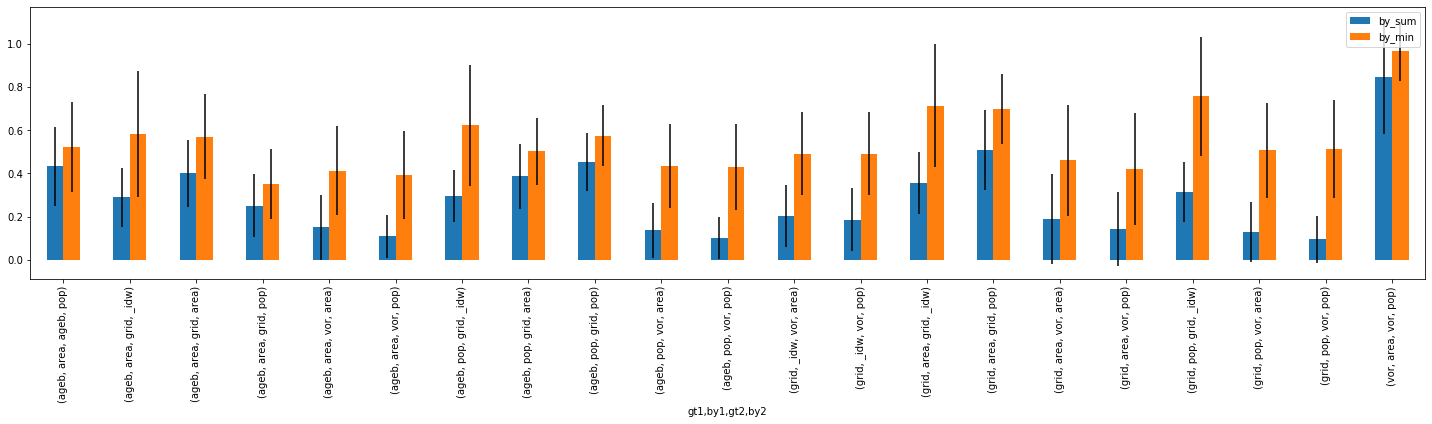

In [1220]:
per_pair_method_overlap_score_mean.plot(kind='bar',figsize=(25,5), yerr=per_pair_method_overlap_score_std)

##### overlap levels count

In [266]:
ovlp_weak = 0.3
ovlp_medm = 0.5
ovlp_strn = 0.7

In [267]:
scol = 'overlap_score_norm_by_min'
overlap_scores['None'] = overlap_scores[scol].apply(lambda x: x<ovlp_weak)
overlap_scores['Weak'] = overlap_scores[scol].apply(lambda x: ovlp_weak<=x<ovlp_medm)
overlap_scores['Medm'] = overlap_scores[scol].apply(lambda x: ovlp_medm<=x<ovlp_strn)
overlap_scores['Strn'] = overlap_scores[scol].apply(lambda x: x>=ovlp_strn)


In [268]:
print(ADMIN_STR(per_mun, urb_only), scol)
slvl_count = []
for sun_id, sun_overlap_score in overlap_scores.groupby('CVE_SUN'):
    slvl_count.append({
        'CVE_SUN': sun_id,
        'None': sun_overlap_score['None'].sum(),
        'Weak': sun_overlap_score.Weak.sum(),
        'Medm': sun_overlap_score.Medm.sum(),
        'Strn': sun_overlap_score.Strn.sum(),
    })
#     break


slvl_count=pd.DataFrame(slvl_count).set_index('CVE_SUN')

Metro_Urban overlap_score_norm_by_min


In [269]:
print(ADMIN_STR(per_mun, urb_only))
print(scol)

display(grad_bg(slvl_count, format_float=False, mask_tril=False,mini=0, maxi=21))

Metro_Urban
overlap_score_norm_by_min


,None,Weak,Medm,Strn
CVE_SUN,,,,
1,5,6,9,1
2,8,5,6,2
3,1,12,6,2
4,6,12,2,1
5,8,9,3,1
6,2,7,5,7
7,1,5,14,1
8,8,7,3,3
9,2,5,3,11


In [1291]:
print(ADMIN_STR(per_mun, urb_only), scol)

c = cluster.OPTICS().fit(slvl_count)
print(c.labels_)
cluster_members = pd.DataFrame(np.unique(c.labels_, return_counts=True), index=['c','#']).T.set_index('c')


c_avg = {}
for cl in cluster_members.index.values:
#     if cl ==-1: continue
    c_avg[cl]=slvl_count.loc[c.labels_==cl].mean().round(1).astype(str) +' ('+slvl_count.loc[c.labels_==cl].std().round(1).astype(str) +')'

cluster_members.join(pd.DataFrame(c_avg).T)

Metro_Urban overlap_score_norm_by_min
[-1  1  0 -1 -1  2 -1 -1  2 -1  0 -1 -1 -1  1 -1  2  0 -1 -1 -1 -1 -1 -1
  0 -1 -1  1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1  0 -1 -1  2
  2 -1  0  0  2 -1  1  1 -1 -1  2]


,#,None,Weak,Medm,Strn
c,,,,,
-1,38,4.7 (4.2),6.0 (2.8),6.0 (3.7),4.3 (4.3)
0,7,2.4 (1.0),10.4 (0.8),5.9 (0.7),2.3 (1.0)
1,5,8.2 (0.8),5.2 (0.8),5.8 (1.3),1.8 (0.4)
2,9,2.2 (1.5),5.9 (2.0),4.6 (1.9),8.3 (1.6)


##### overlap score can be aggregate per city

In [1183]:
per_city_overlap_score = overlap_scores.groupby('CVE_SUN').agg({'overlap_score_norm_by_sum':['mean','std'], 'overlap_score_norm_by_min': ['mean','std']})

In [1205]:
per_city_overlap_score_mean = per_city_overlap_score.loc[:, pd.IndexSlice[:,'mean']]
per_city_overlap_score_mean.columns = ['by_sum','by_min']
per_city_overlap_score_mean=per_city_overlap_score_mean.sort_values('by_sum')


In [1207]:
per_city_overlap_score_std = per_city_overlap_score.loc[:, pd.IndexSlice[:,'std']]
per_city_overlap_score_std.columns = ['by_sum','by_min']
per_city_overlap_score_std =per_city_overlap_score_std.loc[per_city_overlap_score_mean.index]

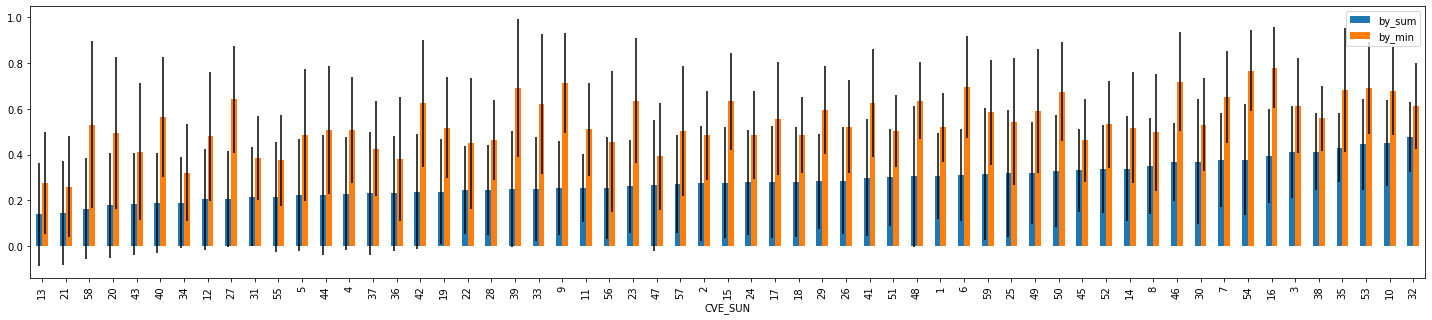

In [1208]:
per_city_overlap_score_mean.plot(kind='bar',figsize=(25,5), yerr=per_city_overlap_score_std)

# permanent hotspot temporal ranking evolution

In [325]:
from numba import njit

In [326]:
from scipy.stats import rankdata

In [327]:
@njit
def spear_weighted(x, y, w):
    n = len(x)
    sum_ab = 0
    sum_aa = 0
    sum_bb = 0
    for i in range(n):
        for j in range(i + 1, n):
            wij = w[i,j]
            aij = x[j] - x[i]
            bij = y[j] - y[i]
            sum_ab += aij * bij * wij
            sum_aa += aij**2 * wij
            sum_bb += bij**2 * wij
    return sum_ab / np.sqrt(sum_aa*sum_bb)

def weighted_correlation(x,y,w,rank=False):
    if rank:
        x = rankdata(x)
        y = rankdata(y)
    return spear_weighted(x,y,w)

In [328]:
# defined in section "hotspot overlap"
# permanent_all_indexes  # [(per_mun, urb_only)][(geom_type, by)][sun] = indexes of this geom_type in sun
# avg_all_geoms  # keys: (geom_type, by, per_mun, urb_only)
# zms_all_geoms={'ageb': zms_agebs_tmp, 'grid':zms_grids, 'vor': zms_sub_vors}  #[geom_type][(per_mun, urb_only)]

In [329]:
def temporal_change(avg, weight):
    temporal_res = []
    for tod in range(n_bins):
        tod_next = str((tod + 1) % n_bins)
        tod = str(tod)
        rho, _ = spearmanr(avg[tod], avg[tod_next])
#         tau, _ = kendalltau(avg[tod], avg[tod_next])
        w_pre_ranking = weighted_correlation(avg[tod].values, avg[tod_next].values, weight, rank=False)
        wrho = weighted_correlation(avg[tod].values, avg[tod_next].values, weight, rank=True)
        temporal_res.append({
            'tod': f'{tod}~{tod_next}',
            'rho': rho,
#             'tau': tau,
            'weighted_pre_ranking': w_pre_ranking,
            'weighted_rho': wrho
        })
    return temporal_res

## compute n_bins-dim vector of temporal evolution

In [331]:
# [astr][sun_id][type_of_measure] = n_bins-dim vector of evolution between pairs of hour-bins
all_temporal_evolution = defaultdict(lambda : defaultdict(lambda: defaultdict(dict)))

# loop each astr combo
for per_mun, urb_only in [(False, False), (False, True), (True, False), (True, True)]:
    astr = ADMIN_STR(per_mun, urb_only)
    print('='*20, astr)
    
    # loop each method (geom_type, by)
    for method in method_names:
        geom_type, by = method.split('<br/>')
        per_idx = permanent_all_indexes[(per_mun, urb_only)][(geom_type, by)]
        
        # loop each zm
        for sun_id, per_idx_zm in per_idx.items():
            # TODO: what is the minimum amount of hotspot to compute temporal evolution?
            # 1: no correlation; 2: it will be either 1 or -1
            if len(per_idx_zm)<=2:
                print(f'zm {sun_id} has {len(per_idx_zm)} permanent hotspot in {astr}, {geom_type}, {by}, skipped')
                continue
            
            per_geom_zm = zms_all_geoms[geom_type][(per_mun, urb_only)].loc[per_idx_zm]
            per_weight = 1 / ((ud_helper.ftr_hs.gis.polys_centroid_pairwise_dist(per_geom_zm, per_geom_zm.crs)+1e-9)/1000)
            per_avg_zm = avg_all_geoms[(geom_type, by, per_mun, urb_only)].loc[per_idx_zm]
            
            # compute temporal change
            t_evol = pd.DataFrame(temporal_change(per_avg_zm, per_weight))
            
            # store results
            all_temporal_evolution[astr][sun_id]['rho'][(geom_type, by)] = t_evol.rho.values
#             all_temporal_evolution[astr][sun_id]['tau'][(geom_type, by)] = t_evol.tau.values
            all_temporal_evolution[astr][sun_id]['weighted_rho'][(geom_type, by)] = t_evol.weighted_rho.values
            all_temporal_evolution[astr][sun_id]['weighted_pre_ranking'][(geom_type, by)] = t_evol.weighted_pre_ranking.values

==================== Metro_UrbanRural
zm 15 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 16 has 2 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 19 has 2 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 23 has 2 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 26 has 2 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 33 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 35 has 2 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 54 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 58 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 59 has 1 permanent hotspot in Metro_UrbanRural, vor, area, skipped
zm 9 has 2 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
zm 15 has 1 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
zm 19 has 1 permanent hotspot in Metro_UrbanRural, vor, pop, skipped
zm 20 has 2 permanent hotspot in Metro_UrbanRural, vor, 

## based on nbin-dim vector, compare stability between vectors from diff methods

In [332]:
n_methods = len(method_names)
# [astr][measure_name][sun_id] = flatten_matrix (index=method_names, columns=method_names)
all_temporal_evol_comparison_flatten_matrix = defaultdict(lambda: defaultdict(dict))

# loop each astr
for astr, temporal_evolution in all_temporal_evolution.items():
    
    # loop each zm
    for sun_id, t_evol_zm in temporal_evolution.items():
        
        # loop each measure (rho, weighted rho)
        for measure_name, t_evol_zm_vecs in t_evol_zm.items():
            flatten_matrix = np.ones((n_methods, n_methods))
            
            # loop each method
            for i in range(n_methods):
                for j in range(i+1, n_methods):
                    gt1, by1 = method_names[i].split('<br/>')
                    gt2, by2 = method_names[j].split('<br/>')
                    
                    if (gt1, by1) not in t_evol_zm_vecs or (gt2, by2) not in t_evol_zm_vecs:
                        # a method can produce no temporal change, as there is only one permanent hotspot
                        flatten_matrix[i,j] = flatten_matrix[j,i] = None
                        
                    else:
                        vec1 = t_evol_zm_vecs[(gt1, by1)]
                        vec2 = t_evol_zm_vecs[(gt2, by2)]
                        rho, _ = spearmanr(vec1, vec2)
                        flatten_matrix[i,j] = flatten_matrix[j,i] = rho
                    
            all_temporal_evol_comparison_flatten_matrix[astr][measure_name][sun_id] = flatten_matrix

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



In [334]:
grad_bg(pd.DataFrame(all_temporal_evol_comparison_flatten_matrix[astr]['weighted_pre_ranking'][3], index=method_names, columns=method_names),mini=0,maxi=1)

,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop
agebarea,1.000,0.951,0.944,0.934,0.981,0.875,0.811
agebpop,0.951,1.000,0.920,0.943,0.974,0.832,0.810
grid_idw,0.944,0.920,1.000,0.920,0.959,0.925,0.902
gridarea,0.934,0.943,0.920,1.000,0.958,0.871,0.843
gridpop,0.981,0.974,0.959,0.958,1.000,0.887,0.855
vorarea,0.875,0.832,0.925,0.871,0.887,1.000,0.912
vorpop,0.811,0.810,0.902,0.843,0.855,0.912,1.000


In [335]:
grad_bg(pd.DataFrame(all_temporal_evol_comparison_flatten_matrix[astr]['weighted_rho'][3], index=method_names, columns=method_names),mini=0,maxi=1)

,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop
agebarea,1.000,0.910,0.881,0.849,0.888,0.610,0.550
agebpop,0.910,1.000,0.923,0.875,0.927,0.613,0.516
grid_idw,0.881,0.923,1.000,0.868,0.937,0.542,0.515
gridarea,0.849,0.875,0.868,1.000,0.927,0.654,0.631
gridpop,0.888,0.927,0.937,0.927,1.000,0.562,0.586
vorarea,0.610,0.613,0.542,0.654,0.562,1.000,0.363
vorpop,0.550,0.516,0.515,0.631,0.586,0.363,1.000


## index-lvl temporal evolution stability

In [336]:
def get_flat_triu(mat, remove_na=True):
    assert mat.shape[0]==mat.shape[1]
    arr = []
    n = mat.shape[1]
    for i in range(n):
        for j in range(i+1,n):
            if remove_na and pd.isnull(mat[i,j]): continue
            arr.append(mat[i,j])
    return arr

In [121]:
# stats_str_for_arr  defined in 7.4 Analysis index-lvl and method-lvl

In [343]:

temp_evol_res = defaultdict(lambda : defaultdict(dict))  # [aver_first][astr][measure_name]
tbl_aver = defaultdict(lambda : defaultdict(dict))  # [aver_first][astr][measure_name]
tbl_error_bar = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))  # [aver_first][astr][lower/upper][measure_name]

for aver_first in [True, False]:
    for astr, measure_stability in all_temporal_evol_comparison_flatten_matrix.items():
        for measure_name, stability_matrixes in measure_stability.items():
            arr = []
            for sun_id, mat in stability_matrixes.items():
                arr.extend(get_flat_triu(mat))
            fstr, mean, lb, ub = stats_str_for_arr(np.array(arr),aver_first=aver_first)
            temp_evol_res[aver_first][astr][measure_name] = fstr
            tbl_aver[aver_first][astr][measure_name]= mean
            tbl_error_bar[aver_first][astr]['lower'][measure_name] = lb
            tbl_error_bar[aver_first][astr]['upper'][measure_name] =ub

In [345]:
# tables
print('color by average')
cols = ['Metro_UrbanRural','Metro_Urban','PerMun_UrbanRural','PerMun_Urban']
display_cols = [col.replace('_','<br/>') for col in cols]

tmp_df = pd.DataFrame(temp_evol_res[True]).loc[['weighted_rho', 'weighted_pre_ranking'],cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))
print('color by median')

tmp_df = pd.DataFrame(temp_evol_res[False]).loc[['weighted_rho', 'weighted_pre_ranking'],cols]
tmp_df.columns = display_cols
display(grad_bg_with_str(tmp_df, 0, 1, mask_tril=False))


color by average


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
weighted_rho,"0.637 (0.262)(0.622~0.653)(-0.015~0.016)0.689 (0.478~0.856)[-0.299, 1.000]","0.623 (0.258)(0.607~0.638)(-0.015~0.016)0.685 (0.451~0.832)[-0.396, 0.978]","0.607 (0.283)(0.592~0.624)(-0.016~0.016)0.678 (0.457~0.825)[-0.457, 1.000]","0.648 (0.252)(0.633~0.663)(-0.015~0.015)0.704 (0.501~0.848)[-0.412, 0.990]"
weighted_pre_ranking,"0.826 (0.161)(0.817~0.836)(-0.009~0.010)0.875 (0.762~0.943)[0.036, 1.000]","0.825 (0.162)(0.815~0.834)(-0.009~0.010)0.871 (0.778~0.934)[-0.336, 0.999]","0.840 (0.183)(0.830~0.850)(-0.010~0.011)0.900 (0.798~0.952)[-0.228, 1.000]","0.857 (0.155)(0.848~0.866)(-0.009~0.009)0.905 (0.819~0.950)[-0.169, 1.000]"


color by median


,MetroUrbanRural,MetroUrban,PerMunUrbanRural,PerMunUrban
weighted_rho,"0.689 (0.478~0.856)[-0.299, 1.000]0.637 (0.262)(0.622~0.653)(-0.015~0.016)","0.685 (0.451~0.832)[-0.396, 0.978]0.623 (0.258)(0.607~0.639)(-0.015~0.016)","0.678 (0.457~0.825)[-0.457, 1.000]0.607 (0.283)(0.591~0.624)(-0.016~0.017)","0.704 (0.501~0.848)[-0.412, 0.990]0.648 (0.252)(0.633~0.663)(-0.015~0.015)"
weighted_pre_ranking,"0.875 (0.762~0.943)[0.036, 1.000]0.826 (0.161)(0.817~0.836)(-0.009~0.010)","0.871 (0.778~0.934)[-0.336, 0.999]0.825 (0.162)(0.815~0.834)(-0.009~0.010)","0.900 (0.798~0.952)[-0.228, 1.000]0.840 (0.183)(0.830~0.850)(-0.010~0.010)","0.905 (0.819~0.950)[-0.169, 1.000]0.857 (0.155)(0.848~0.866)(-0.009~0.009)"


In [346]:
loc_index = ['weighted_rho', 'weighted_pre_ranking']

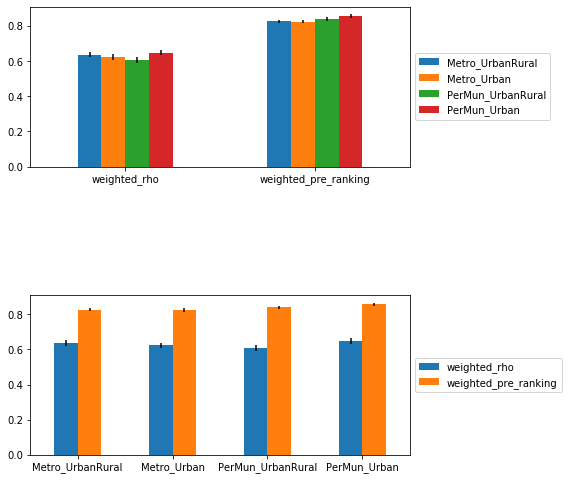

In [352]:
# plot
fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2, figsize=(8,8))
# yerr =    np.array([pd.DataFrame(df).values.T for df in intra_index_lvl_error_bar[True].values()])
yerr = np.array([pd.DataFrame(df).loc[loc_index].values.T for df in tbl_error_bar[True].values()])
# yerr = np.append(yerr, yerr2, axis=2)

tmp_df = pd.DataFrame(tbl_aver[True]).loc[loc_index,cols]
tmp_df.index = [i.replace('<br/>','\n') for i in tmp_df.index]
tmp_df.plot(ax=ax1,kind='bar',yerr=yerr).legend(loc='center left', bbox_to_anchor=(1, 0.5))
tmp_df.T.plot(ax=ax2,kind='bar',yerr=yerr.transpose(2,1,0)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=0)


plt.savefig('figs/intra_methodLevel_TemporalEvolution.png', bbox_inches='tight')


## method-level

In [269]:
def get_method_lvl_stats(stability_matrixes, aver_first=True, add_mean=True):
    # stability_matrixes[sun_id]= 7*7 method-pair stability score
    
    n=7
    mat_stats = np.ones((n,n)).astype(object)
    for i in range(n):
        for j in range(i+1, n):
            arr = [mat[i,j] for mat in stability_matrixes.values() if not pd.isnull(mat[i,j])]
            mat_stats[i,j] = mat_stats[j,i] =  stats_str_for_arr(np.array(arr),aver_first=aver_first,return_values=False)
    
    mat_stats = pd.DataFrame(mat_stats, index=method_names, columns=method_names)
    
    if add_mean:
        mat_stats['row<br/>mean'] = (mat_stats.applymap(lambda x: float(x.split(' ')[0]) if x!=1 else x).sum(axis=0)-1)/(n-1)
        mat_stats['row<br/>mean'] = mat_stats['row<br/>mean'].apply(lambda x: f'{x:.03f}')
    
    return mat_stats

In [318]:
aver_first = False
i = 3
astr = admin_strs[i]
print(astr.replace('_', '\n'))

for measure_name, stability_matrixes in all_temporal_evol_comparison_flatten_matrix[astr].items():
    if measure_name not in ['weighted_rho',]: continue
    display_tbl = get_method_lvl_stats(stability_matrixes, aver_first,add_mean=True)
    display_tbl.index.name = measure_name.replace('_','<br/>')
    display(grad_bg_with_str(display_tbl, 0, 1, mask_tril=True))


PerMun
Urban


/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



,agebarea,agebpop,grid_idw,gridarea,gridpop,vorarea,vorpop,rowmean
weightedrho,,,,,,,,
agebarea,1,"0.797 (0.631~0.874)[0.136, 0.990]0.724 (0.216)(0.668~0.784)(-0.056~0.060)","0.780 (0.616~0.854)[0.077, 0.965]0.705 (0.205)(0.654~0.762)(-0.052~0.056)","0.690 (0.585~0.842)[-0.065, 0.970]0.667 (0.224)(0.609~0.727)(-0.057~0.061)","0.823 (0.668~0.883)[0.271, 0.982]0.743 (0.201)(0.692~0.796)(-0.051~0.053)","0.605 (0.350~0.712)[0.046, 0.952]0.554 (0.229)(0.486~0.623)(-0.068~0.069)","0.503 (0.369~0.677)[-0.412, 0.946]0.498 (0.264)(0.426~0.572)(-0.072~0.074)",0.700
agebpop,,1,"0.833 (0.709~0.904)[0.195, 0.977]0.775 (0.176)(0.732~0.822)(-0.043~0.047)","0.728 (0.621~0.866)[0.174, 0.970]0.701 (0.202)(0.651~0.756)(-0.050~0.055)","0.861 (0.766~0.927)[0.319, 0.989]0.808 (0.167)(0.767~0.853)(-0.042~0.045)","0.613 (0.450~0.760)[0.026, 0.952]0.581 (0.227)(0.514~0.650)(-0.066~0.069)","0.543 (0.393~0.741)[-0.404, 0.970]0.518 (0.281)(0.442~0.598)(-0.077~0.080)",0.729
grid_idw,,,1,"0.770 (0.650~0.850)[-0.040, 0.948]0.694 (0.223)(0.640~0.754)(-0.054~0.060)","0.879 (0.757~0.935)[0.288, 0.971]0.820 (0.151)(0.783~0.861)(-0.037~0.041)","0.606 (0.471~0.766)[-0.194, 0.957]0.573 (0.253)(0.499~0.651)(-0.074~0.078)","0.591 (0.429~0.748)[-0.210, 0.948]0.550 (0.283)(0.474~0.631)(-0.075~0.082)",0.743
gridarea,,,,1,"0.821 (0.706~0.895)[0.011, 0.971]0.747 (0.208)(0.694~0.805)(-0.052~0.058)","0.561 (0.402~0.696)[-0.185, 0.934]0.539 (0.249)(0.466~0.616)(-0.073~0.078)","0.529 (0.364~0.633)[-0.315, 0.932]0.489 (0.272)(0.415~0.566)(-0.075~0.077)",0.683
gridpop,,,,,1,"0.642 (0.508~0.738)[0.054, 0.955]0.603 (0.208)(0.543~0.668)(-0.060~0.065)","0.610 (0.444~0.761)[-0.272, 0.965]0.550 (0.282)(0.476~0.631)(-0.074~0.080)",0.773
vorarea,,,,,,1,"0.567 (0.412~0.820)[-0.039, 0.983]0.576 (0.279)(0.492~0.662)(-0.084~0.086)",0.599
vorpop,,,,,,,1,0.557
